## PAC-Bayesian AUC classification and scoring

In [1]:
!pip install particles

Defaulting to user installation because normal site-packages is not writeable


In [141]:
import numpy as np
from scipy.stats import mode
from scipy.spatial.distance import cdist
from sklearn import metrics
import seaborn as sb
import particles
from particles import distributions as dists
from particles import resampling as rs
from particles import smc_samplers as ssps
from particles.collectors import Moments
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import time
from numba import jit
import scipy

In [2]:
np.random.seed(0)
plt.style.use('ggplot')

### Data preparation
Run the code below to load one of the datasets

In [50]:
# load data
dataset = 0 # 0 for pima, 1 for sonar, 2 for eeg
dataset_names = ["pima", "sonar", "eeg"]
data = np.genfromtxt(dataset_names[dataset]+'.csv', delimiter=',')

In [51]:
data # last column is the target

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [52]:
print(data.shape)
print("Balance :",len(np.where(data[:,-1]==1.)[0])/len(data))

(768, 9)
Balance : 0.3489583333333333


In [53]:
n = data.shape[0]
# add a variable equal to 1 for all observations (equivalent to adding an intercept)
data = np.concatenate((np.ones((n,1)),data), axis=1)
# split data into x/y and train/test
x_train = data[:3*n//4,:-1]
x_test = data[3*n//4:,:-1]
y_train = data[:3*n//4,-1]
y_test = data[3*n//4:,-1]
# map y fom {0,1} to {-1,1}
y_train = y_train*2-1
y_test = y_test*2-1
# normalize the data
data_mean = x_train.mean(axis=0)
data_mean[0] = 0.
data_std = x_train.std(axis=0)
data_std[0] = 1.
x_train = (x_train-data_mean)/data_std
x_test = (x_test-data_mean)/data_std
# convert to contiguous array for faster numba computations
x_train = np.array(x_train,order="C")
x_test = np.array(x_test,order="C")
# 5-fold cv preparation
skf = StratifiedKFold(5)
x_train_fold, y_train_fold, x_val_fold, y_val_fold = [],[],[],[]
for train_index, val_index in skf.split(x_train,y_train):
    x_train_fold.append(x_train[train_index])
    y_train_fold.append(y_train[train_index])
    x_val_fold.append(x_train[val_index])
    y_val_fold.append(y_train[val_index])

n,d = x_train.shape

In [54]:
print("x_train:\n", x_train)
print("y_train:\n", y_train[:10])

x_train:
 [[ 1.          0.65588817  0.85819334 ...  0.21280281  0.438215
   1.42904929]
 [ 1.         -0.83972381 -1.07585957 ... -0.65934693 -0.38420635
  -0.18576903]
 [ 1.          1.25413296  1.93266718 ... -1.07050324  0.57230543
  -0.10077859]
 ...
 [ 1.         -0.54060141 -0.67676929 ...  0.34985491 -0.84011383
  -0.95068297]
 [ 1.         -0.83972381  0.70469708 ... -0.22327206  1.22785868
  -0.86569253]
 [ 1.         -0.83972381 -0.03208498 ...  0.44952916 -0.59577126
  -0.69571166]]
y_train:
 [ 1. -1.  1. -1.  1. -1.  1. -1.  1.  1.]


#### Function definitions

In [55]:
@jit(nopython=True, parallel=True)
def risk(theta, X = x_train, y = y_train):
    n = len(X)
    s_X = X @ theta.T
    res = np.zeros(len(theta))
    for obs in range(len(theta)):
        for i in range(n):
            for j in range(i):
                res[obs] += ( (s_X[i][obs] - s_X[j][obs])*(y[i]-y[j]) < 0)
    return 2*res/(n*(n-1))

In [142]:
# useful functions
def get_coefs(pf):
    len_theta = pf.X.theta["beta"].shape[1]
    coef = []
    for j in range(len_theta):
        coef.append(pf.X.theta["beta"][:,j])
        plt.hist(coef[j], bins=50)
        plt.show()
    return(np.array([np.median(coef[i]) for i in range(len_theta)]))
def plot_coefs(pf, plots = 20):
    len_theta = pf.X.theta["beta"].shape[1]
    coef = []
    for j in range(min(len_theta,plots)):
        coef.append(pf.X.theta["beta"][:,j])
        plt.hist(coef[j], bins=50)
        plt.show()

@jit(nopython=True)
def mode1(x):
    values = np.unique(x)[1:-1]
    counts = np.zeros(len(values))
    for i in range(len(values)):
        for j in x:
            if j==values[i]:
                counts[i]+=1
    return values[counts.argmax()]


@jit(nopython=True)
def modal_val(theta, bin_size=30):
    nb_coordinates = theta.shape[1]
    res=[]
    for j in range(nb_coordinates):
        m, M=np.quantile(theta[:,j], 0.1), np.quantile(theta[:,j], 0.9)
        bins=np.linspace(m, M+(M-m)/bin_size, bin_size)
        inds=np.digitize(theta[:,j], bins) # indices of the bin in which the coefs are
        modal_bin=mode1(inds) # index of the bin with the largest count of values
        res.append(np.mean(theta[:,j][np.where(inds==modal_bin)]))
    return np.array(res)

@jit(nopython=True)
def auc(theta, X = x_test, y = y_test):
    preds = X@theta
    thresholds = np.quantile(preds,np.linspace(0,1,50))
    tpr = [np.sum(((preds>threshold)) & (y==1))/np.sum(y==1) for threshold in thresholds]
    fpr = [np.sum(((preds>threshold)) & (y==-1))/np.sum(y==-1) for threshold in thresholds]
    return -np.trapz(tpr, fpr)

def test_acc(theta, X = x_test, y = y_test):
    acc = []
    preds = X@theta
    thresholds = np.quantile(preds,np.linspace(0,1,50))
    for threshold in thresholds:
        acc.append(np.sum(2*(X@theta>threshold)-1 == y)/len(y))
    plt.plot(thresholds, acc)
    plt.show()

def roc_curve(theta, X = x_test, y = y_test):
    preds = X@theta
    thresholds = np.quantile(preds,np.linspace(0,1,50))
    # true positive rate
    tpr = [np.sum(((preds>threshold)) & (y==1))/sum(y==1) for threshold in thresholds]
    # false positive rate
    fpr = [np.sum(((preds>threshold)) & (y==-1))/sum(y==-1) for threshold in thresholds]
    auc=metrics.auc(fpr, tpr)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.plot(fpr, tpr, label="auc="+str(round(auc,3)))
    plt.legend()
    plt.show()

def roc_curve_with_logreg(theta, X = x_test, y = y_test):
    preds = X@theta
    thresholds = np.quantile(preds,np.linspace(0,1,50))
    # true positive rate
    tpr = [np.sum(((preds>threshold)) & (y==1))/sum(y==1) for threshold in thresholds]
    # false positive rate
    fpr = [np.sum(((preds>threshold)) & (y==-1))/sum(y==-1) for threshold in thresholds]
    auc1=auc(theta, X,y)#metrics.auc(fpr, tpr)
    # logreg
    reg_coefs = LogisticRegression().fit(x_train,y_train).coef_[0]
    preds2 = X@reg_coefs
    thresholds = np.quantile(preds2,np.linspace(0,1,50))
    # true positive rate
    tpr2 = [np.sum(((preds2>threshold)) & (y==1))/sum(y==1) for threshold in thresholds]
    # false positive rate
    fpr2 = [np.sum(((preds2>threshold)) & (y==-1))/sum(y==-1) for threshold in thresholds]
    auc2 = auc(reg_coefs, X,y)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.plot(fpr, tpr, label="SMC (auc="+str(round(auc1,3))+")")
    plt.plot(fpr2, tpr2, label="Logistic (auc="+str(round(auc2,3))+")")
    plt.legend(loc='best')
    plt.show()

def exp_quadratic_kernel(xa, xb,Xi):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')
    return Xi*np.exp(sq_norm)

# Non-linear risk function
@jit(nopython=True)
def non_linear_risk(s_X, X = x_train, y = y_train):
    n = len(X)
    res = np.zeros(len(s_X))
    for obs in range(len(s_X)):
        for i in range(n):
            for j in range(n):
                res[obs] += ( (s_X[i][obs] - s_X[j][obs])*(y[i]-y[j]) < 0)
    return res/(n*(n-1))

# Gaussian process posterior
def GP(X1 = x_train, y1 = np.zeros(len(x_train)), X2 = x_test, kernel = exp_quadratic_kernel):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1),
    and the prior kernel function.
    """
    # Kernel of the observations
    Sigma11 = kernel(X1, X1, Xi)
    # Kernel of observations vs to-predict
    Sigma12 = kernel(X1, X2, Xi)

    # Solve
    solved = scipy.linalg.solve(Sigma11, Sigma12, assume_a='pos').T
    # Compute posterior mean
    mu2 = solved @ y1
    # Compute the posterior covariance
    Sigma22 = kernel(X2, X2, Xi)
    Sigma2 = Sigma22 - (solved @ Sigma12)
    return mu2, Sigma2  # mean, covariance

@jit(nopython=True)
def auc_pred(preds, X = x_test, y = y_test):
    thresholds = np.quantile(preds,np.linspace(0,1,50))
    #thresholds = np.linspace(np.min(preds),np.max(preds),50)
    tpr = [np.sum(((preds>threshold)) & (y==1))/np.sum(y==1) for threshold in thresholds]
    fpr = [np.sum(((preds>threshold)) & (y==-1))/np.sum(y==-1) for threshold in thresholds]
    return -np.trapz(tpr, fpr)

### Hyperparamater optimization

We optimize the sampler's hyperparameters using cross-validation

In [12]:
# Hyperparameters
Ks = [1] # default values, will be optimized
lambdas = [10000]
Xis = [1.]
Ns = [10**3]
ESSrmins = [0.5]


def optimize(Ks, lambdas, Xis, Ns, ESSrmins, nruns=5):
    # calculate mean and std of AUC with specified parameters
    params = [Ks, lambdas, Xis, Ns, ESSrmins]
    param_names = ["K","lambda","Xi","N","ESSrmin"]
    to_optimize = np.argmax([len(l) for l in params])
    auc_mean, auc_std, avg_time = [],[],[]
    for lamb in lambdas:
        for Xi in Xis:
            prior = dists.StructDist({'beta':dists.MvNormal(scale=Xi, cov=np.eye(d))})
            for K in Ks:
                for N in Ns:
                    for ESSrmin in ESSrmins:
                        # run {nruns} times then save mean of obtained AUC values
                        current_params = [K, lamb, Xi, N, ESSrmin]
                        print(f"{param_names[to_optimize]} = {current_params[to_optimize]}")
                        l_auc = []
                        l_best_lambda = []
                        print("AUC :", end=" ")
                        start = time.time()
                        for i in range(nruns):
                            try:
                                class PAC_Bayesian_classifier(ssps.TemperingBridge):
                                    def logtarget(self, theta):
                                        return(-lamb*risk(theta["beta"], x_train_fold[i], y_train_fold[i]))
                                model = PAC_Bayesian_classifier(base_dist=prior)
                                fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
                                pf = particles.SMC(N=N, fk=fk, ESSrmin=1., collect=[Moments],verbose=False)
                                pf.run()
                                l_auc.append(auc(modal_val(pf.X.theta["beta"]), x_val_fold[i], y_val_fold[i]))
                                print(f"{l_auc[-1]:.3f}", end=", ")
                                best_lambda = np.argmax([auc(pf.summaries.moments[i]["mean"]["beta"], x_train, y_train) for i in range(len(pf.summaries.moments))])
                                best_lambda = pf.X.shared['exponents'][best_lambda]*lamb
                                l_best_lambda.append(best_lambda)
                            except:
                                l_auc.append(0)
                                print(f"0.00 (error)", end=", ")
                        runtime = (time.time()-start)/nruns
                        auc_mean.append(np.mean(l_auc))
                        avg_time.append(runtime)
                        #auc_std.append(np.std(l_auc))
                        print(f"\nMean AUC : {auc_mean[-1]:.3f}")
                        print("best lambda: ",l_best_lambda)
                        print(f"Average run time : {runtime:.2f} s")
    print(f"Highest mean AUC obtained for {param_names[to_optimize]} = {params[to_optimize][np.argmax(auc_mean)]}")
    fig, ax1 = plt.subplots()
    xticks_plot = [str(x) for x in params[to_optimize]]
    x_plot = np.arange(len(params[to_optimize]))
    ax2 = ax1.twinx()
    ax1.plot(x_plot, auc_mean, 'g-')
    ax2.plot(x_plot, avg_time, 'r-')

    ax1.set_xlabel(param_names[to_optimize])
    ax1.set_ylabel('Average AUC', color='g')
    ax2.set_ylabel('Average CPU Time', color='r')
    plt.xticks(x_plot, xticks_plot)
    plt.title(f"Average AUC and CPU time per {param_names[to_optimize]}")
    plt.show()
    return params[to_optimize][np.argmax(auc_mean)]

In [15]:
# to compare: average cross-validation AUC for logitic regression
np.mean([auc( LogisticRegression().fit(x_train_fold[i],y_train_fold[i]).coef_[0], x_val_fold[i], y_val_fold[i]) for i in range(5)])

0.7998325573549258

K = 1
AUC : 0.787, 0.810, 0.774, 0.802, 0.821, 
Mean AUC : 0.799
best lambda:  [3723.741753395007, 977.8788995673455, 5636.561920532406, 180.77982149693864, 5173.855774984305]
Average run time : 6.01 s
K = 3
AUC : 0.787, 0.815, 0.772, 0.818, 0.816, 
Mean AUC : 0.802
best lambda:  [6215.2156913373765, 4428.144487759146, 9113.829688899037, 5430.0688363984855, 9489.196671603282]
Average run time : 9.86 s
K = 5
AUC : 0.784, 0.824, 0.767, 0.796, 0.822, 
Mean AUC : 0.799
best lambda:  [8702.594963518766, 997.0581470706937, 4782.105484558257, 9580.232554348875, 7556.1378271706335]
Average run time : 17.43 s
K = 7
AUC : 0.788, 0.814, 0.778, 0.810, 0.820, 
Mean AUC : 0.802
best lambda:  [7178.620689702282, 334.3194144638326, 9971.622546916136, 1102.0459238144426, 9883.931979121315]
Average run time : 29.28 s
K = 10
AUC : 0.789, 0.805, 0.767, 0.789, 0.816, 
Mean AUC : 0.793
best lambda:  [4356.200505329447, 348.0186267988308, 9716.959518779182, 359.5637421758806, 9759.075545199394]
Average run t

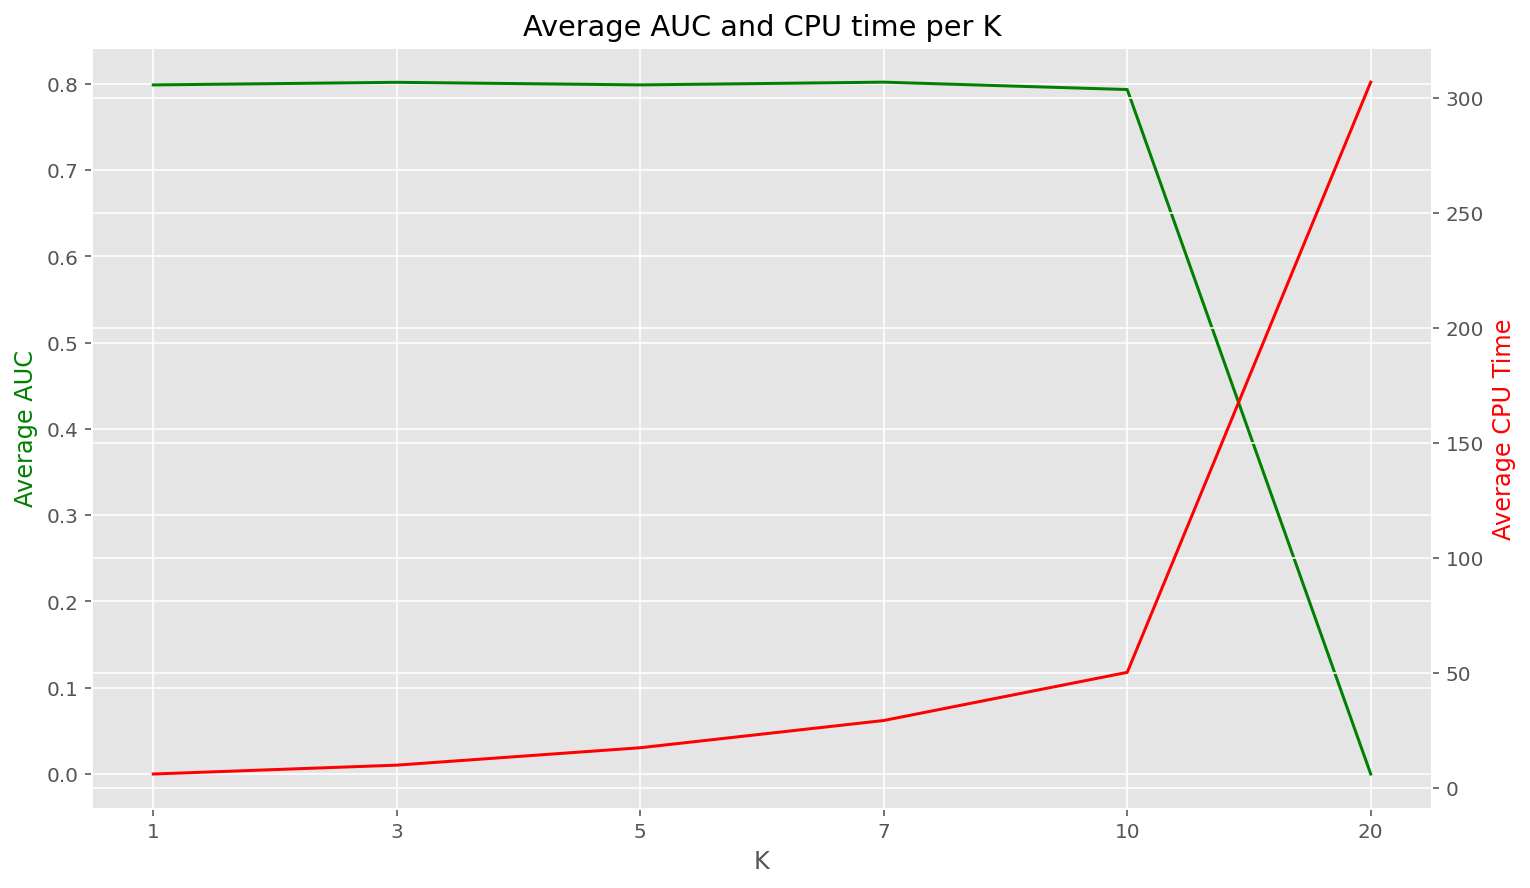

7

In [14]:
Ks = [1, 3, 5, 7, 10, 20]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

Xi = 0.1
AUC : 0.779, 0.810, 0.761, 0.802, 0.816, 
Mean AUC : 0.794
Average run time : 33.88 s
Xi = 0.2
AUC : 0.788, 0.810, 0.772, 0.807, 0.819, 
Mean AUC : 0.799
Average run time : 28.53 s
Xi = 0.30000000000000004
AUC : 0.787, 0.811, 0.757, 0.797, 0.819, 
Mean AUC : 0.794
Average run time : 30.80 s
Xi = 0.4
AUC : 0.787, 0.808, 0.766, 0.782, 0.820, 
Mean AUC : 0.793
Average run time : 29.04 s
Xi = 0.5
AUC : 0.788, 0.816, 0.768, 0.809, 0.818, 
Mean AUC : 0.800
Average run time : 30.07 s
Xi = 0.6
AUC : 0.787, 0.816, 0.769, 0.815, 0.816, 
Mean AUC : 0.801
Average run time : 31.02 s
Xi = 0.7000000000000001
AUC : 0.785, 0.810, 0.763, 0.809, 0.817, 
Mean AUC : 0.797
Average run time : 28.08 s
Xi = 0.8
AUC : 0.789, 0.813, 0.768, 0.820, 0.818, 
Mean AUC : 0.802
Average run time : 29.81 s
Xi = 0.9
AUC : 0.787, 0.816, 0.761, 0.811, 0.820, 
Mean AUC : 0.799
Average run time : 30.70 s
Xi = 1.0
AUC : 0.787, 0.813, 0.769, 0.799, 0.817, 
Mean AUC : 0.797
Average run time : 30.96 s
Xi = 1.1
AUC : 0.78

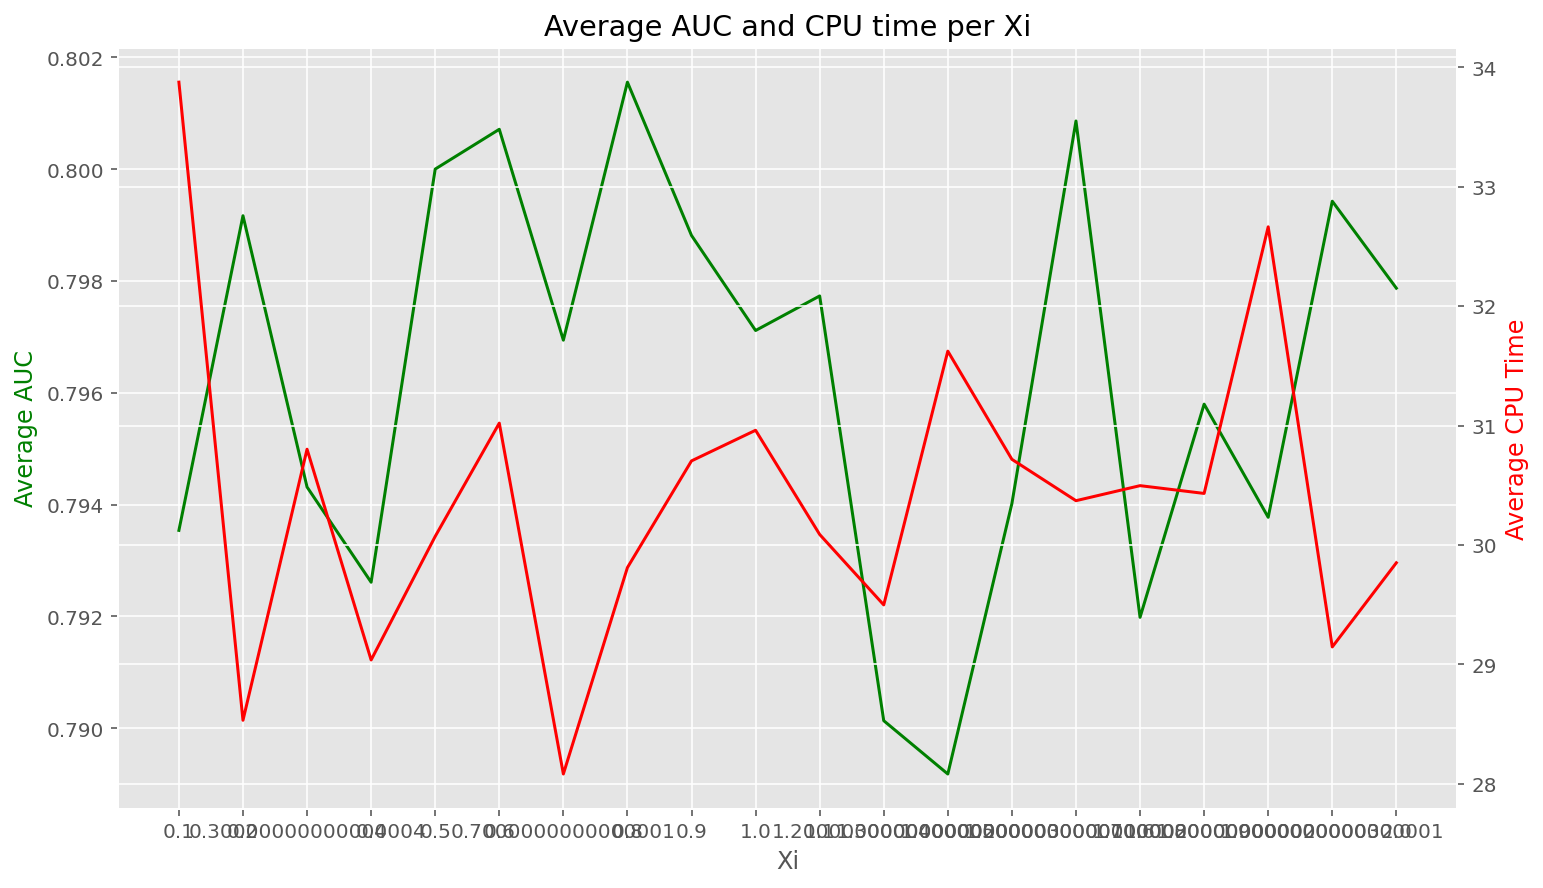

0.8

In [12]:
# We choose K=7
Ks = [7]
Xis = np.arange(0.1,2.1,0.1)
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

N = 500
AUC : 0.786, 0.808, 0.768, 0.803, 0.815, 
Mean AUC : 0.796
best lambda:  [1863.0710196031614, 9284.56019218727, 2087.046540791851, 3366.1395632910458, 9946.63430621867]
Average run time : 17.11 s
N = 1000
AUC : 0.786, 0.804, 0.753, 0.797, 0.822, 
Mean AUC : 0.792
best lambda:  [4246.384209083507, 356.29110021405467, 9999.66824938431, 337.2865962031582, 9864.440270955896]
Average run time : 28.39 s
N = 2000
AUC : 0.791, 0.813, 0.777, 0.817, 0.819, 
Mean AUC : 0.803
best lambda:  [2763.026541267231, 335.2528646097526, 4839.7230908835945, 9999.209911528766, 4908.497629408825]
Average run time : 57.92 s
Highest mean AUC obtained for N = 2000


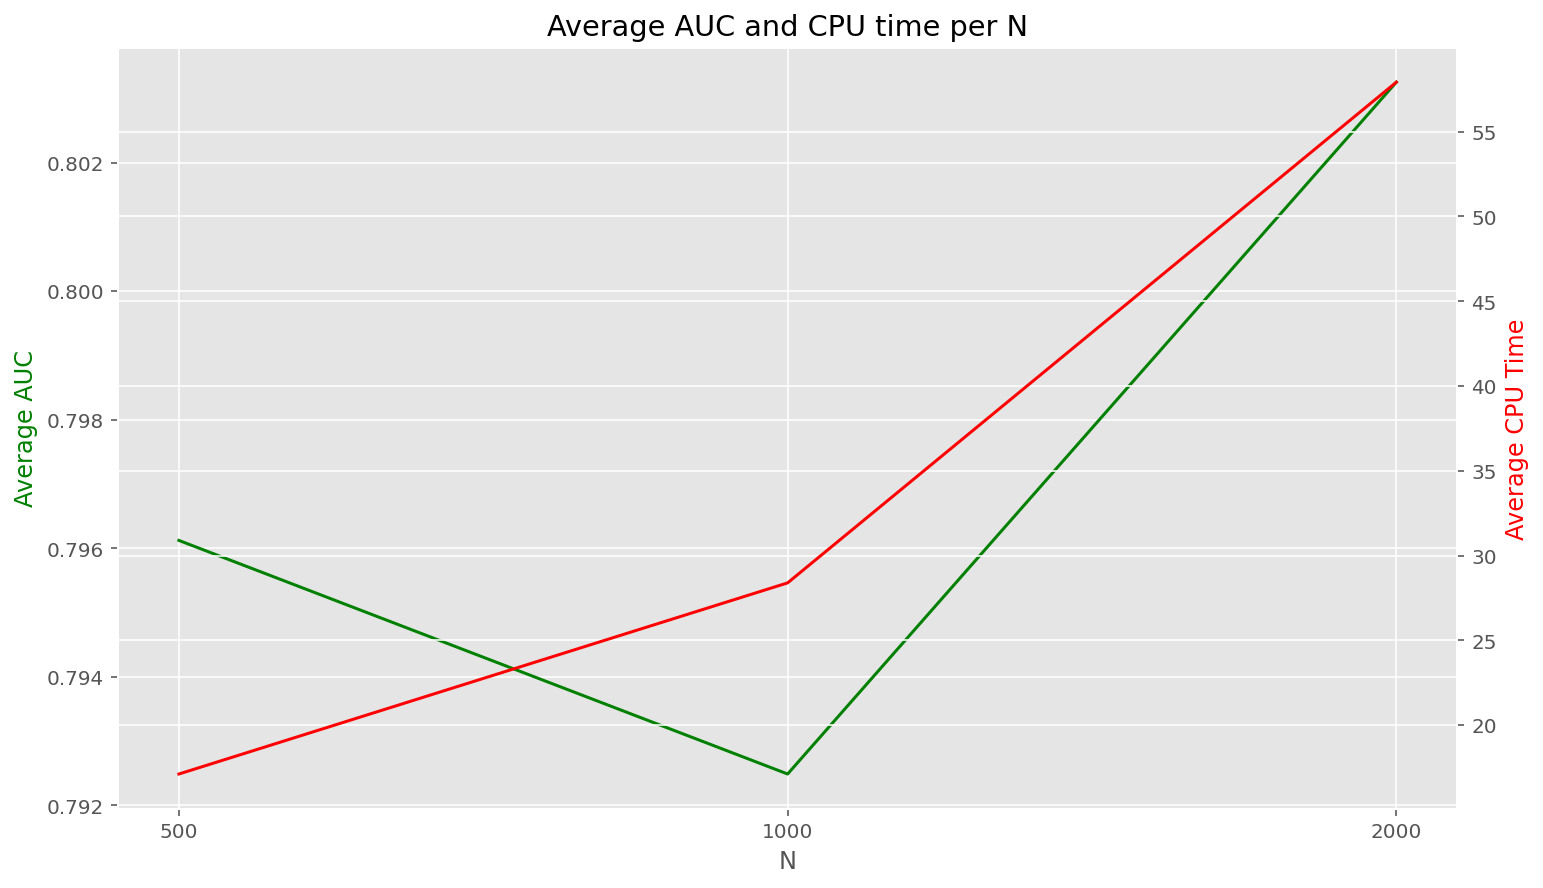

In [18]:
# We choose Xi = 0.8
Ks=[7]
Xis = [0.8]
Ns = [5*10**2, 10**3, 2*10**3] # N higher than 2000 takes too long
best_N= optimize(Ks, lambdas, Xis, Ns, ESSrmins)

lambda = 100
AUC : 0.782, 0.814, 0.742, 0.829, 0.810, 
Mean AUC : 0.795
best lambda:  [99.31035559637134, 99.9143817244971, 99.91475071173609, 87.34182675350381, 99.99910963101543]
Average run time : 38.83 s
lambda = 1000
AUC : 0.781, 0.814, 0.769, 0.807, 0.821, 
Mean AUC : 0.798
best lambda:  [447.4842121045706, 997.0829458687209, 931.318954701605, 899.7767419525793, 991.4996381122396]
Average run time : 44.79 s
lambda = 5000
AUC : 0.791, 0.815, 0.767, 0.822, 0.817, 
Mean AUC : 0.802
best lambda:  [4961.347013521762, 178.05268233757582, 3901.600310238582, 3963.722333186413, 4753.66774251641]
Average run time : 57.71 s
lambda = 10000
AUC : 0.788, 0.810, 0.761, 0.804, 0.815, 
Mean AUC : 0.796
best lambda:  [4311.3990438169785, 341.0911972851694, 9992.085236132862, 9848.830295301379, 4521.483217452204]
Average run time : 57.21 s
lambda = 50000
AUC : 0.787, 0.804, 0.763, 0.802, 0.821, 
Mean AUC : 0.795
best lambda:  [12621.179837552992, 322.8015153071206, 36981.90643960676, 25619.28954554

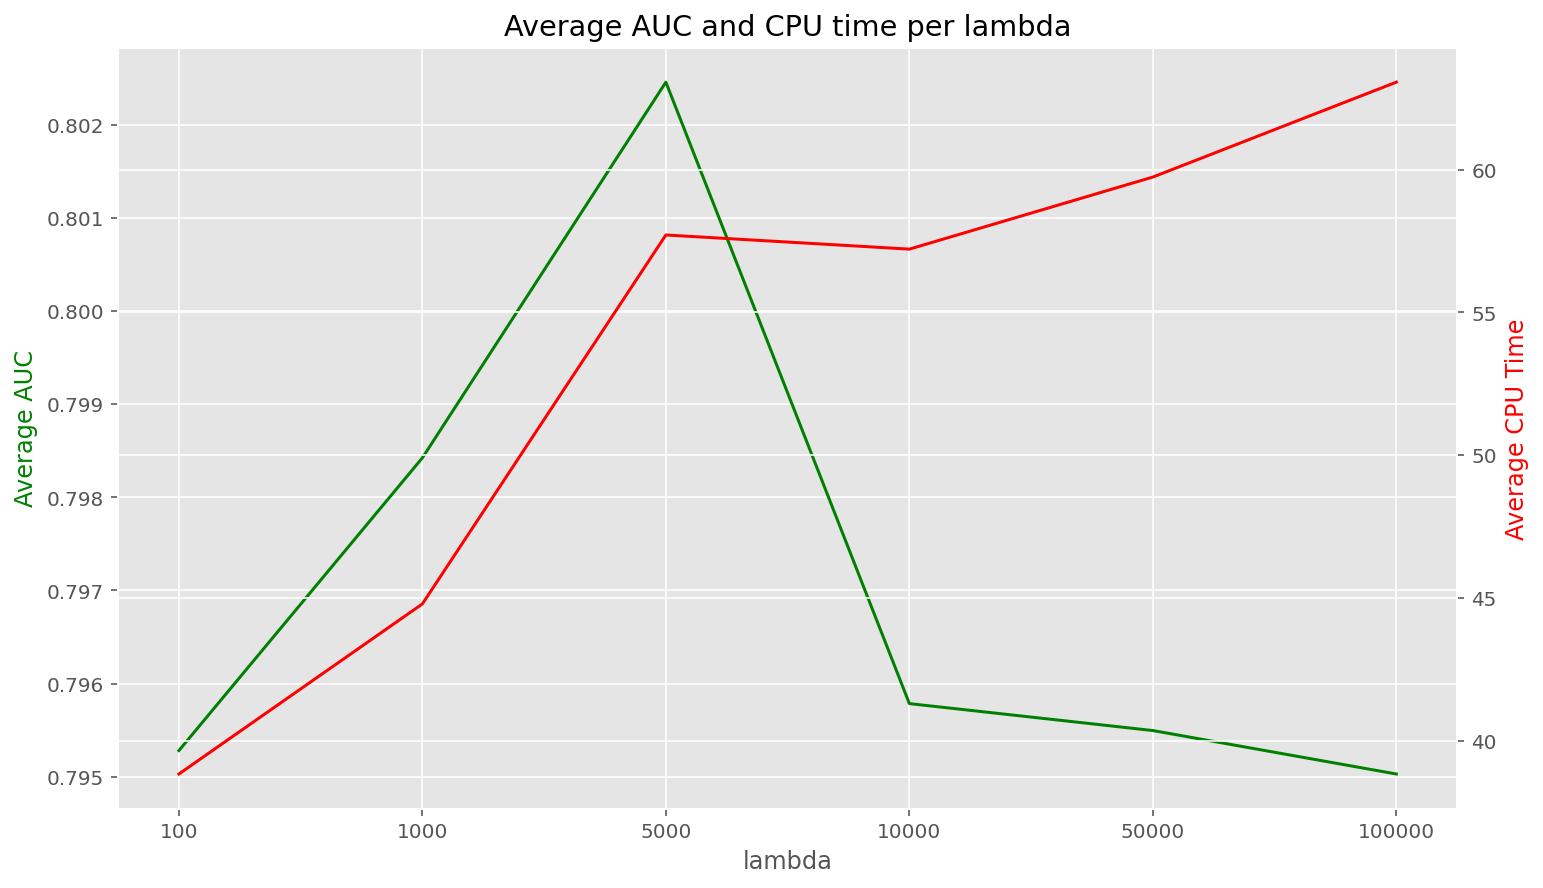

In [26]:
# We choose N = 2000
Ks=[7]
Xis = [0.8]
Ns = [2000]
lambdas = [100,1000,5000,10000,50000,100000]
ESSrmins = [0.5]
best_lambda = optimize(Ks, lambdas, Xis, Ns, ESSrmins)

ESSrmin = 0.2
AUC : 0.789, 0.804, 0.760, 0.811, 0.819, 
Mean AUC : 0.797
best lambda:  [3630.4865570994225, 331.46828194801566, 3556.5565828003478, 124.68517843711547, 2028.30799574788]
Average run time : 29.06 s
ESSrmin = 0.4
AUC : 0.785, 0.812, 0.759, 0.800, 0.818, 
Mean AUC : 0.795
best lambda:  [4977.01666872032, 1086.8554501502529, 4389.708323129717, 4579.867668746174, 3066.6742081880925]
Average run time : 43.57 s
ESSrmin = 0.5
AUC : 0.790, 0.821, 0.757, 0.801, 0.820, 
Mean AUC : 0.798
best lambda:  [4322.477857419691, 4999.168294972525, 2774.1996592908754, 4997.091408693293, 3312.101558449203]
Average run time : 58.96 s
ESSrmin = 0.6
AUC : 0.781, 0.804, 0.775, 0.800, 0.820, 
Mean AUC : 0.796
best lambda:  [4119.944836150453, 4712.069807724774, 4999.15885142381, 4426.387025577421, 3842.426674557172]
Average run time : 71.25 s
Highest mean AUC obtained for ESSrmin = 0.5


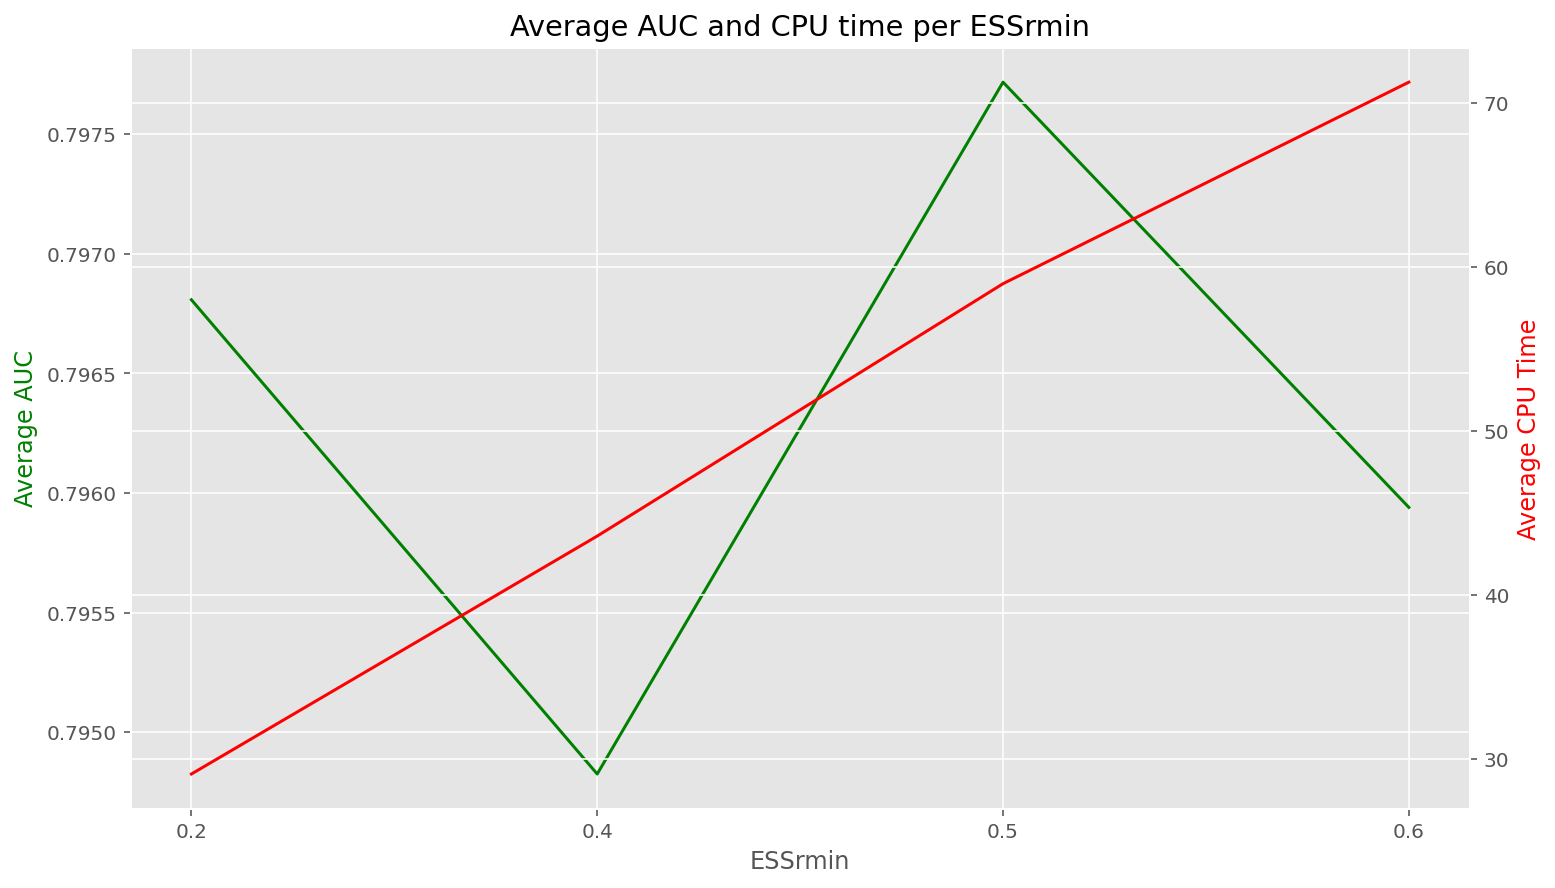

In [27]:
# We choose lambda = 5000
Ks=[7]
Xis = [0.8]
Ns = [2000]
lambdas = [5000]
ESSrmins = [0.2, 0.4, 0.5, 0.6]
best_essrmin = optimize(Ks, lambdas, Xis, Ns, ESSrmins)

In [28]:
# We choose ESSrmin = 0.5
# Best hyperparameters:
K = 7
Xi = 0.8
N = 2000
lamb = 5000
ESSrmin = 0.5

# AUC on test data:
prior = dists.StructDist({'beta':dists.MvNormal(scale=Xi, cov=np.eye(d))})
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lamb*risk(theta["beta"], x_train, y_train))
model = PAC_Bayesian_classifier(base_dist=prior)
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
l_auc=[]
for i in range(10):
    pf = particles.SMC(N=N, fk=fk, ESSrmin=1., collect=[Moments],verbose=False)
    pf.run()
    l_auc.append(auc(modal_val(pf.X.theta["beta"]), x_test, y_test))
l_auc

[0.8614754098360655,
 0.8575526932084312,
 0.8585480093676815,
 0.8639929742388761,
 0.8598360655737706,
 0.8617681498829042,
 0.8612997658079624,
 0.8624707259953166,
 0.8575526932084309,
 0.8538641686182671]

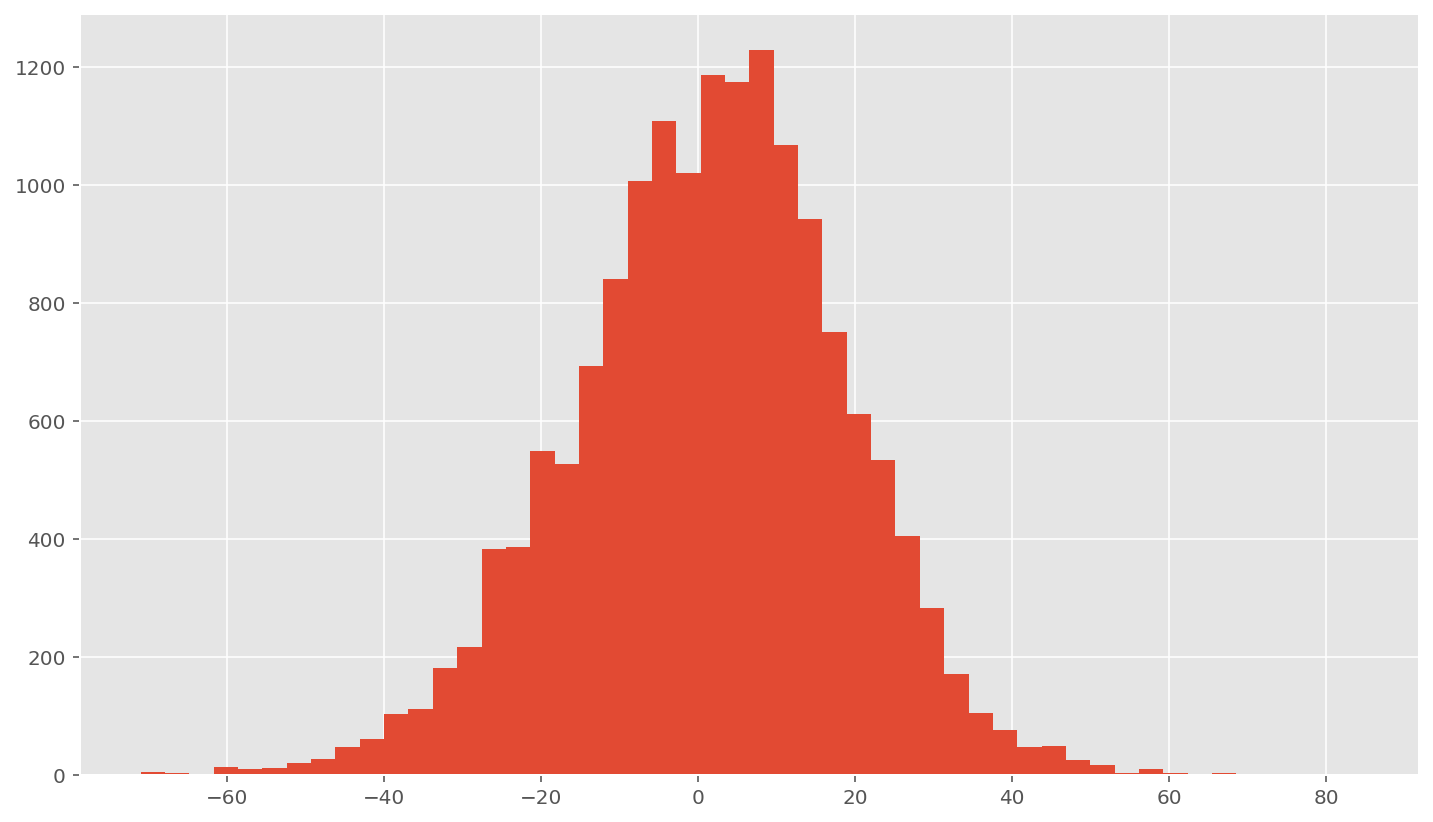

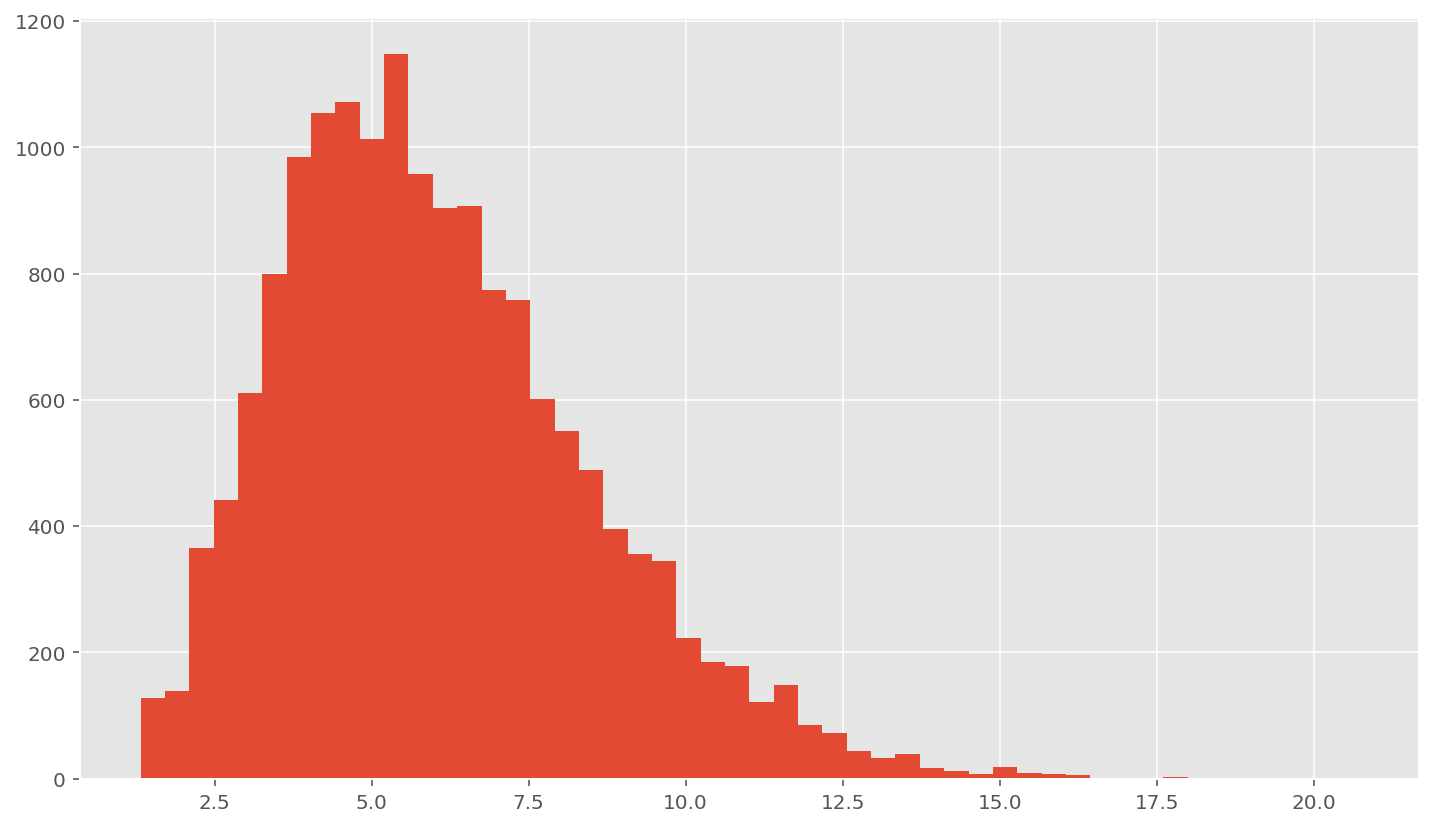

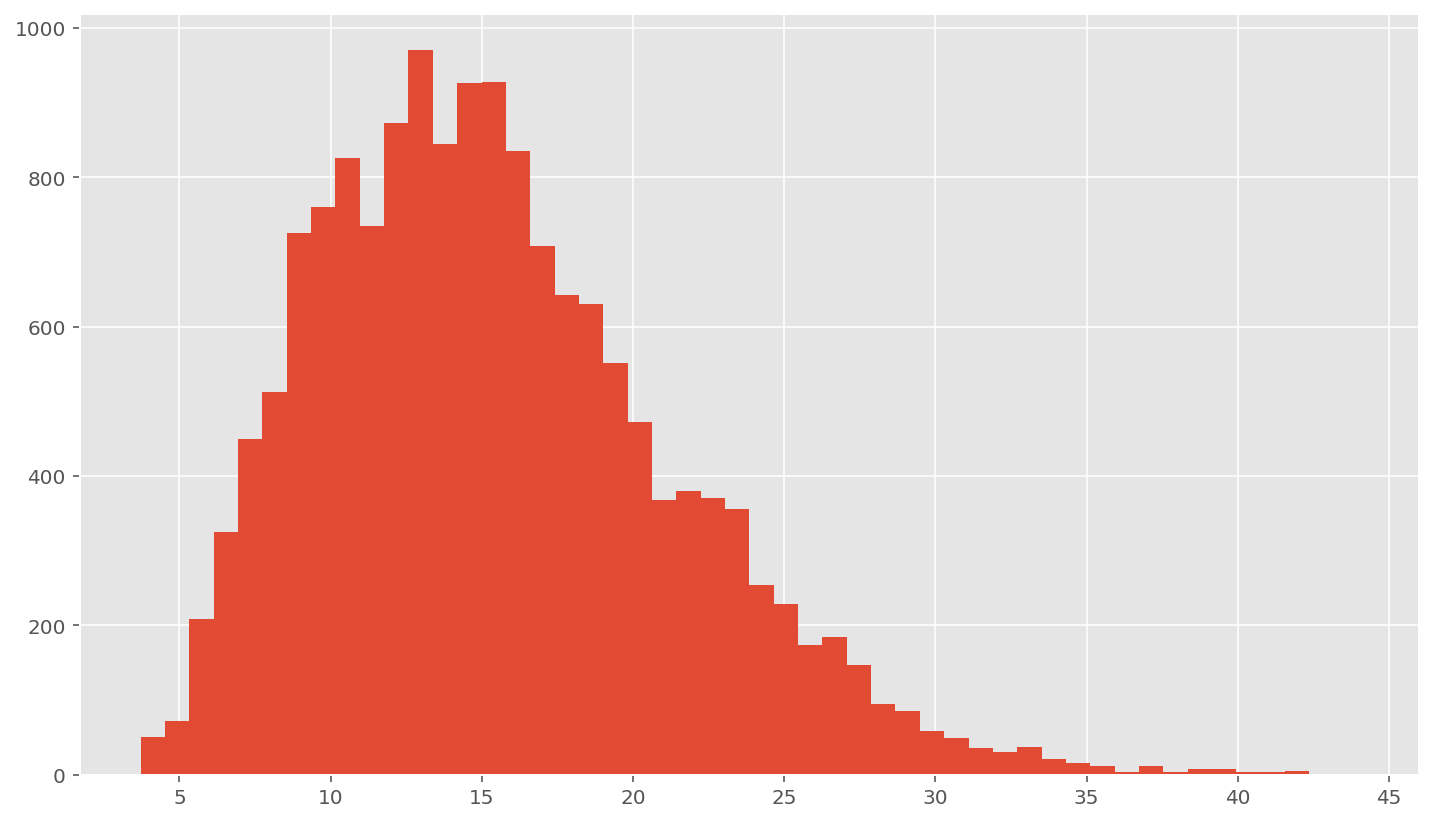

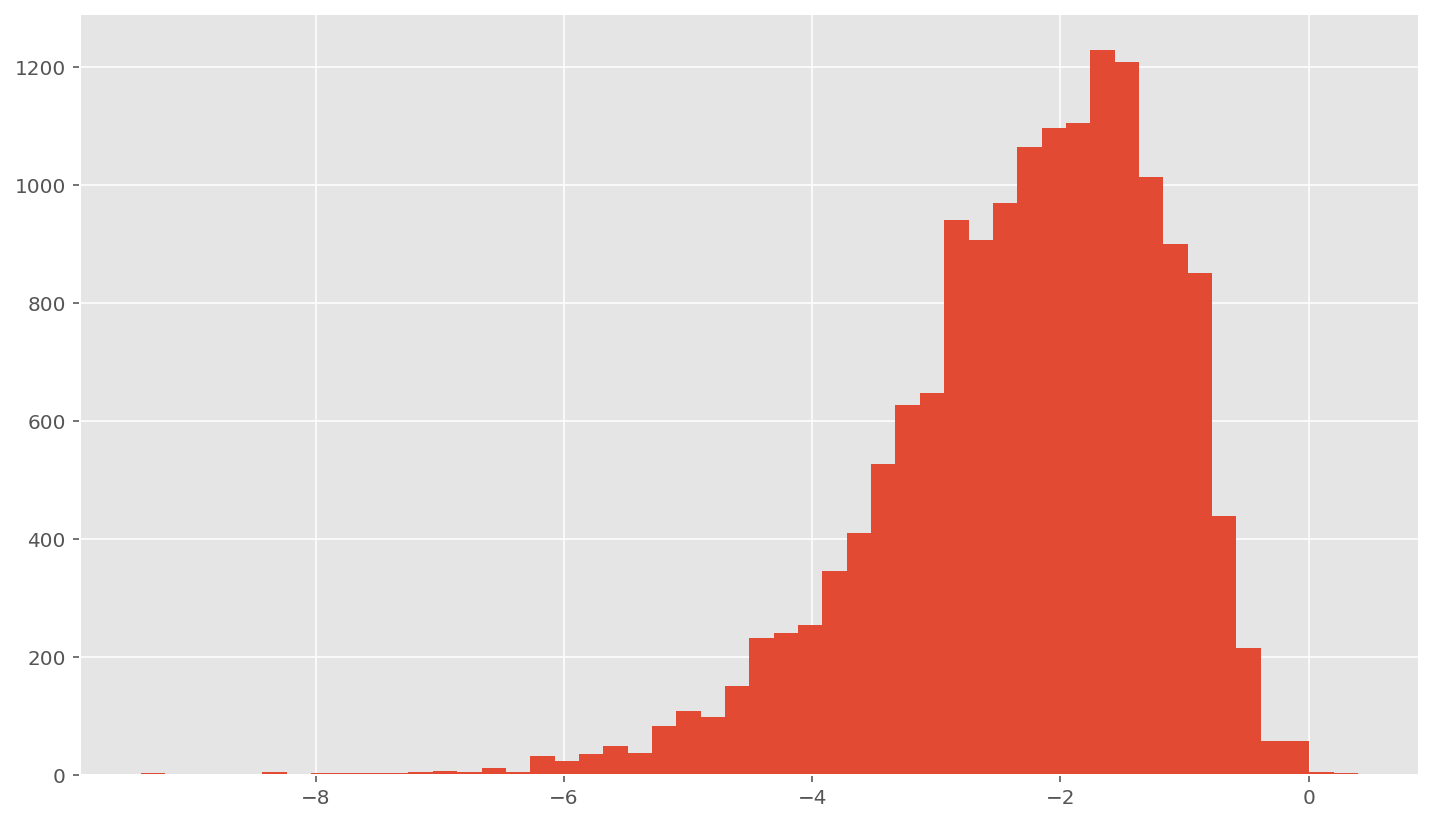

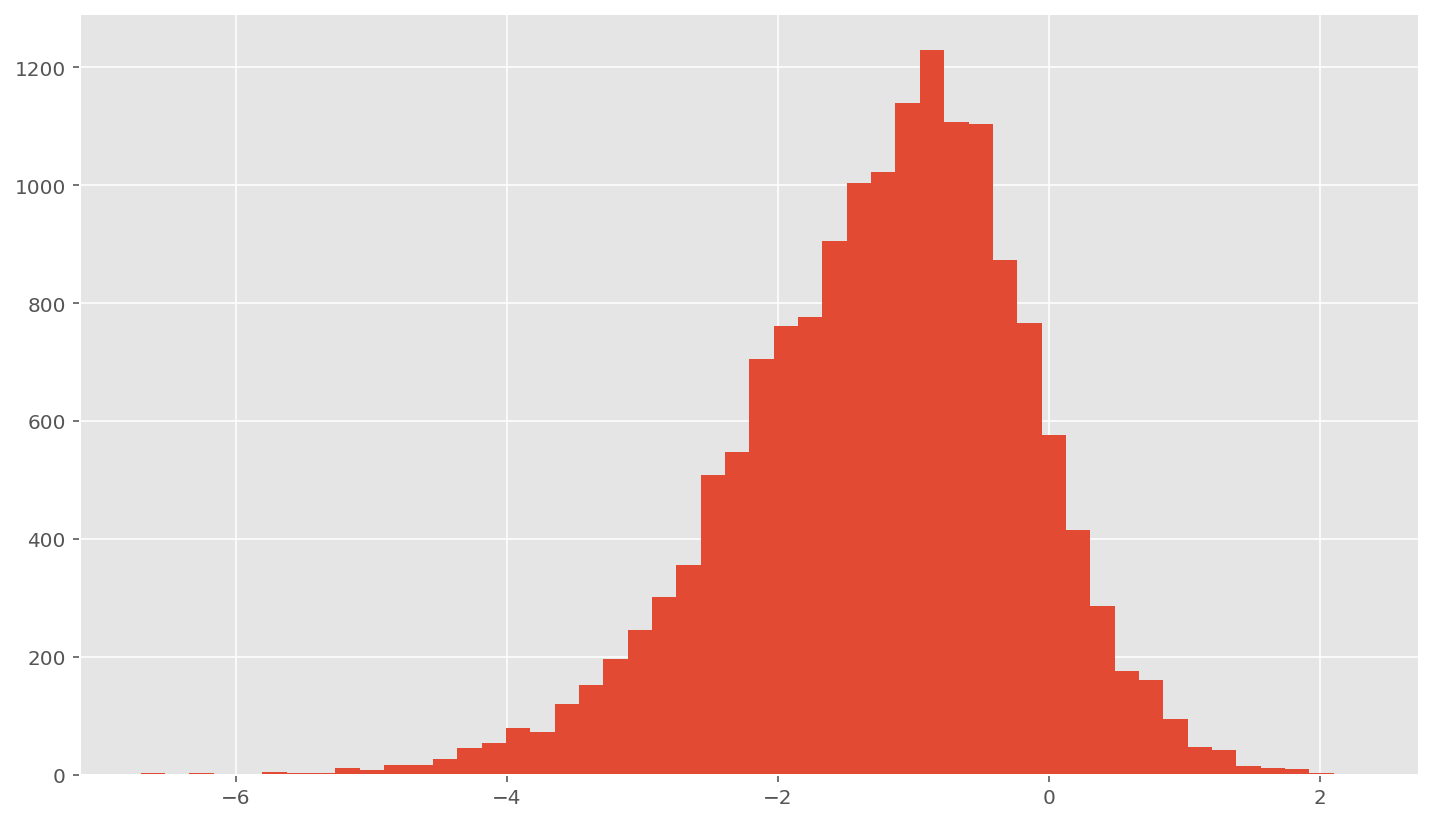

In [29]:
plot_coefs(pf, plots=5)

In [30]:
np.mean(l_auc)

0.8598360655737707

In [31]:
np.std(l_auc)

0.0028378577079404906

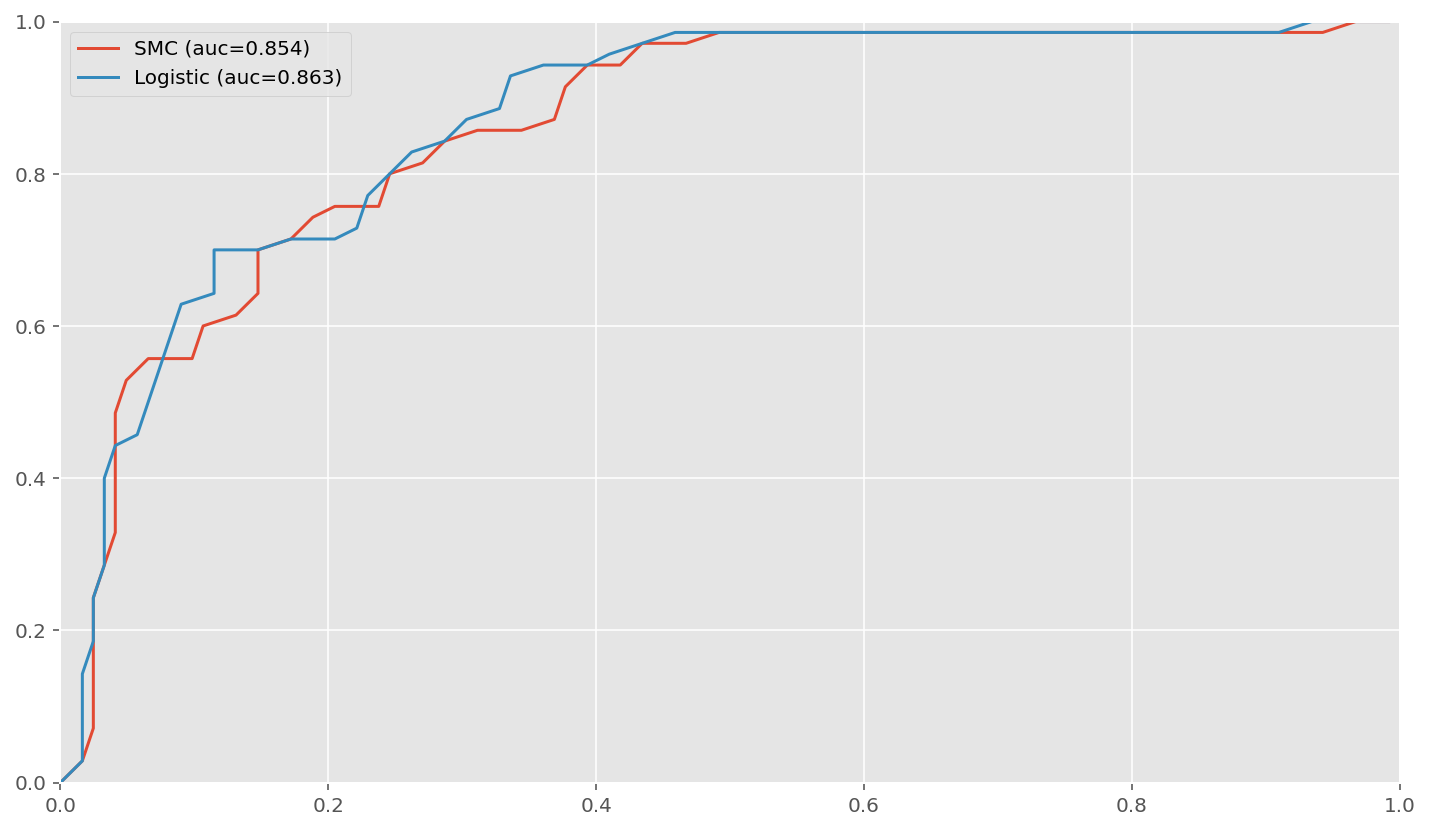

In [32]:
roc_curve_with_logreg(modal_val(pf.X.theta["beta"]), x_test, y_test)

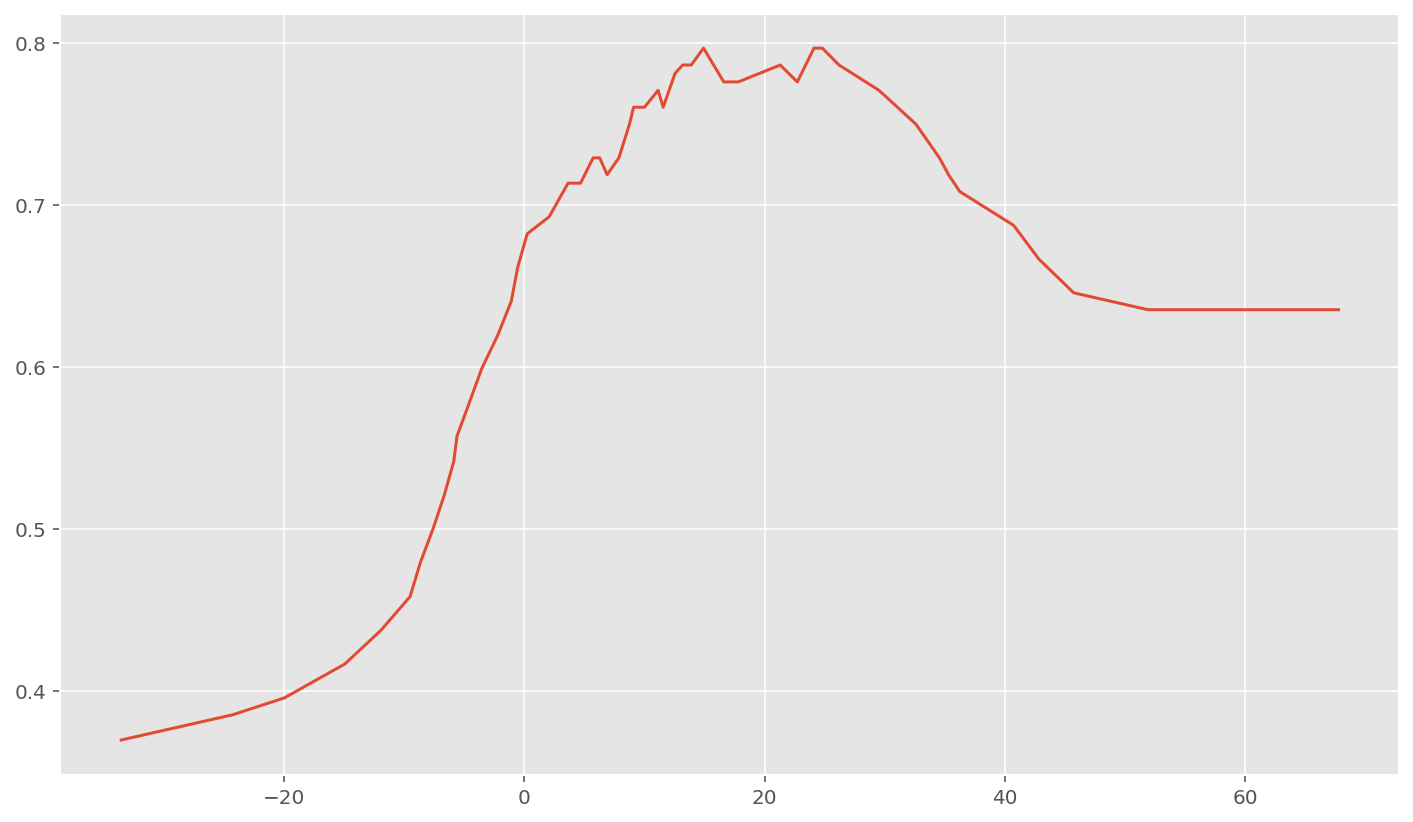

In [33]:
test_acc(modal_val(pf.X.theta["beta"]))

### Sonar dataset

K = 3
AUC : 0.818, 0.846, 0.698, 0.846, 0.802, 
Mean AUC : 0.802
Average run time : 21.13 s
K = 5
AUC : 0.926, 0.892, 0.806, 0.700, 0.781, 
Mean AUC : 0.821
Average run time : 36.08 s
K = 10
AUC : 0.830, 0.838, 0.775, 0.821, 0.808, 
Mean AUC : 0.814
Average run time : 90.12 s
K = 20
AUC : 0.832, 0.873, 0.796, 0.775, 0.825, 
Mean AUC : 0.820
Average run time : 216.37 s
K = 30
AUC : 0.838, 0.871, 0.844, 0.821, 0.810, 
Mean AUC : 0.837
Average run time : 420.38 s
K = 50
AUC : 0.00 (error), 0.00 (error), 0.00 (error), 0.00 (error), 0.00 (error), 
Mean AUC : 0.000
Average run time : 2014.99 s
Highest mean AUC obtained for K = 30


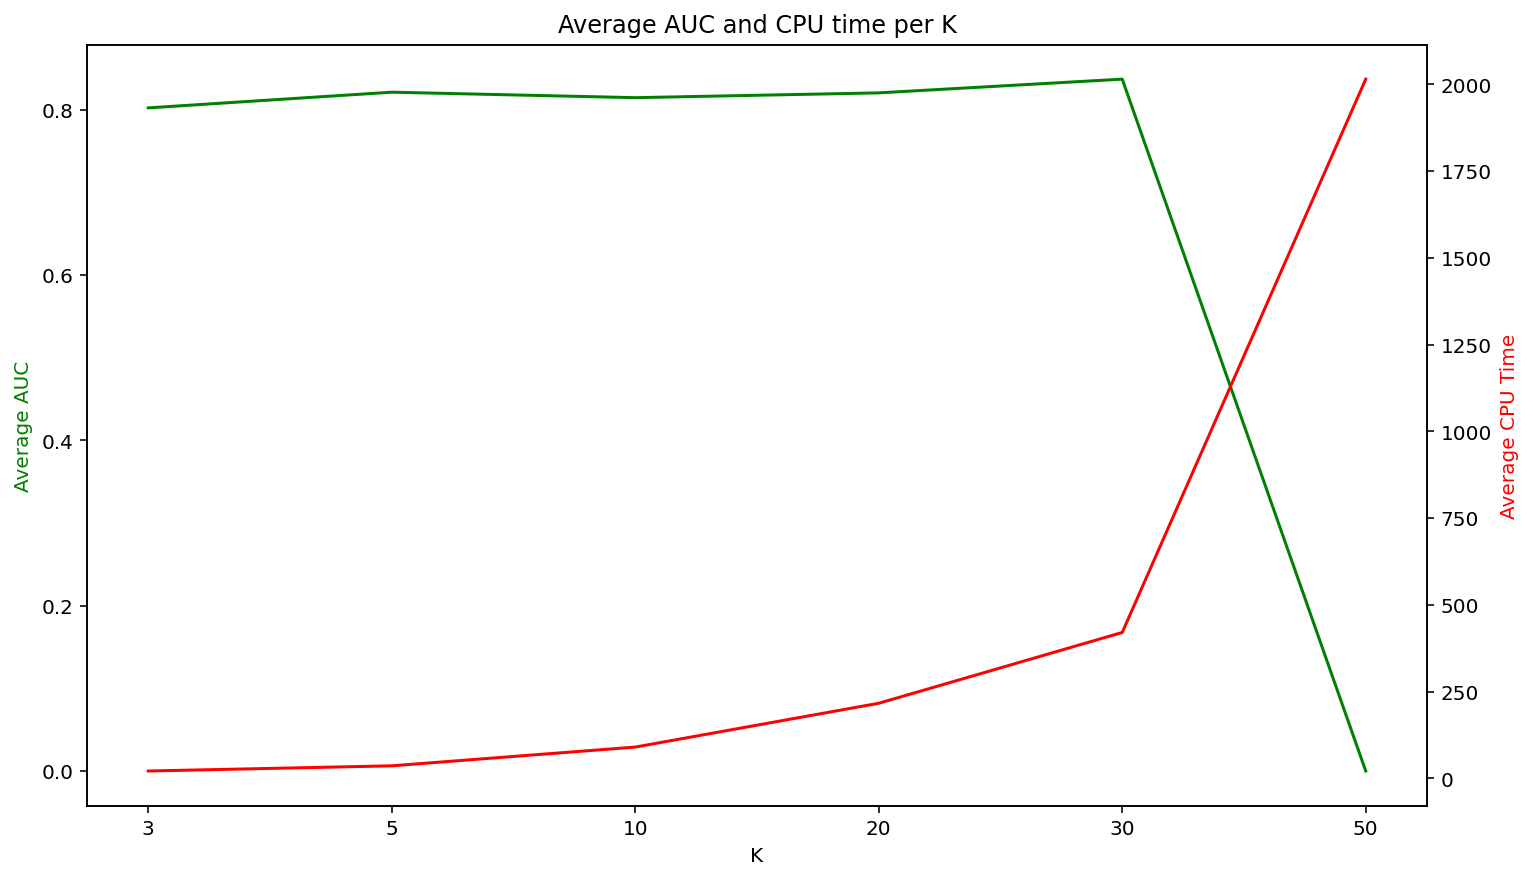

In [22]:
# Optimizing hyperparameters sonar dataset
Ks=[3,5,10,20,30,50]
Xis = [1.]
Ns = [5000]
lambdas = [5000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

Xi = 0.1
AUC : 0.875, 0.875, 0.717, 0.798, 0.863, 
Mean AUC : 0.825
Average run time : 291.83 s
Xi = 1.0
AUC : 0.887, 0.887, 0.758, 0.819, 0.808, 
Mean AUC : 0.832
Average run time : 294.81 s
Xi = 5
AUC : 0.865, 0.863, 0.815, 0.819, 0.821, 
Mean AUC : 0.836
Average run time : 281.26 s
Xi = 10
AUC : 0.877, 0.881, 0.829, 0.810, 0.852, 
Mean AUC : 0.850
Average run time : 290.50 s
Xi = 50
AUC : 0.875, 0.867, 0.738, 0.794, 0.796, 
Mean AUC : 0.814
Average run time : 303.99 s
Highest mean AUC obtained for Xi = 10


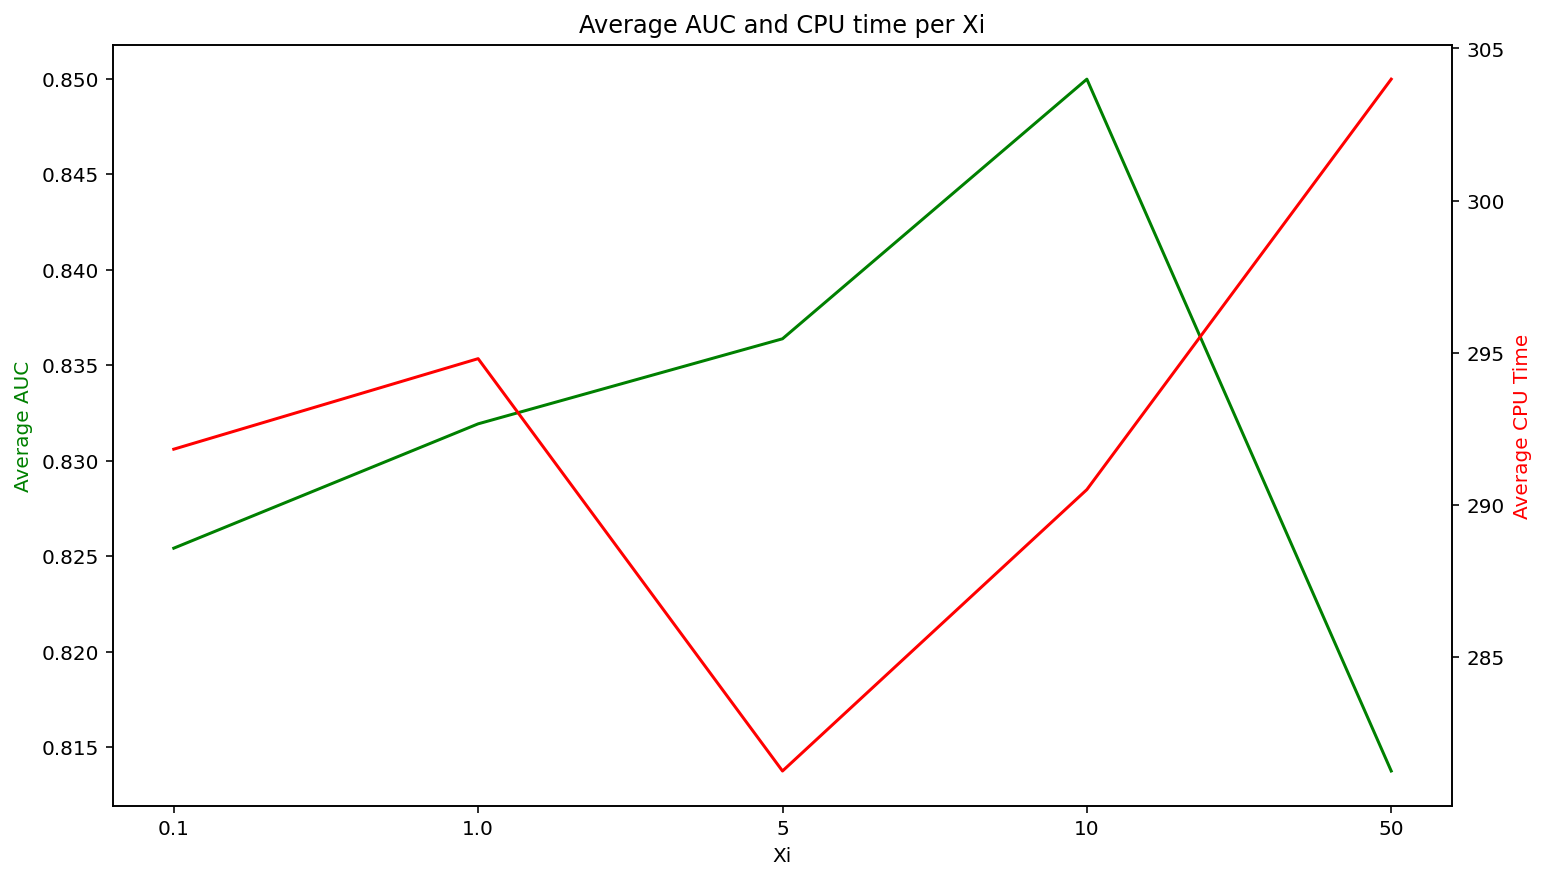

In [23]:
Ks=[30]
Xis = [0.1,1.,5,10,50]
Ns = [5000]
lambdas = [5000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

N = 1000
AUC : 0.861, 0.883, 0.794, 0.785, 0.846, 
Mean AUC : 0.834
Average run time : 108.60 s
N = 2500
AUC : 0.828, 0.900, 0.840, 0.823, 0.788, 
Mean AUC : 0.836
Average run time : 190.20 s
N = 5000
AUC : 0.881, 0.850, 0.800, 0.788, 0.840, 
Mean AUC : 0.832
Average run time : 295.36 s
N = 10000
AUC : 0.881, 0.865, 0.781, 0.794, 0.806, 
Mean AUC : 0.825
Average run time : 482.83 s
Highest mean AUC obtained for N = 2500


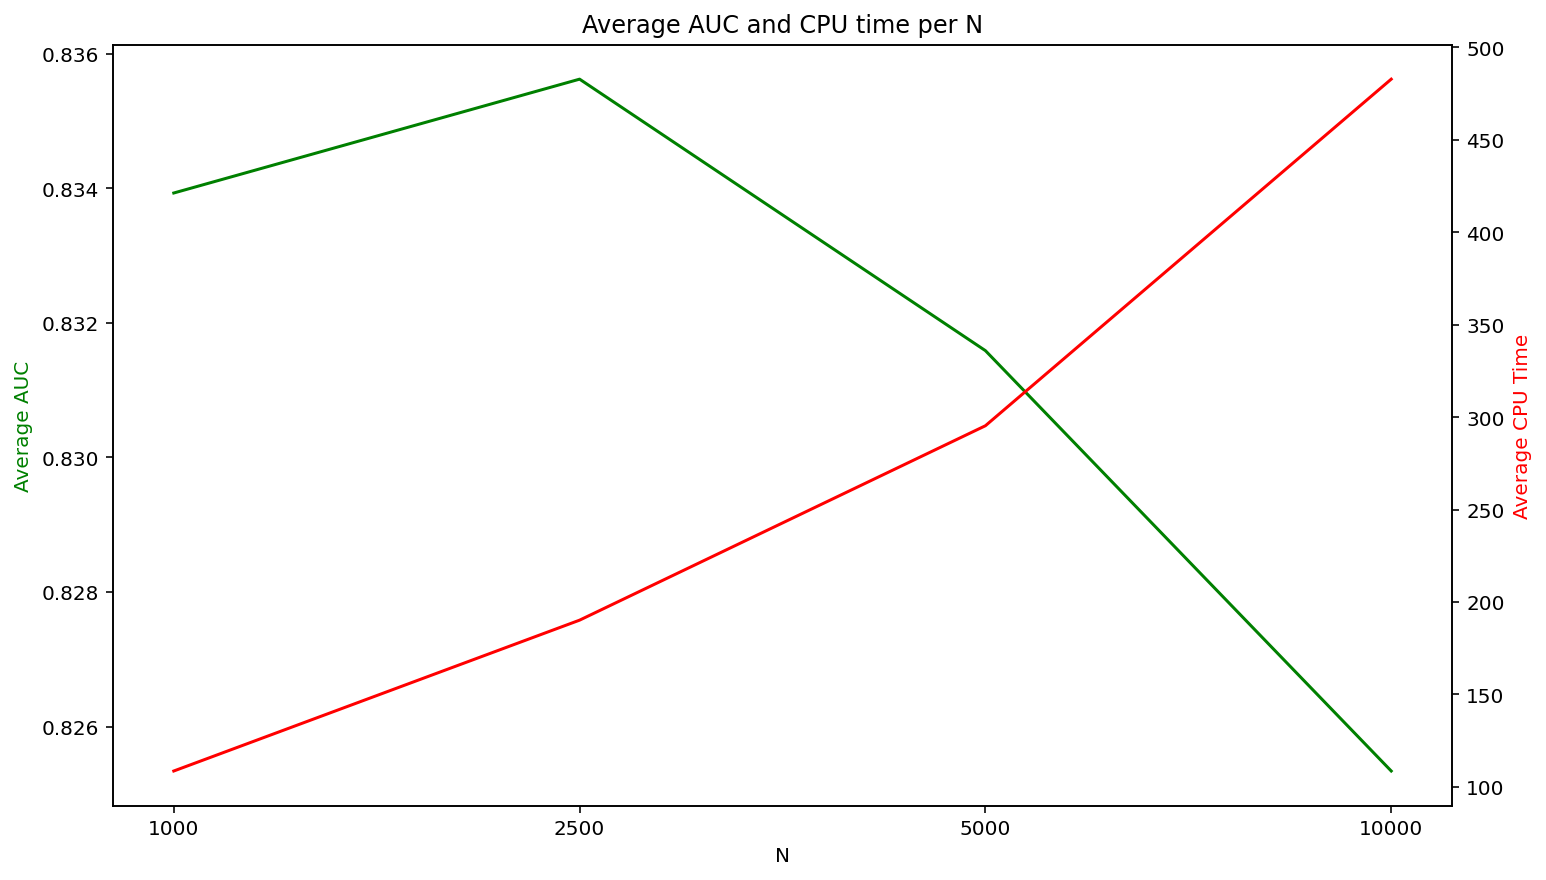

In [27]:
Ks=[30]
Xis = [10.]
Ns = [1000, 2500, 5000, 10000]
lambdas = [5000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

lambda = 1000
AUC : 0.850, 0.885, 0.750, 0.777, 0.796, 
Mean AUC : 0.812
Average run time : 323.67 s
lambda = 5000
AUC : 0.881, 0.898, 0.788, 0.775, 0.815, 
Mean AUC : 0.831
Average run time : 194.58 s
lambda = 10000
AUC : 0.838, 0.875, 0.773, 0.802, 0.827, 
Mean AUC : 0.823
Average run time : 186.98 s
lambda = 20000
AUC : 0.910, 0.860, 0.800, 0.777, 0.813, 
Mean AUC : 0.832
Average run time : 185.36 s
lambda = 50000
AUC : 0.855, 0.858, 0.779, 0.840, 0.817, 
Mean AUC : 0.830
Average run time : 192.17 s
Highest mean AUC obtained for lambda = 20000


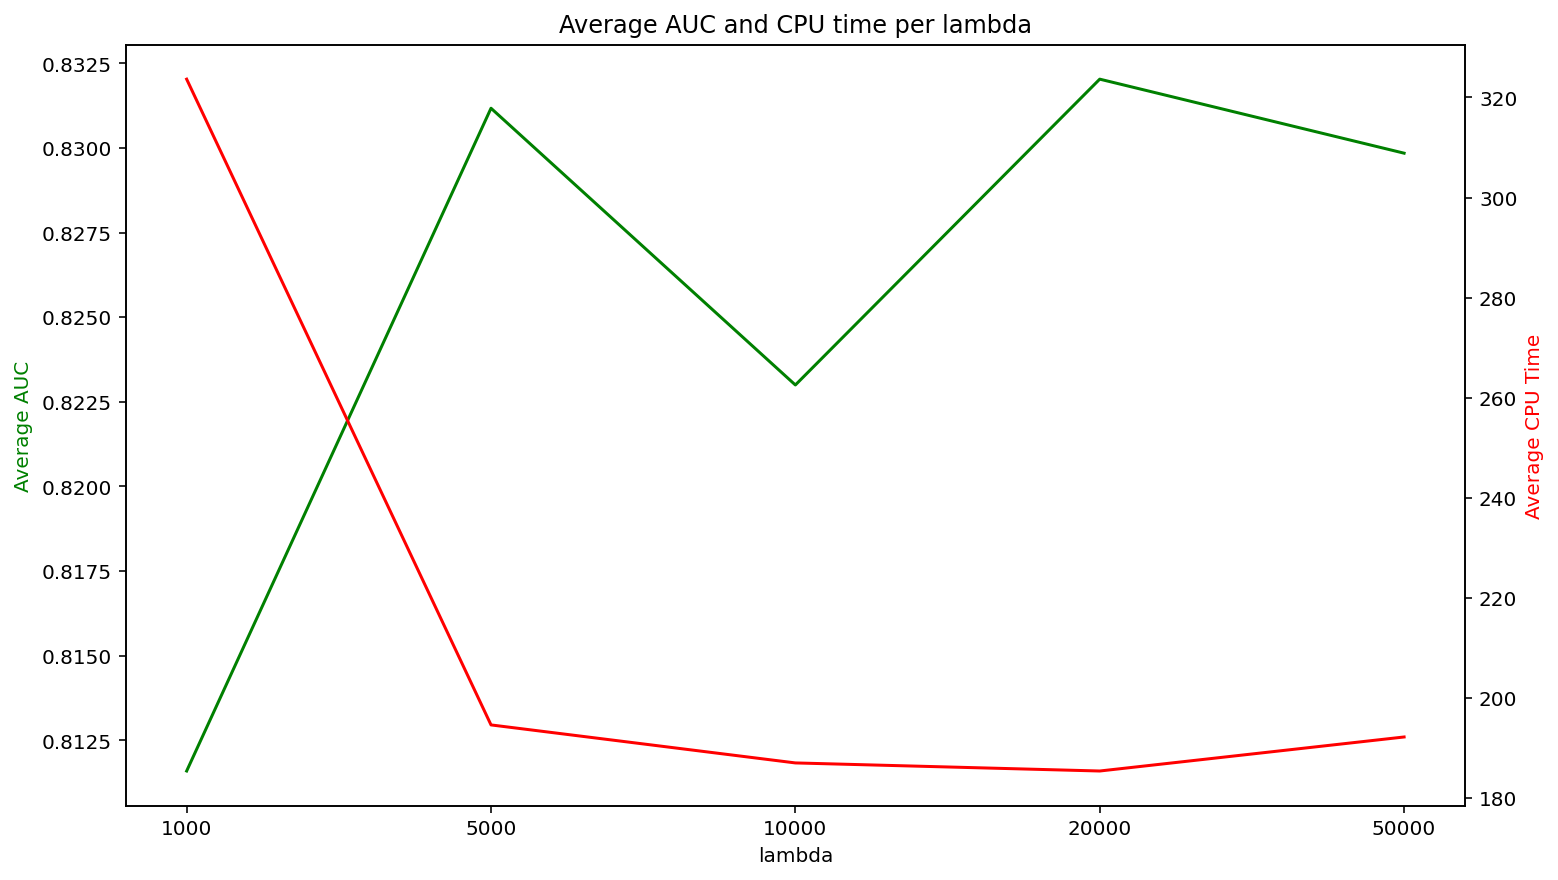

In [28]:
Ks=[30]
Xis = [10.]
Ns = [2500]
lambdas = [1000,5000,10000,20000,50000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

ESSrmin = 0.1
AUC : 0.869, 0.879, 0.775, 0.798, 0.819, 
Mean AUC : 0.828
Average run time : 79.92 s
ESSrmin = 0.3
AUC : 0.926, 0.873, 0.746, 0.771, 0.829, 
Mean AUC : 0.829
Average run time : 132.80 s
ESSrmin = 0.5
AUC : 0.885, 0.873, 0.800, 0.833, 0.863, 
Mean AUC : 0.851
Average run time : 190.54 s
ESSrmin = 0.7
AUC : 0.879, 0.879, 0.779, 0.777, 0.842, 
Mean AUC : 0.831
Average run time : 294.76 s
Highest mean AUC obtained for ESSrmin = 0.5


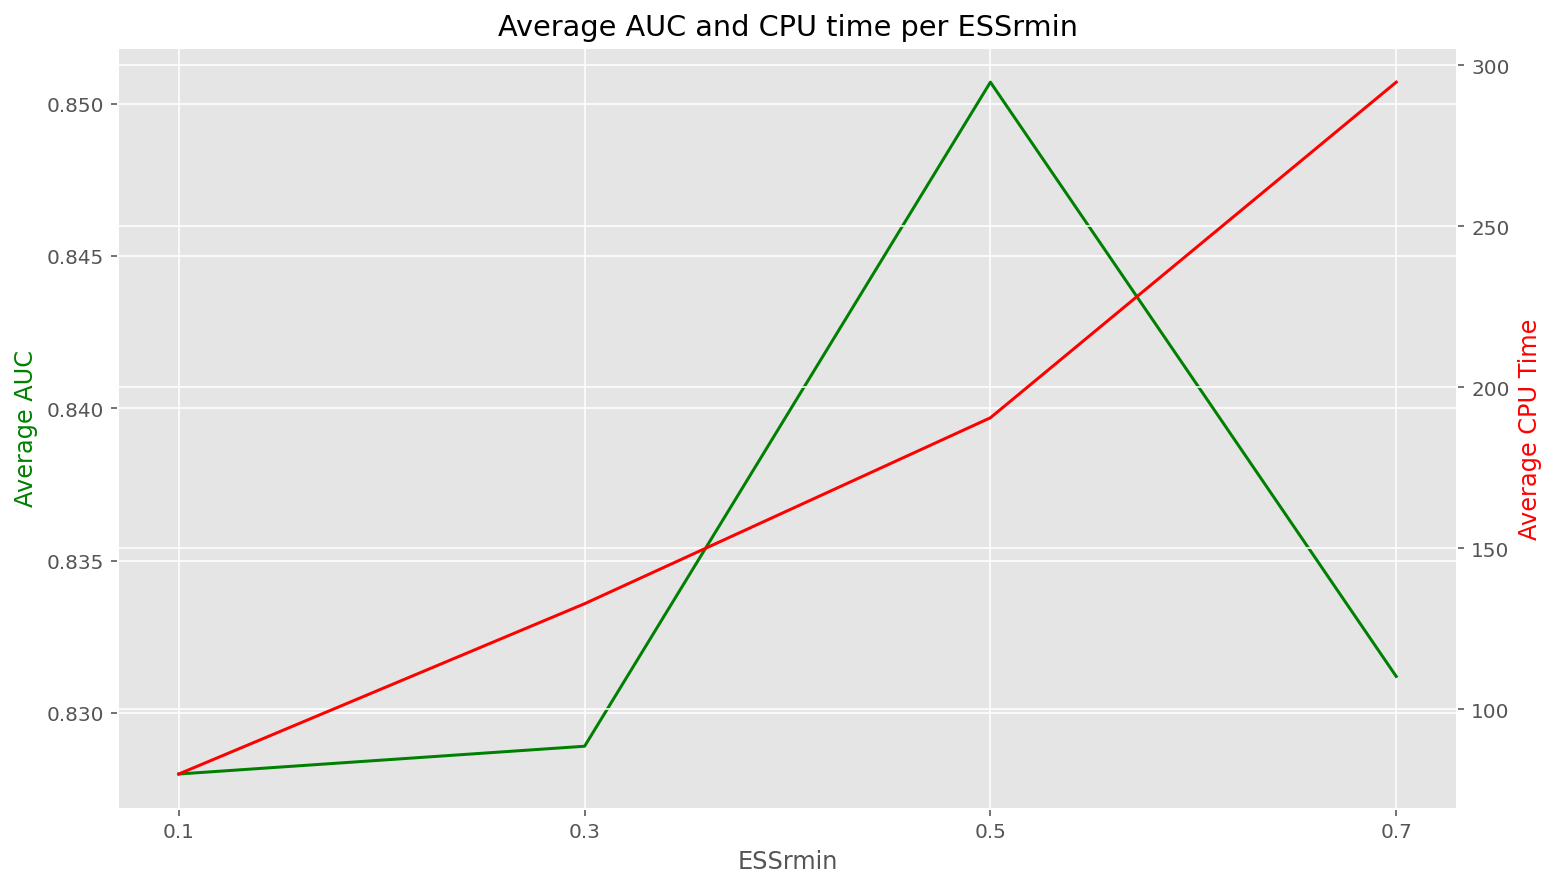

In [15]:
Ks=[30]
Xis = [10.]
Ns = [2500]
lambdas = [20000]
ESSrmins = [0.1, 0.3, 0.5, 0.7]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

K = 25
AUC : 0.887, 0.856, 0.756, 0.827, 0.833, 
Mean AUC : 0.832
Average run time : 150.34 s
K = 30
AUC : 0.893, 0.867, 0.783, 0.788, 0.819, 
Mean AUC : 0.830
Average run time : 181.76 s
K = 35
AUC : 0.869, 0.867, 0.808, 0.788, 0.829, 
Mean AUC : 0.832
Average run time : 227.17 s
K = 40
AUC : 0.881, 0.873, 0.852, 0.779, 0.823, 
Mean AUC : 0.842
Average run time : 272.13 s
Highest mean AUC obtained for K = 40


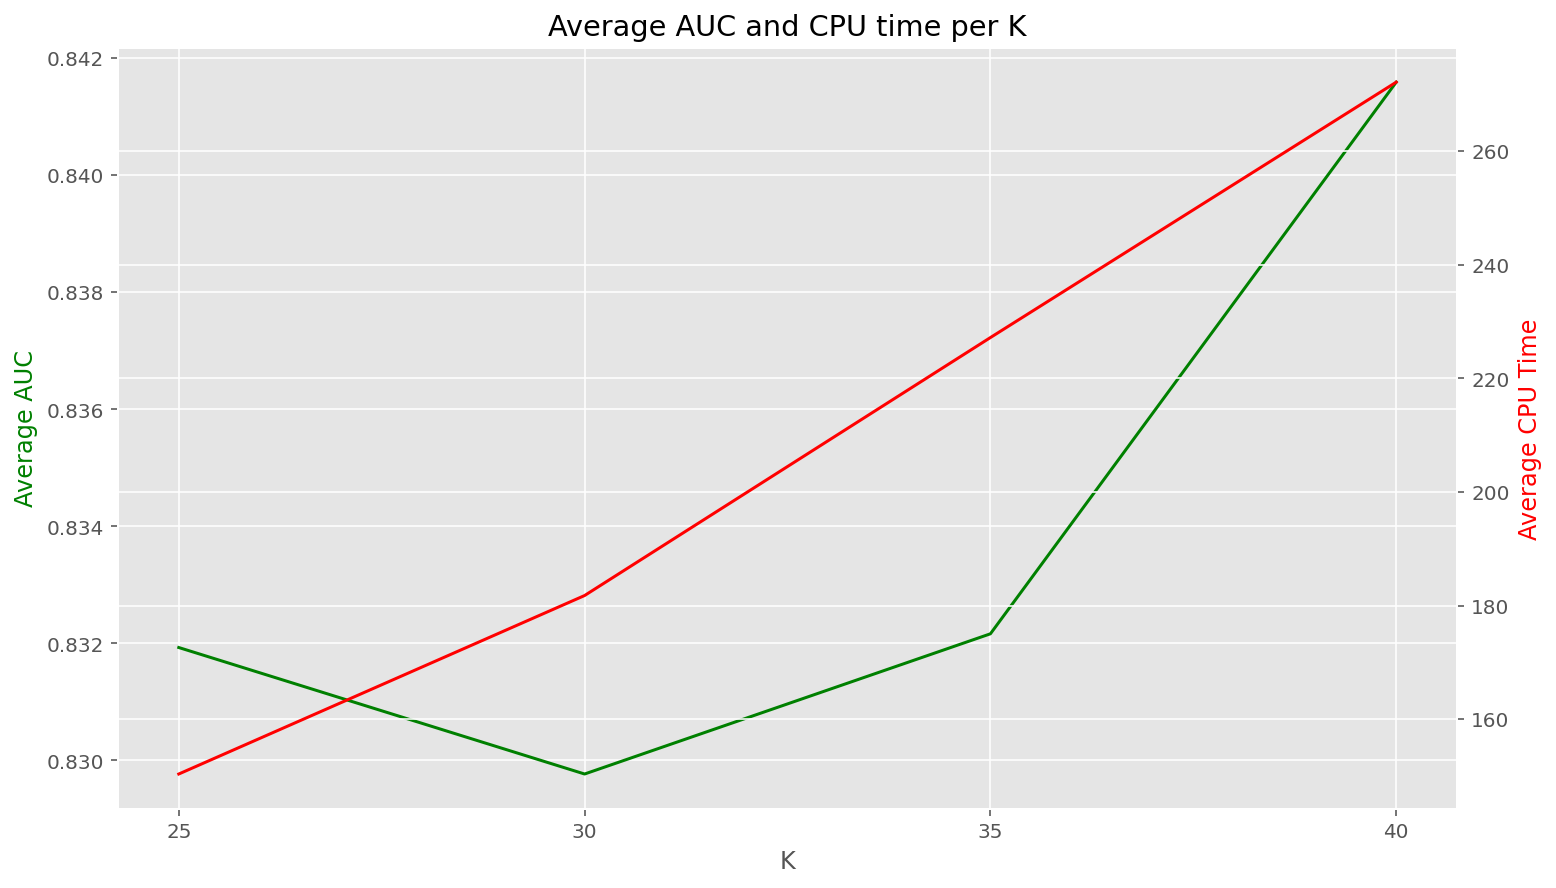

In [16]:
Ks=[25,30,35,40]
Xis = [10.]
Ns = [2500]
lambdas = [20000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

Xi = 5
AUC : 0.898, 0.885, 0.815, 0.815, 0.833, 
Mean AUC : 0.849
Average run time : 328.17 s
Xi = 10.0
AUC : 0.895, 0.869, 0.827, 0.823, 0.881, 
Mean AUC : 0.859
Average run time : 343.36 s
Xi = 15.0
AUC : 0.840, 0.869, 0.00 (error), 0.806, 0.840, 
Mean AUC : 0.671
Average run time : 304.67 s
Xi = 20.0
AUC : 0.867, 0.873, 0.750, 0.817, 0.823, 
Mean AUC : 0.826
Average run time : 332.48 s
Highest mean AUC obtained for Xi = 10.0


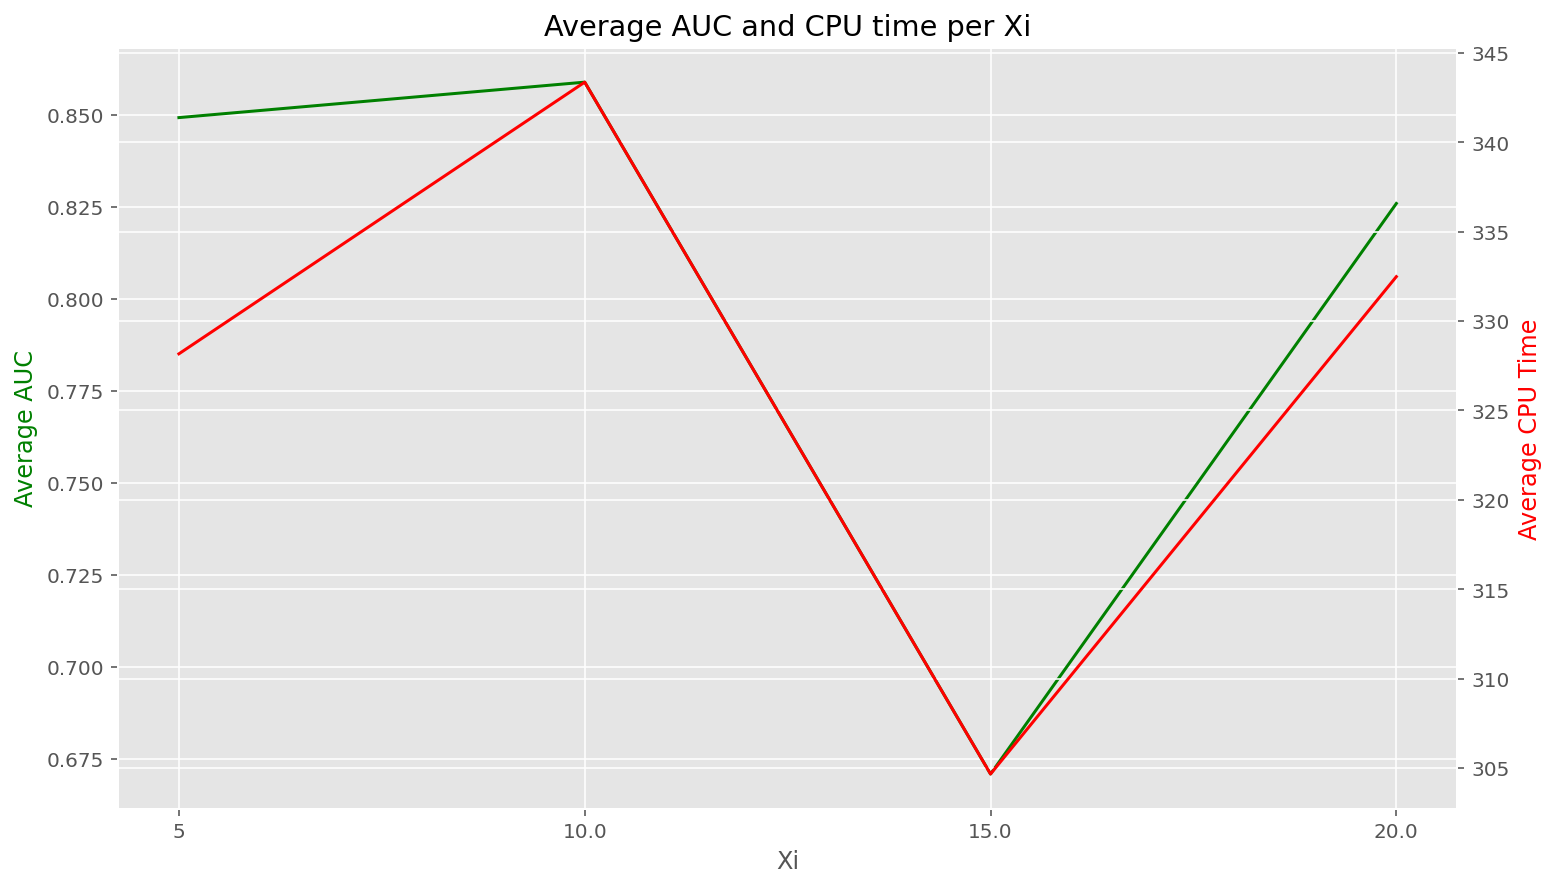

In [13]:
Ks=[40]
Xis = [5, 10., 15., 20.]
Ns = [2500]
lambdas = [20000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

N = 2500
AUC : 0.879, 0.892, 0.808, 0.823, 0.869, 
Mean AUC : 0.854
Average run time : 321.06 s
N = 5000
AUC : 0.873, 0.869, 0.756, 0.827, 0.821, 
Mean AUC : 0.829
Average run time : 481.06 s
N = 10000
AUC : 0.887, 0.869, 0.790, 0.785, 0.844, 
Mean AUC : 0.835
Average run time : 713.68 s
Highest mean AUC obtained for N = 2500


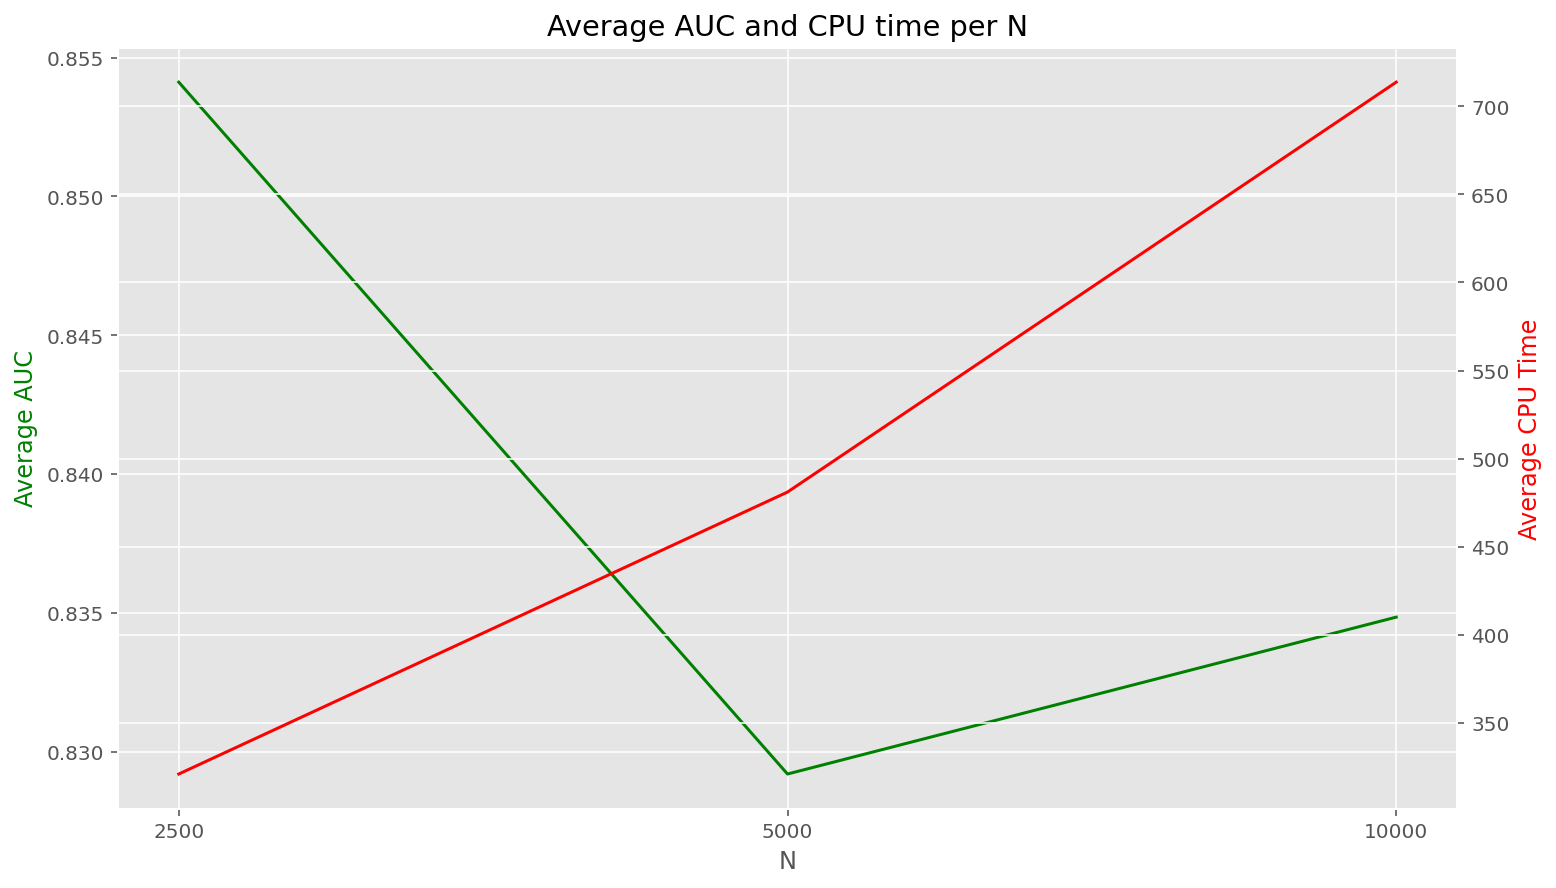

In [14]:
Ks=[40]
Xis = [10.]
Ns = [2500,5000,10000]
lambdas = [20000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

lambda = 10000
AUC : 0.869, 0.869, 0.838, 0.794, 0.740, 
Mean AUC : 0.822
Average run time : 305.03 s
lambda = 20000
AUC : 0.869, 0.860, 0.821, 0.767, 0.854, 
Mean AUC : 0.834
Average run time : 277.55 s
lambda = 30000
AUC : 0.850, 0.850, 0.779, 0.804, 0.817, 
Mean AUC : 0.820
Average run time : 263.01 s
lambda = 50000
AUC : 0.871, 0.860, 0.756, 0.808, 0.833, 
Mean AUC : 0.826
Average run time : 277.97 s
Highest mean AUC obtained for lambda = 20000


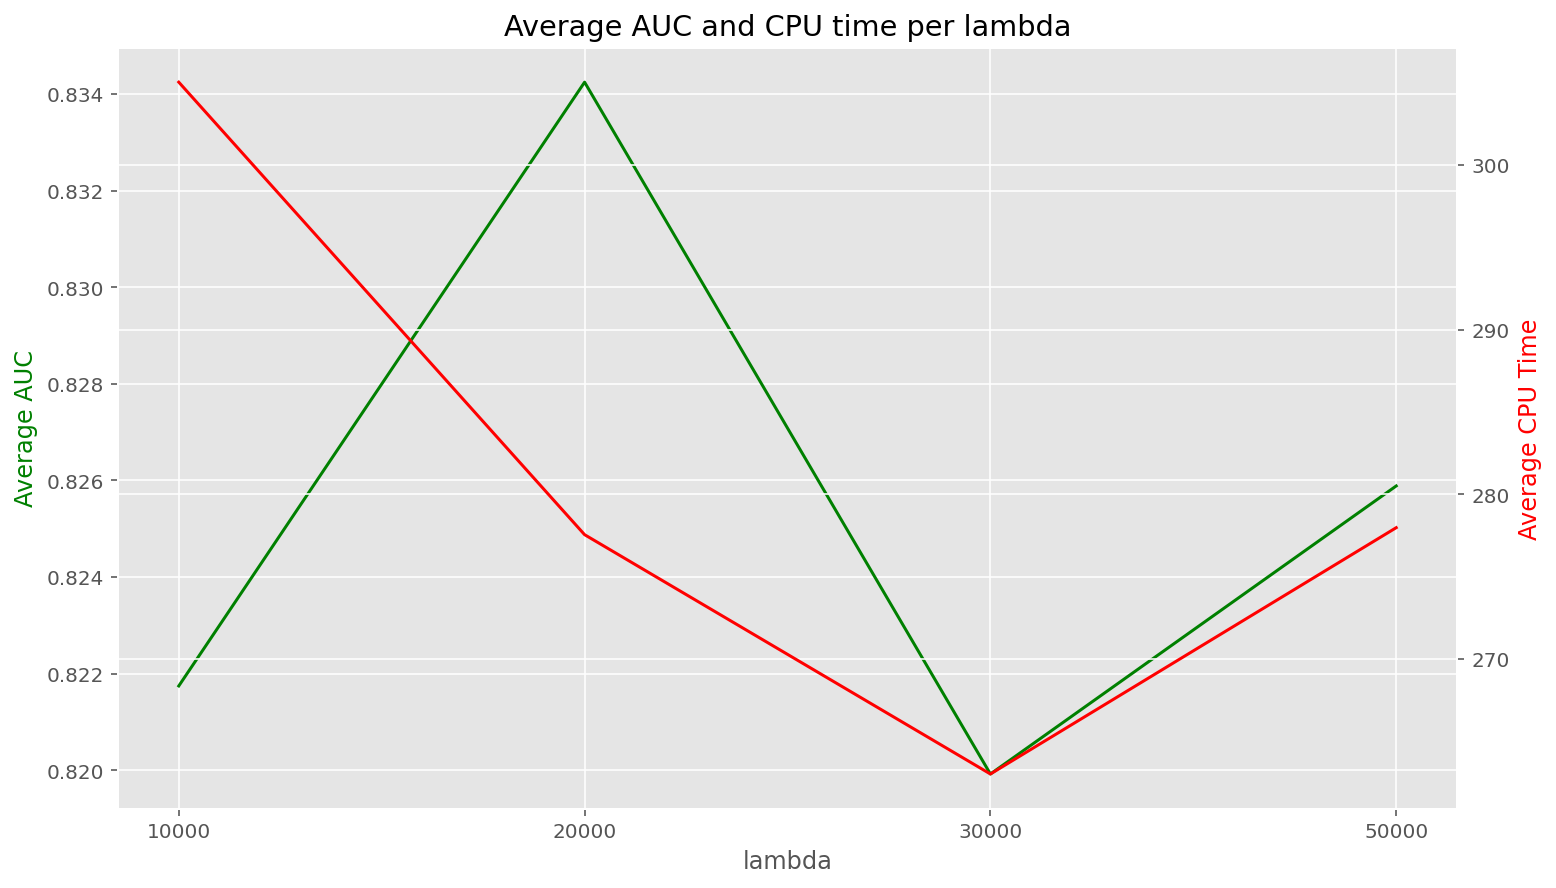

In [12]:
Ks=[40]
Xis = [10.]
Ns = [2500]
lambdas = [10000,20000,30000,50000]
ESSrmins = [0.5]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

ESSrmin = 0.4
AUC : 0.885, 0.892, 0.817, 0.758, 0.798, 
Mean AUC : 0.830
Average run time : 233.07 s
ESSrmin = 0.5
AUC : 0.850, 0.869, 0.779, 0.879, 0.742, 
Mean AUC : 0.824
Average run time : 278.99 s
ESSrmin = 0.6
AUC : 0.883, 0.860, 0.00 (error), 0.781, 0.833, 
Mean AUC : 0.672
Average run time : 457.52 s
Highest mean AUC obtained for ESSrmin = 0.4


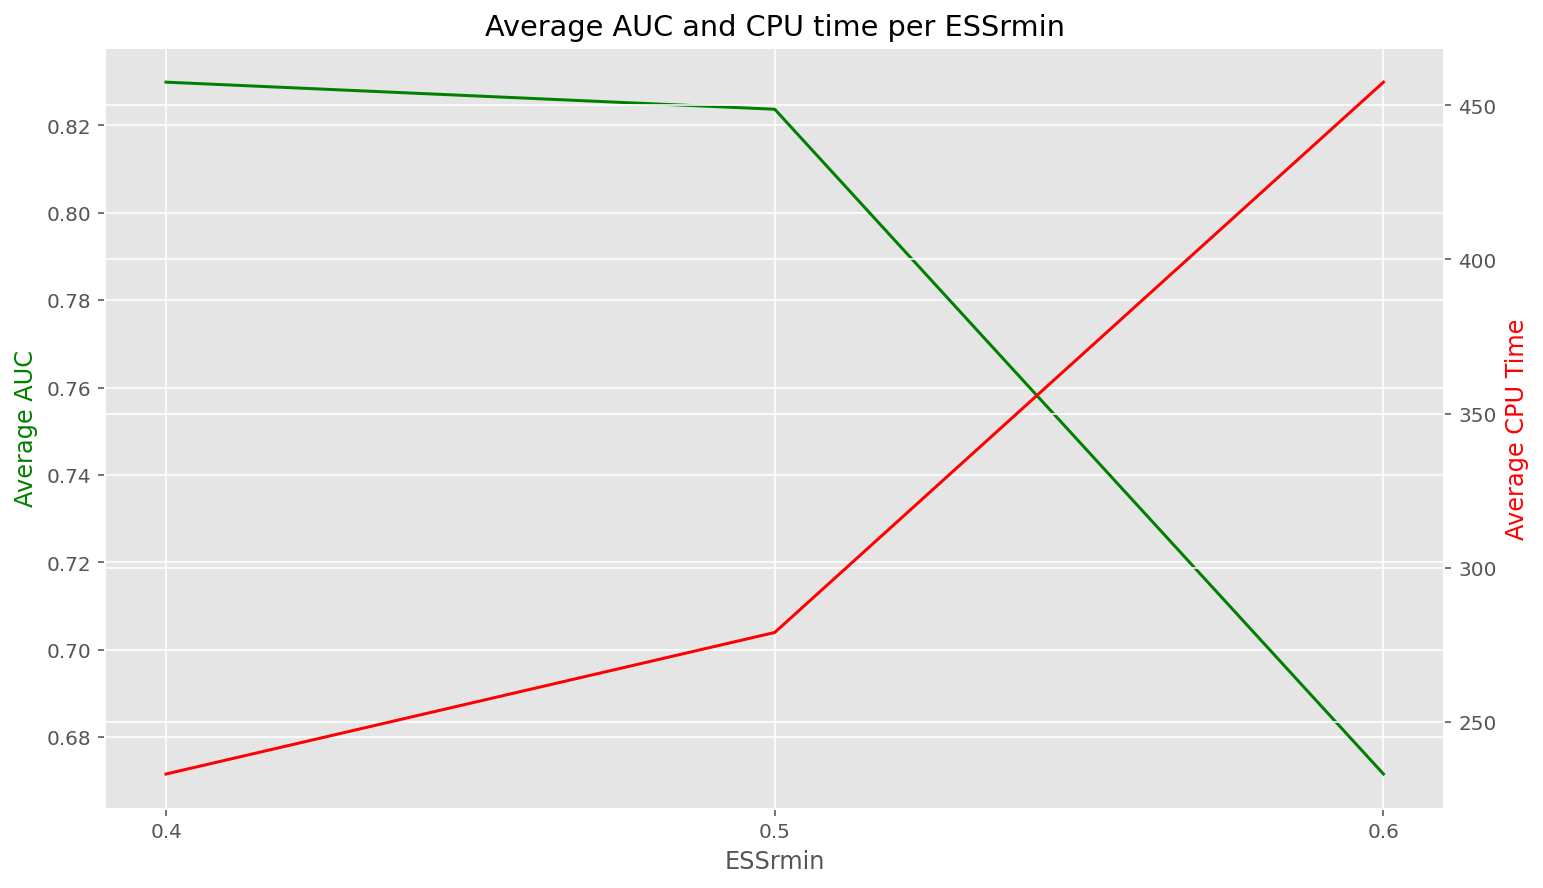

In [13]:
Ks=[40]
Xis = [10.]
Ns = [2500]
lambdas = [20000]
ESSrmins = [0.4,0.5,0.6]
optimize(Ks, lambdas, Xis, Ns, ESSrmins)

In [30]:
# For Sonar, we retain the following hyperparameters:
K = 40
Xi = 10.
N = 2500
lamb = 20000
ESSrmin = 0.4

# AUC on test data (10 runs)
prior = dists.StructDist({'beta':dists.MvNormal(scale=Xi, cov=np.eye(d))})
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lamb*risk(theta["beta"], x_train, y_train))
model = PAC_Bayesian_classifier(base_dist=prior)
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
l_auc = [auc(modal_val(pf.X.theta["beta"]), x_test, y_test)]
for i in range(10):
    pf = particles.SMC(N=N, fk=fk, ESSrmin=1., collect=[Moments],verbose=False)
    pf.run()
    l_auc.append(auc(modal_val(pf.X.theta["beta"]), x_test, y_test))

In [31]:
l_auc

[0.7903225806451613,
 0.6543778801843315,
 0.6551459293394779,
 0.6874039938556067,
 0.682795698924731,
 0.6981566820276497,
 0.6904761904761906,
 0.7135176651305682,
 0.707373271889401,
 0.6743471582181261,
 0.7104454685099847]

In [32]:
np.mean(l_auc)

0.6967602290182936

In [33]:
np.std(l_auc)

0.03527681880837772

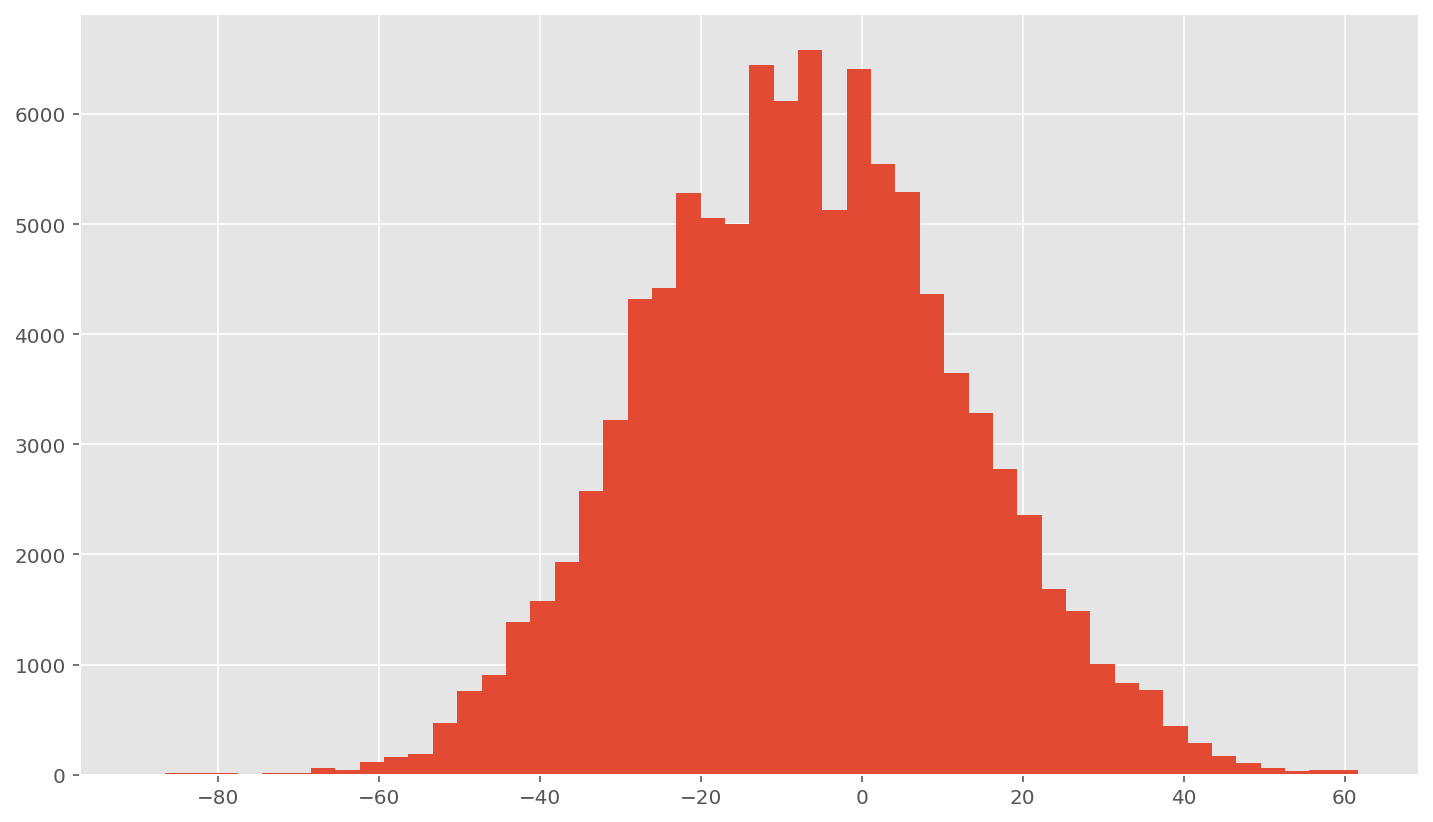

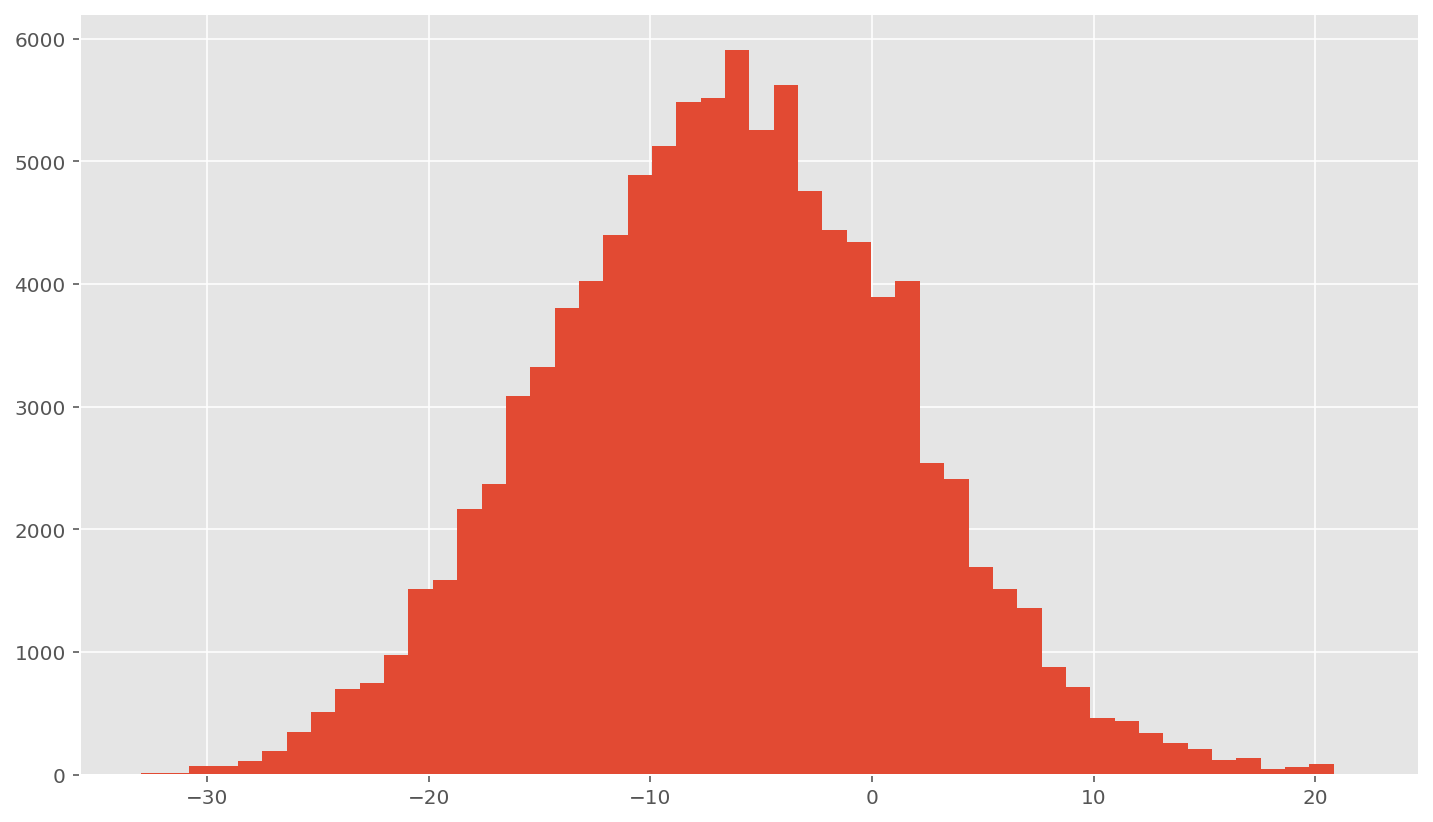

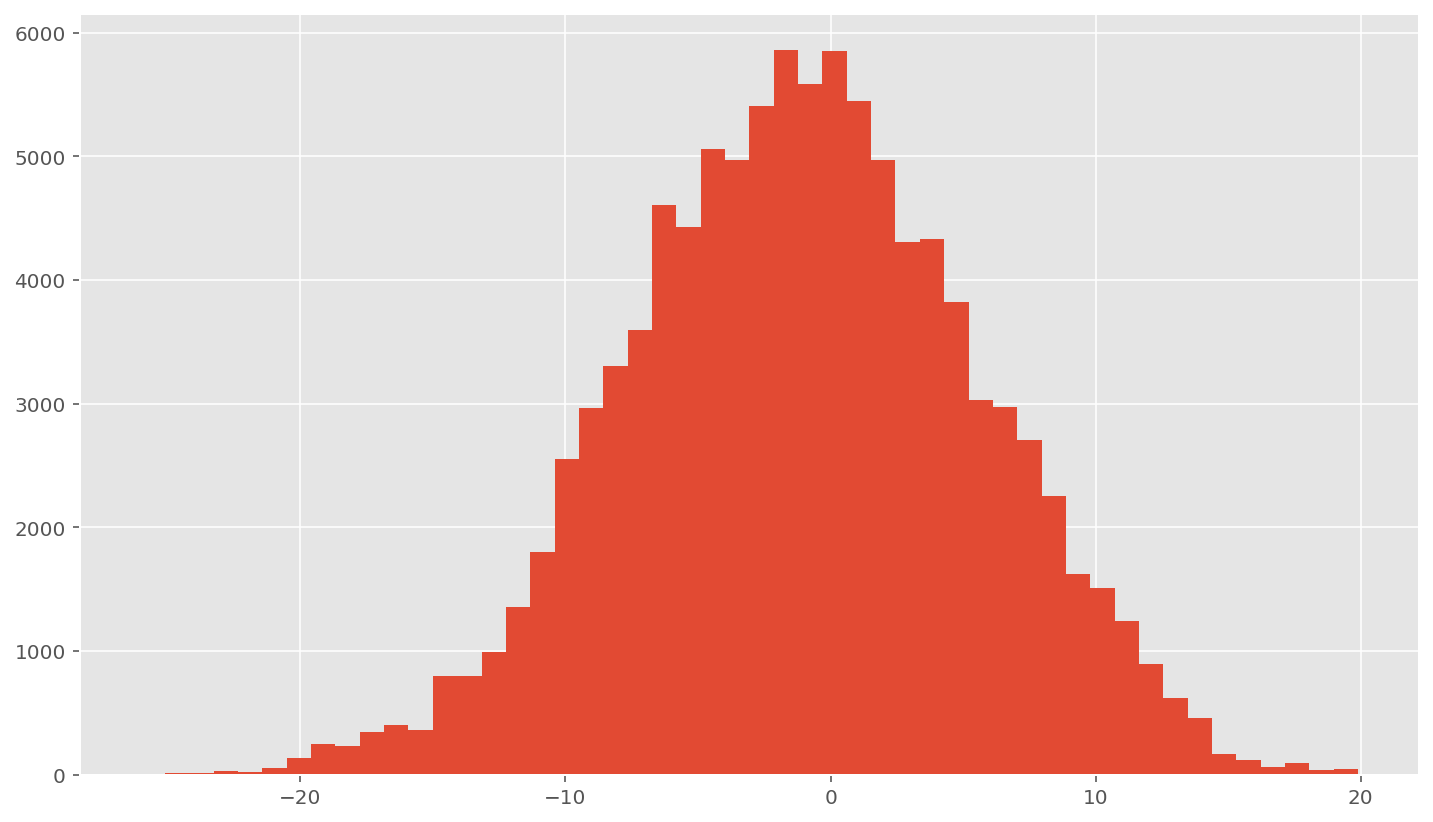

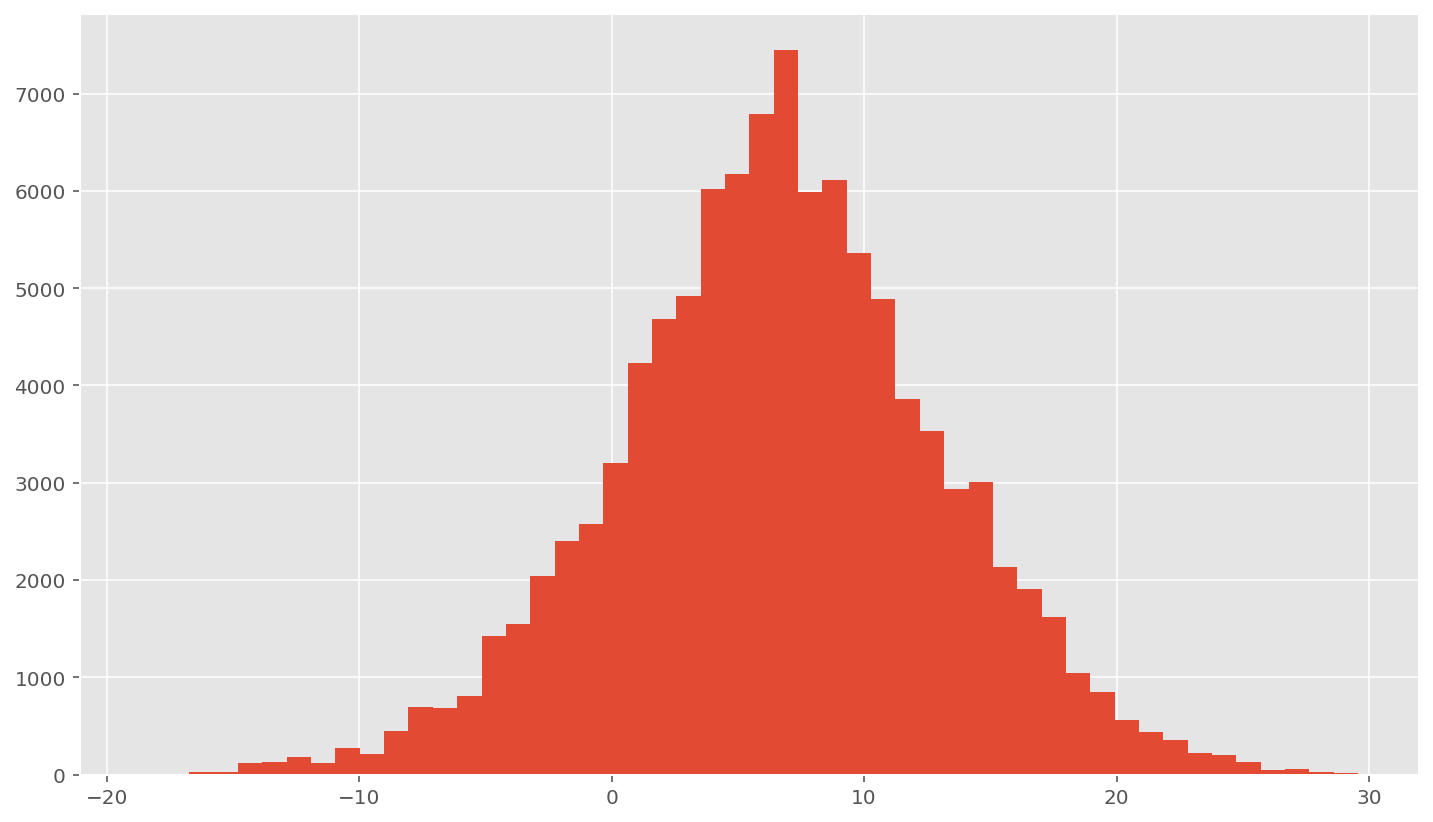

In [34]:
plot_coefs(pf, plots=4)

In [36]:
# logistic regression (test set)
auc( LogisticRegression().fit(x_train,y_train).coef_[0], x_test, y_test)

0.7112135176651306

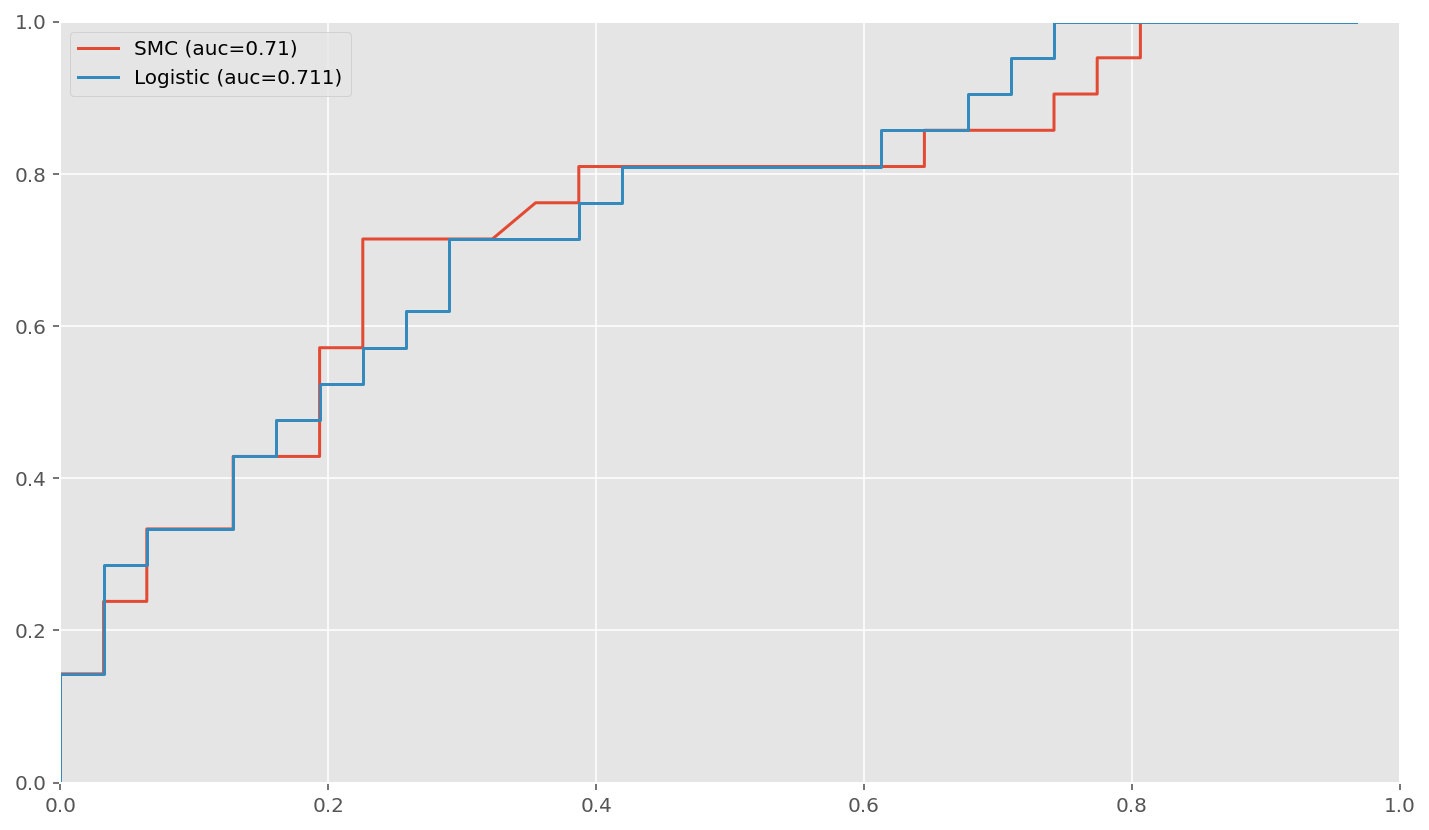

In [53]:
roc_curve_with_logreg(modal_val(pf.X.theta["beta"]), x_test, y_test)

### EEG dataset

K = 2
AUC : 0.612, 0.621, 0.608, 0.619, 0.632, 
Mean AUC : 0.618
Average run time : 178.10 s
K = 3
AUC : 0.623, 0.601, 0.625, 0.625, 0.613, 
Mean AUC : 0.618
Average run time : 306.90 s
K = 5
AUC : 0.622, 0.619, 0.626, 0.622, 0.634, 
Mean AUC : 0.625
Average run time : 498.94 s
Highest mean AUC obtained for K = 5


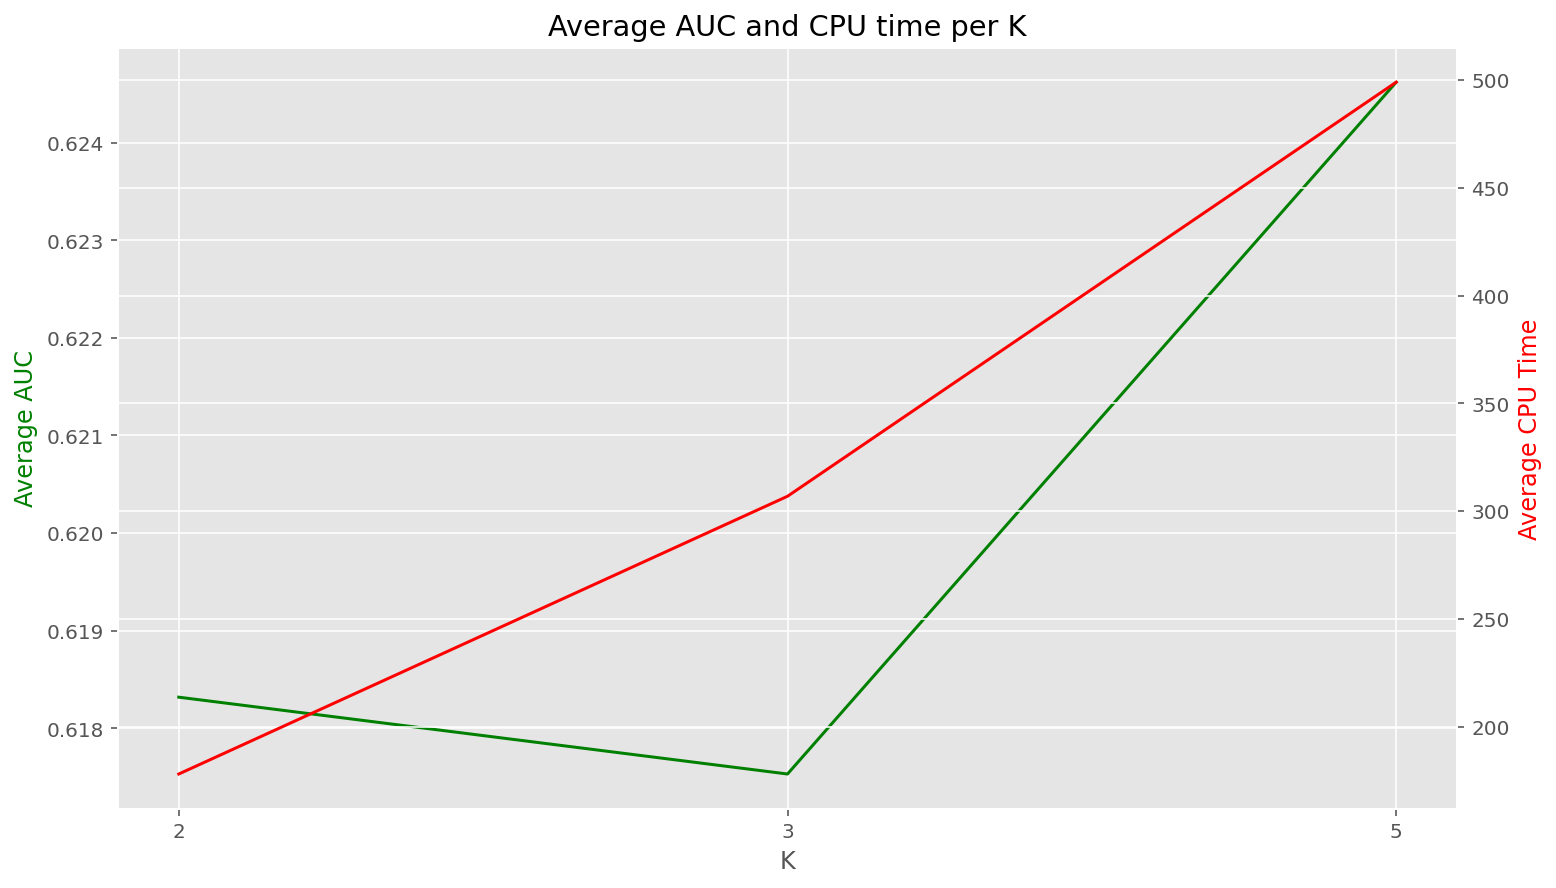

In [13]:
Ks=[2,3,5]
Xis = [1.]
Ns = [100]
lambdas = [10000]
ESSrmins = [0.2]
best_K = optimize(Ks, lambdas, Xis, Ns, ESSrmins)

Xi = 0.2
AUC : 0.634, 0.620, 0.627, 0.620, 0.640, 
Mean AUC : 0.628
Average run time : 528.64 s
Xi = 1.0
AUC : 0.623, 0.618, 0.624, 0.618, 0.643, 
Mean AUC : 0.625
Average run time : 511.64 s
Xi = 5.0
AUC : 0.638, 0.602, 0.620, 0.623, 0.643, 
Mean AUC : 0.625
Average run time : 499.33 s
Highest mean AUC obtained for Xi = 0.2


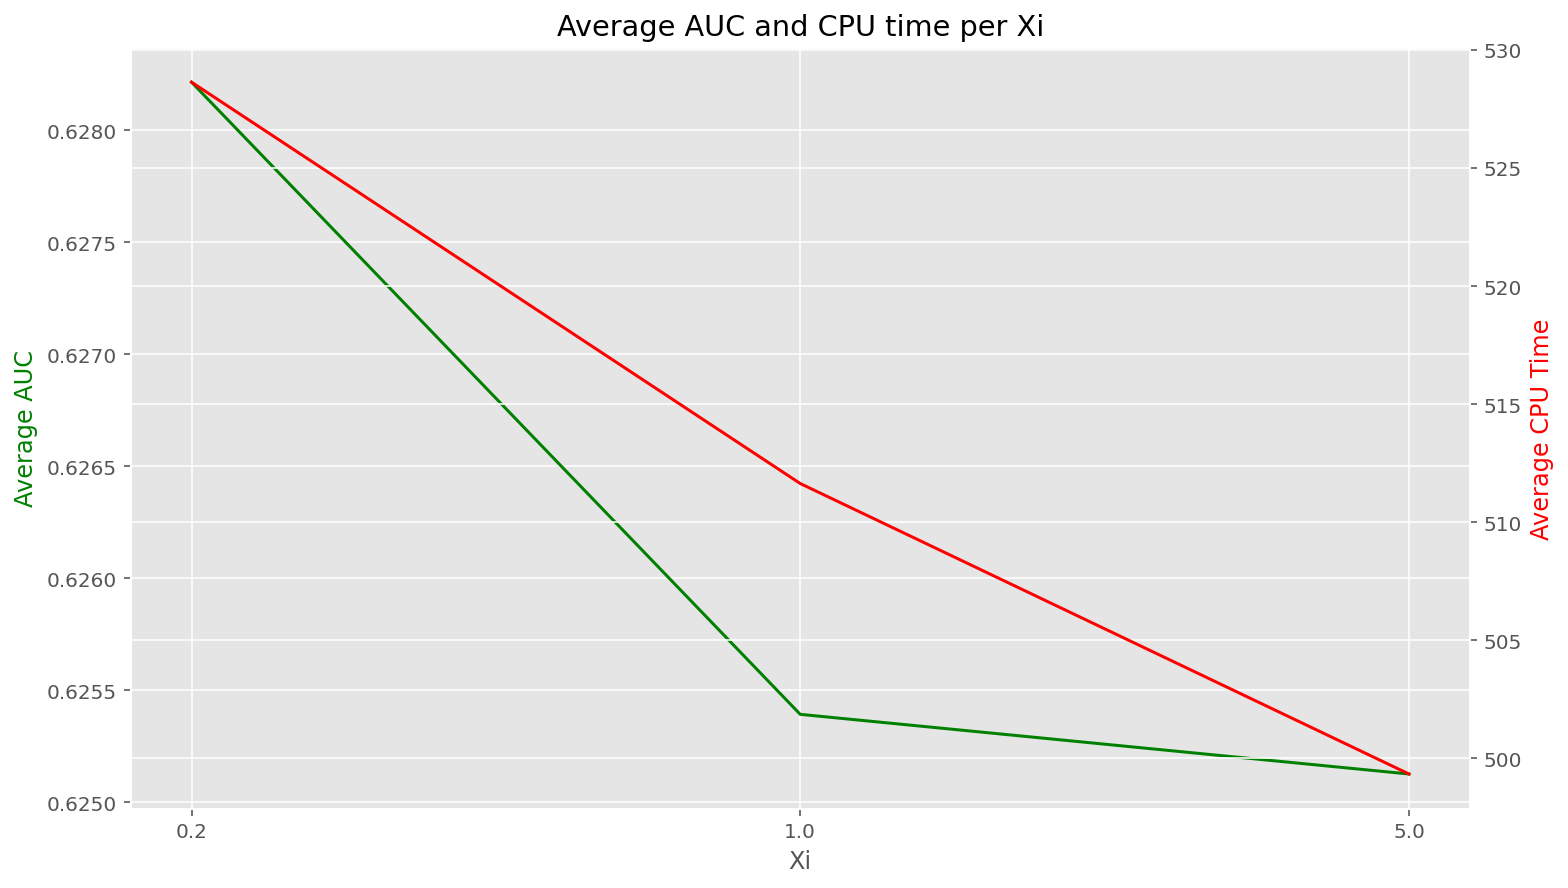

In [14]:
Ks=[5]
Xis = [0.2,1.,5.]
Ns = [100]
lambdas = [10000]
ESSrmins = [0.2]
best_Xi = optimize(Ks, lambdas, Xis, Ns, ESSrmins)

N = 100
AUC : 0.625, 0.621, 0.622, 0.620, 0.640, 
Mean AUC : 0.626
Average run time : 458.96 s
N = 150
AUC : 0.635, 0.614, 0.638, 0.623, 0.642, 
Mean AUC : 0.631
Average run time : 933.99 s
N = 200
AUC : 0.635, 0.620, 0.631, 0.611, 0.630, 
Mean AUC : 0.626
Average run time : 1603.68 s
Highest mean AUC obtained for N = 150


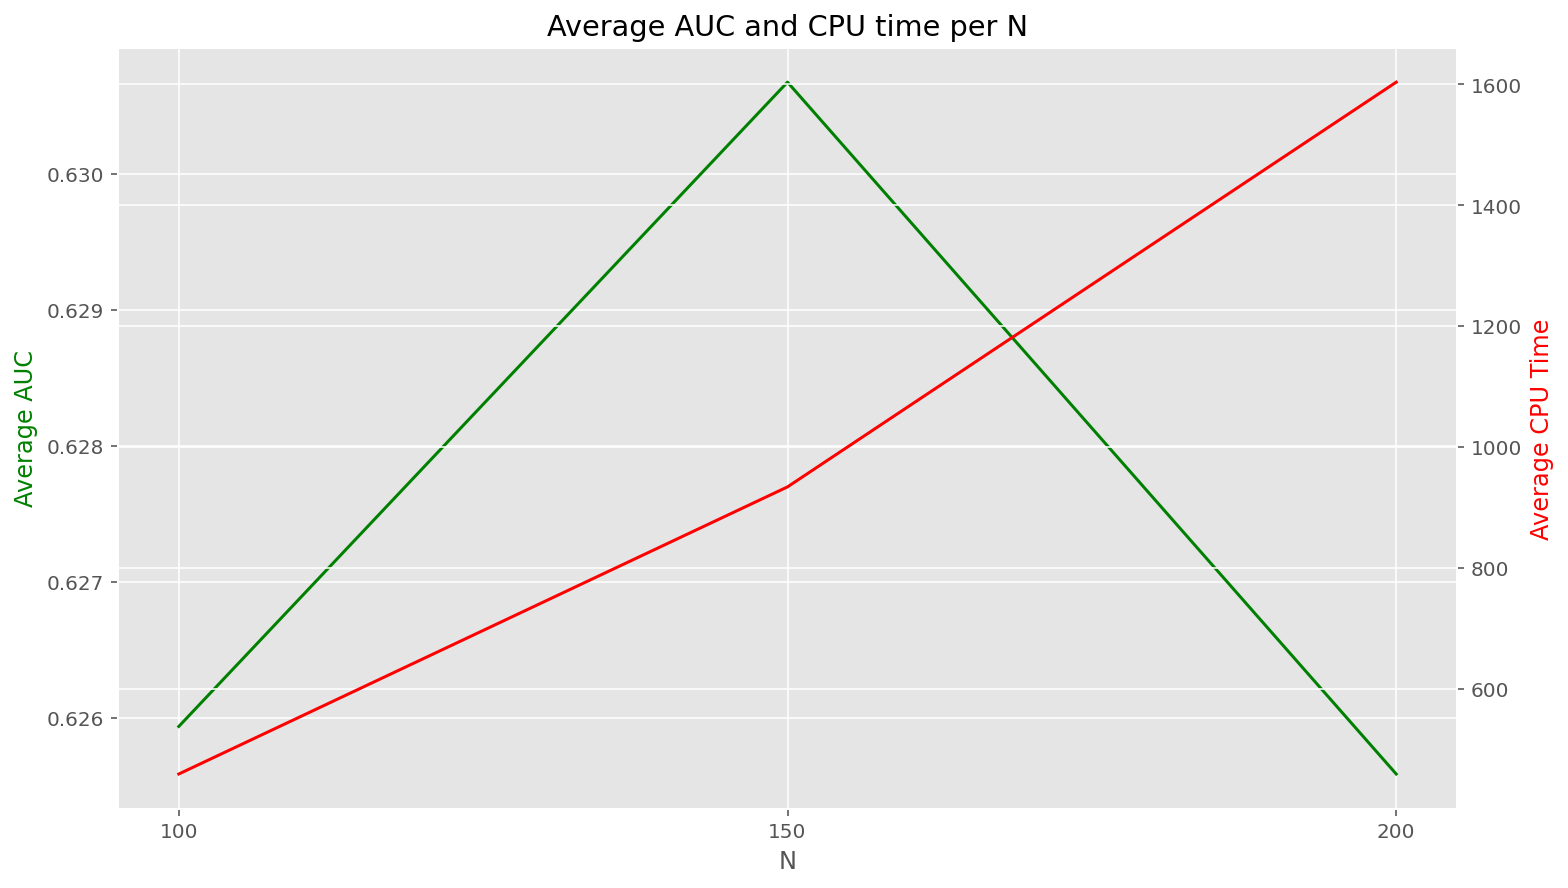

In [14]:
Ks=[5]
Xis = [0.2]
Ns = [100,150,200]
lambdas = [10000]
ESSrmins = [0.2]
best_N = optimize(Ks, lambdas, Xis, Ns, ESSrmins)

lambda = 2000
AUC : 0.599, 0.620, 0.636, 0.595, 0.628, 
Mean AUC : 0.615
Average run time : 753.18 s
lambda = 5000
AUC : 0.634, 0.624, 0.644, 0.617, 0.624, 
Mean AUC : 0.629
Average run time : 851.16 s
lambda = 10000
AUC : 0.626, 0.620, 0.629, 0.625, 0.637, 
Mean AUC : 0.628
Average run time : 922.73 s
lambda = 50000
AUC : 0.637, 0.625, 0.628, 0.624, 0.641, 
Mean AUC : 0.631
Average run time : 1189.38 s
Highest mean AUC obtained for lambda = 50000


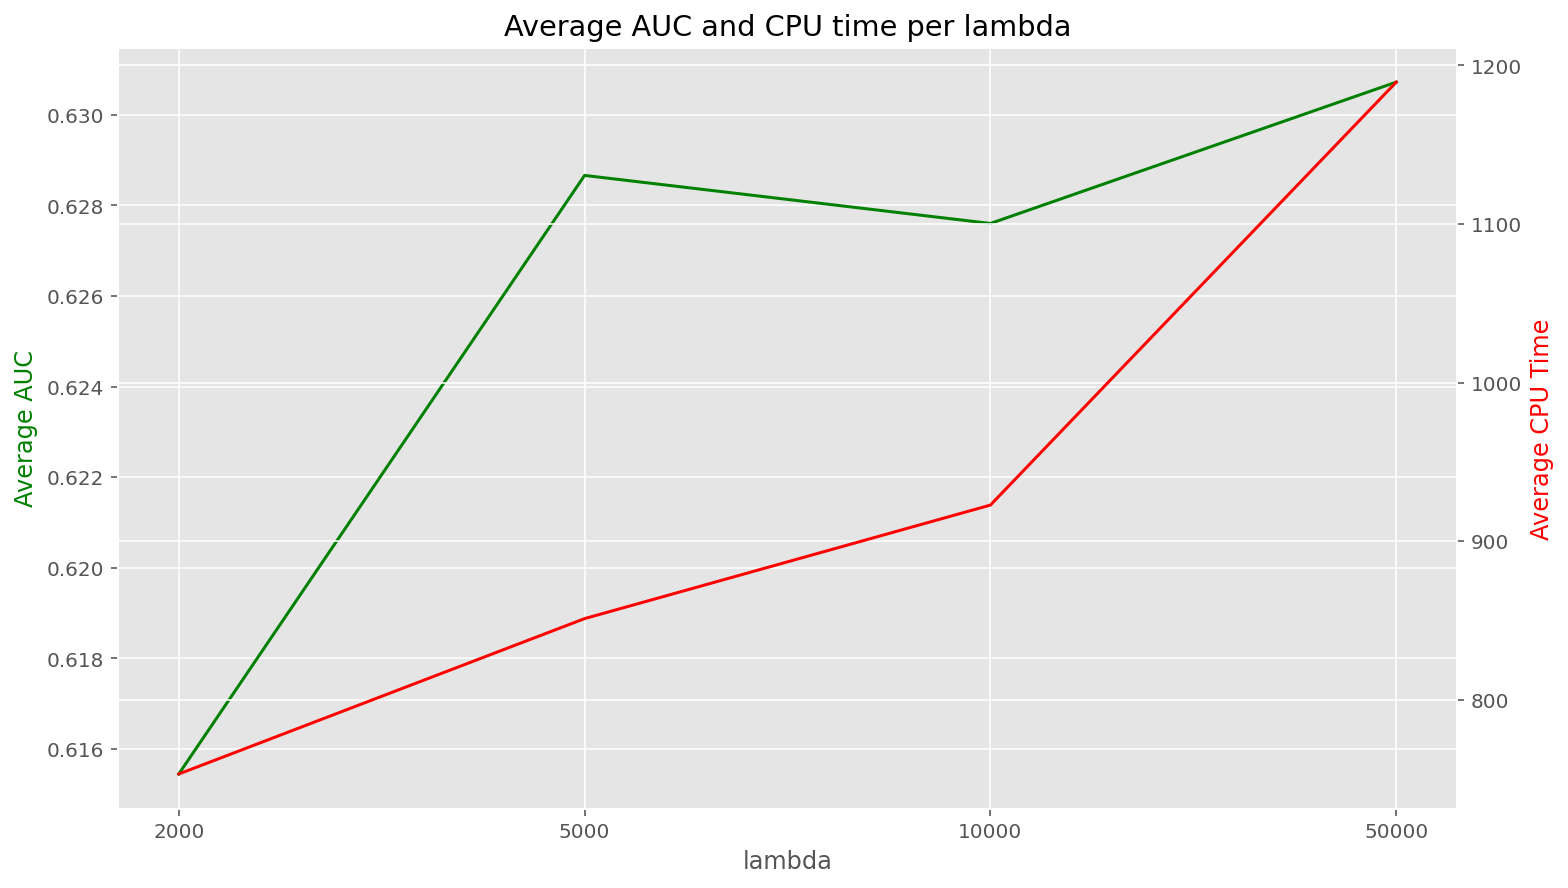

In [15]:
Ks=[5]
Xis = [0.2]
Ns = [150]
lambdas = [2000,5000,10000,50000]
ESSrmins = [0.2]
best_lambda= optimize(Ks, lambdas, Xis, Ns, ESSrmins)

ESSrmin = 0.15
AUC : 0.639, 0.625, 0.633, 0.623, 0.641, 
Mean AUC : 0.632
Average run time : 1235.44 s
ESSrmin = 0.2
AUC : 0.634, 0.622, 0.629, 0.623, 0.642, 
Mean AUC : 0.630
Average run time : 1166.62 s
ESSrmin = 0.3
AUC : 0.637, 0.623, 0.631, 0.623, 0.643, 
Mean AUC : 0.631
Average run time : 1272.95 s
Highest mean AUC obtained for ESSrmin = 0.15


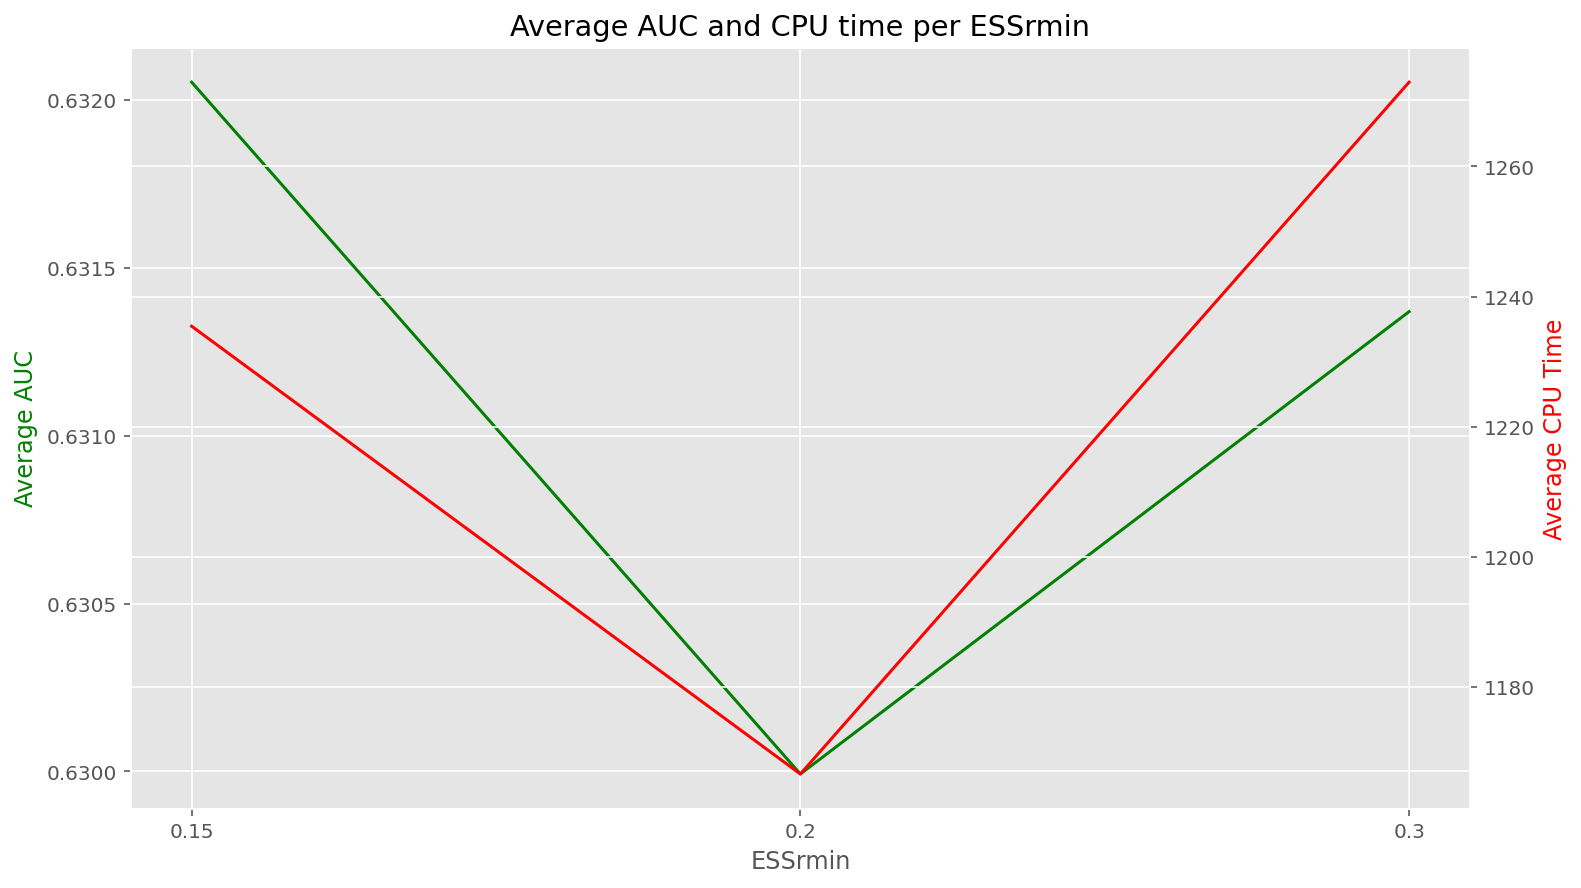

In [16]:
Ks=[5]
Xis = [0.2]
Ns = [150]
lambdas = [500000]
ESSrmins = [0.15, 0.2, 0.3]
best_essrmin= optimize(Ks, lambdas, Xis, Ns, ESSrmins)

In [15]:
# We keep the following hyperparameters:
K = 5
Xi = 0.2
N = 150
lamb = 50000
ESSrmin = 0.15
# AUC on test data:
prior = dists.StructDist({'beta':dists.MvNormal(scale=Xi, cov=np.eye(d))})
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lamb*risk(theta["beta"], x_train, y_train))
model = PAC_Bayesian_classifier(base_dist=prior)
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
l_auc=[]
for i in range(10):
    pf = particles.SMC(N=N, fk=fk, ESSrmin=1., collect=[Moments],verbose=False)
    pf.run()
    l_auc.append(auc(modal_val(pf.X.theta["beta"]), x_test, y_test))
l_auc

[0.6446128930494199,
 0.6523391142167438,
 0.6516979226490994,
 0.6545881236126052,
 0.6564663425704981,
 0.6496010138886802,
 0.6533535517881719,
 0.6524473035576239,
 0.6429136415058799,
 0.655009180927245]

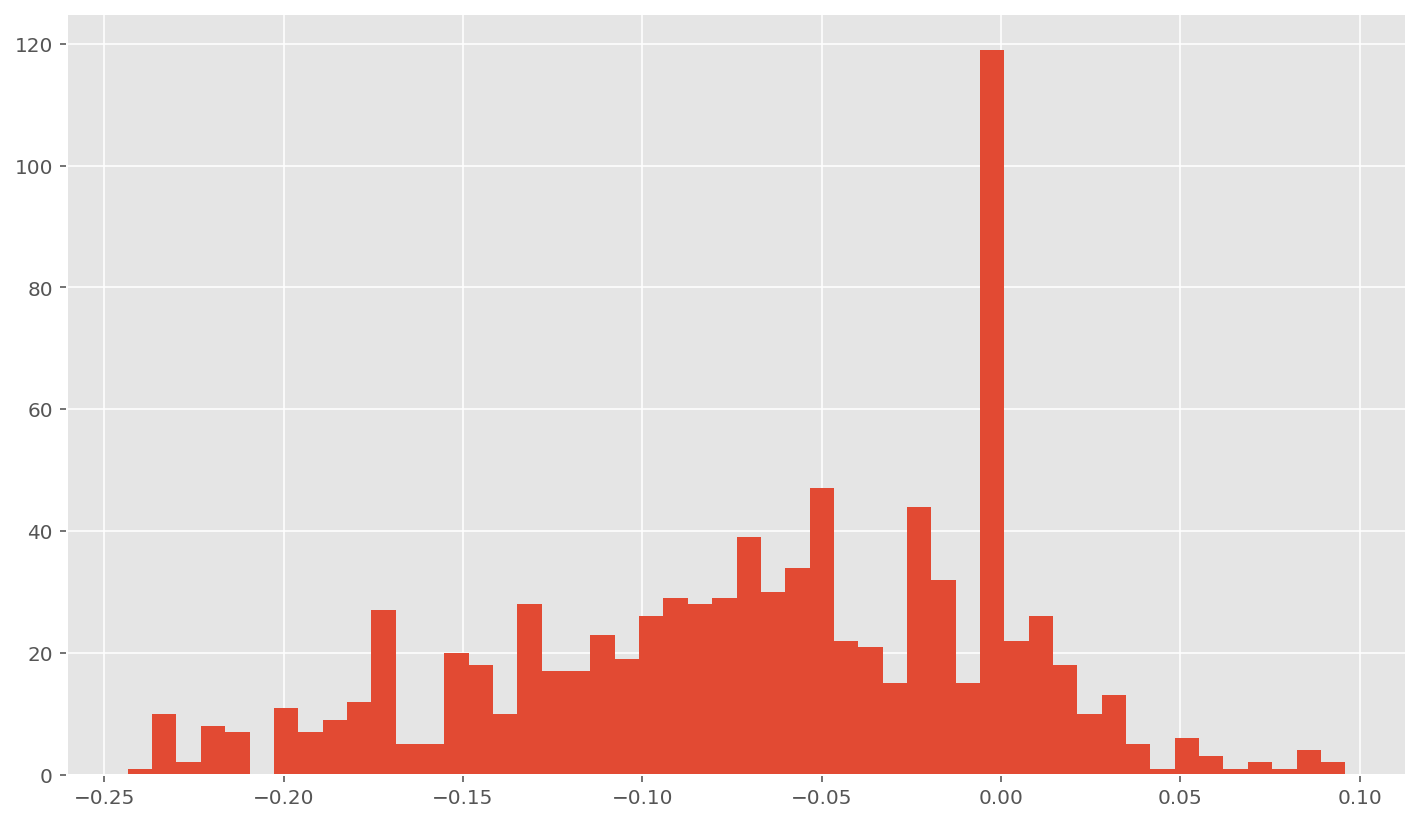

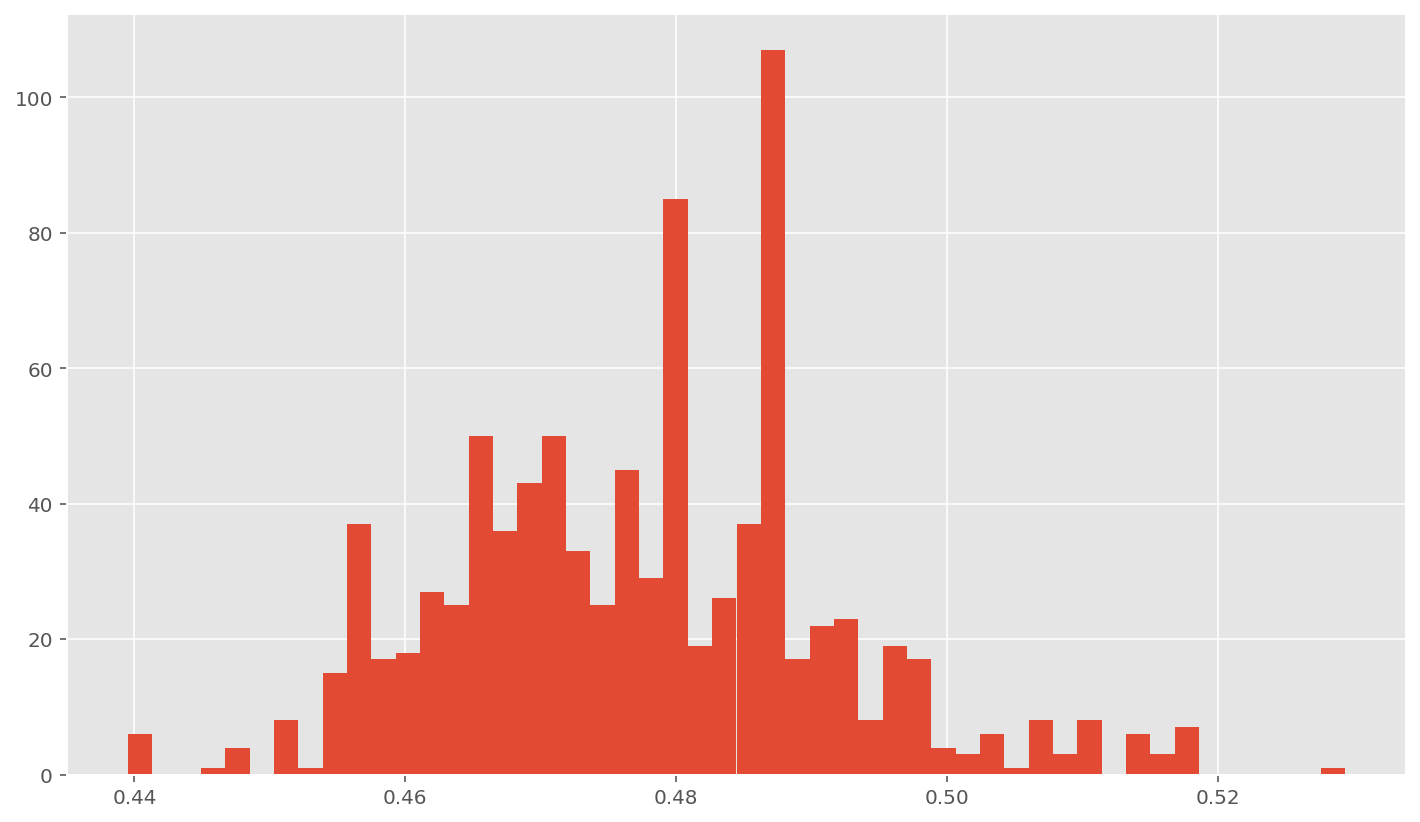

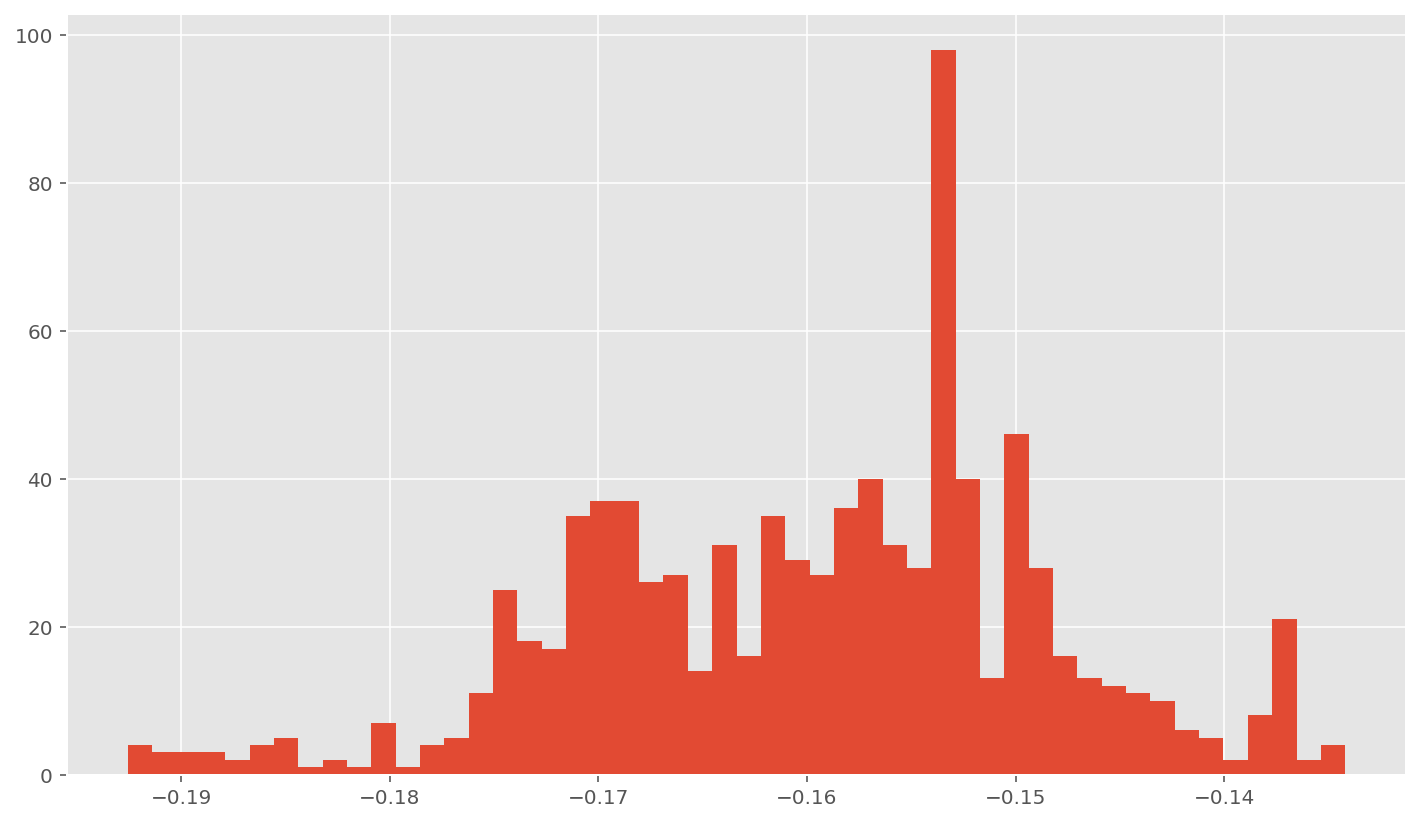

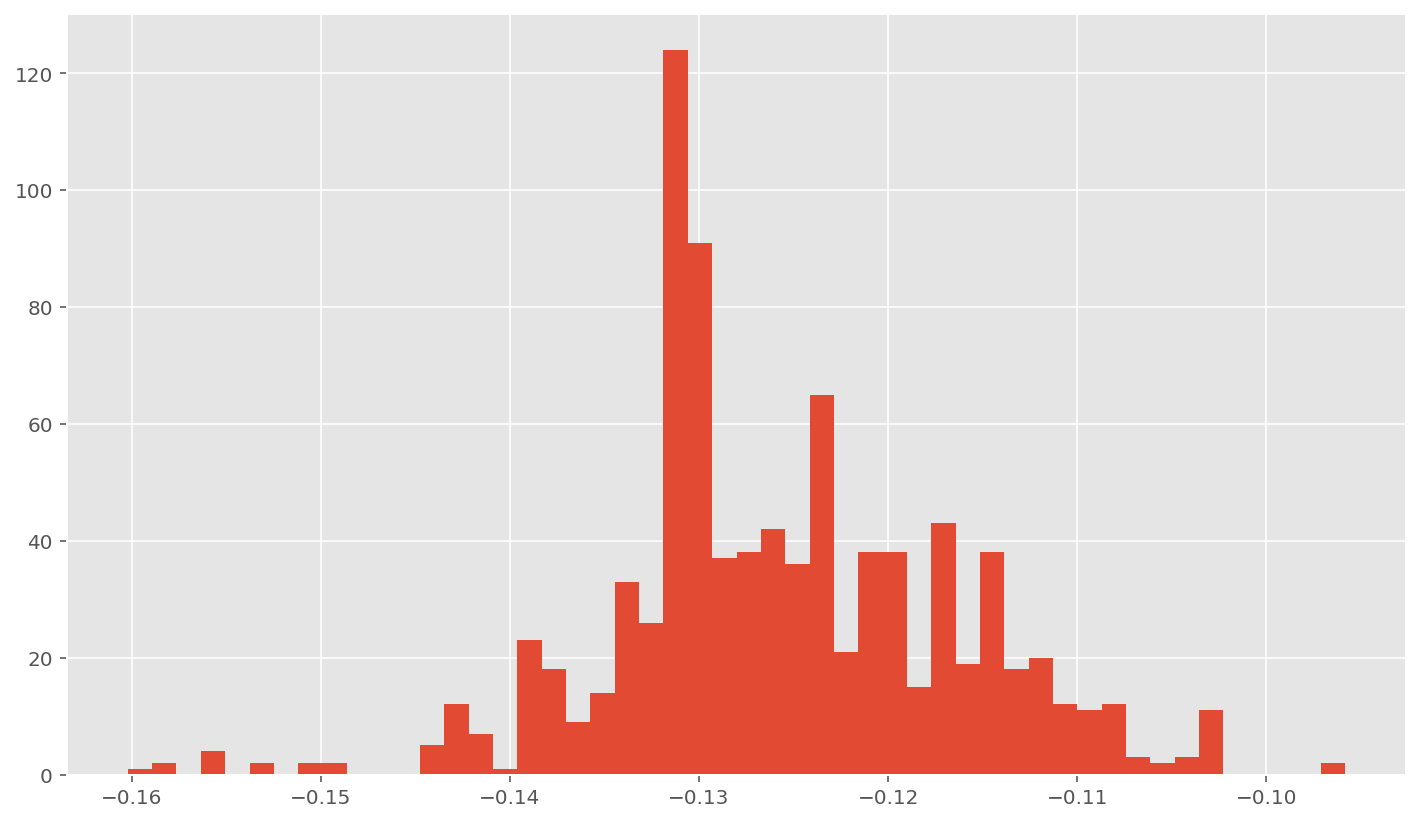

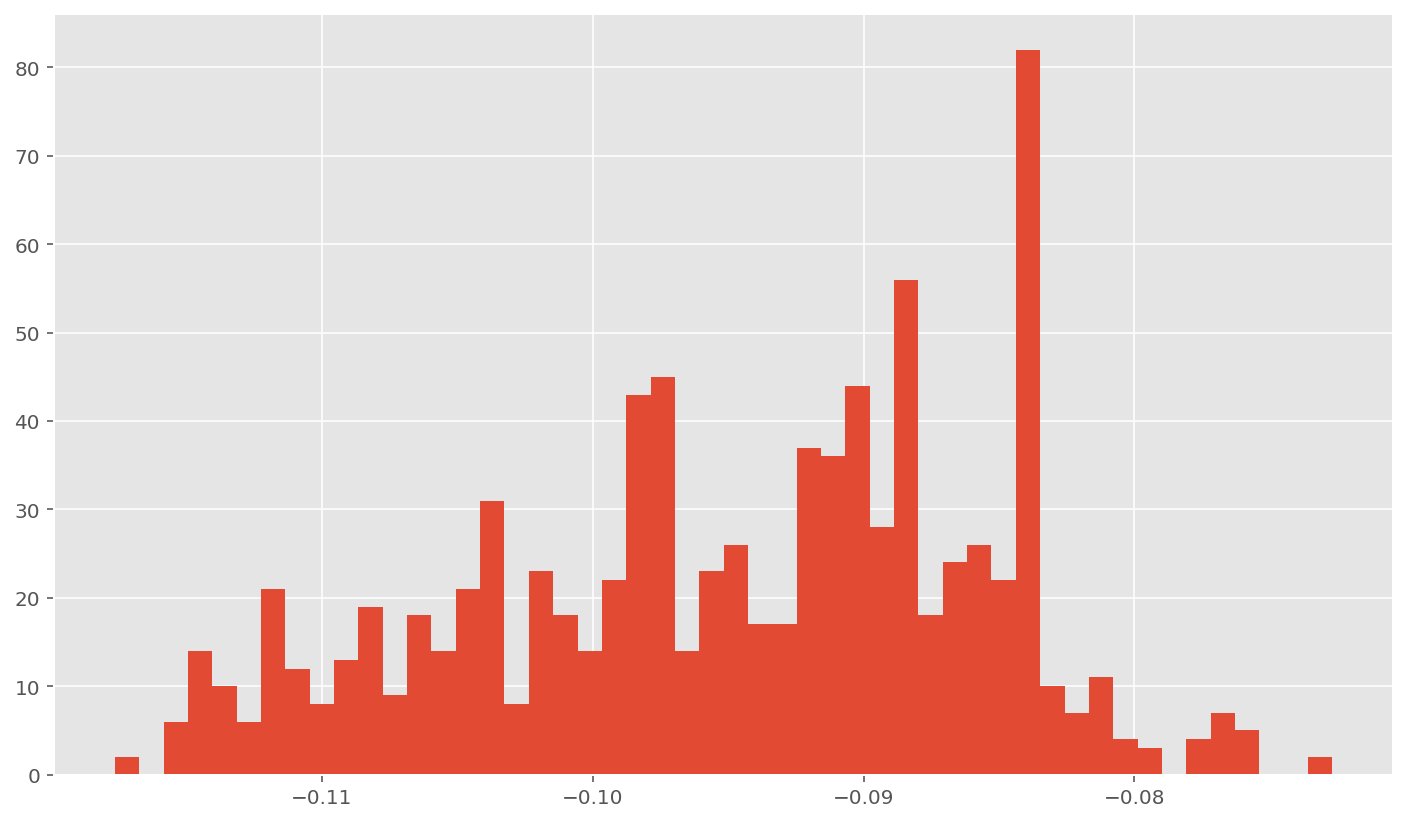

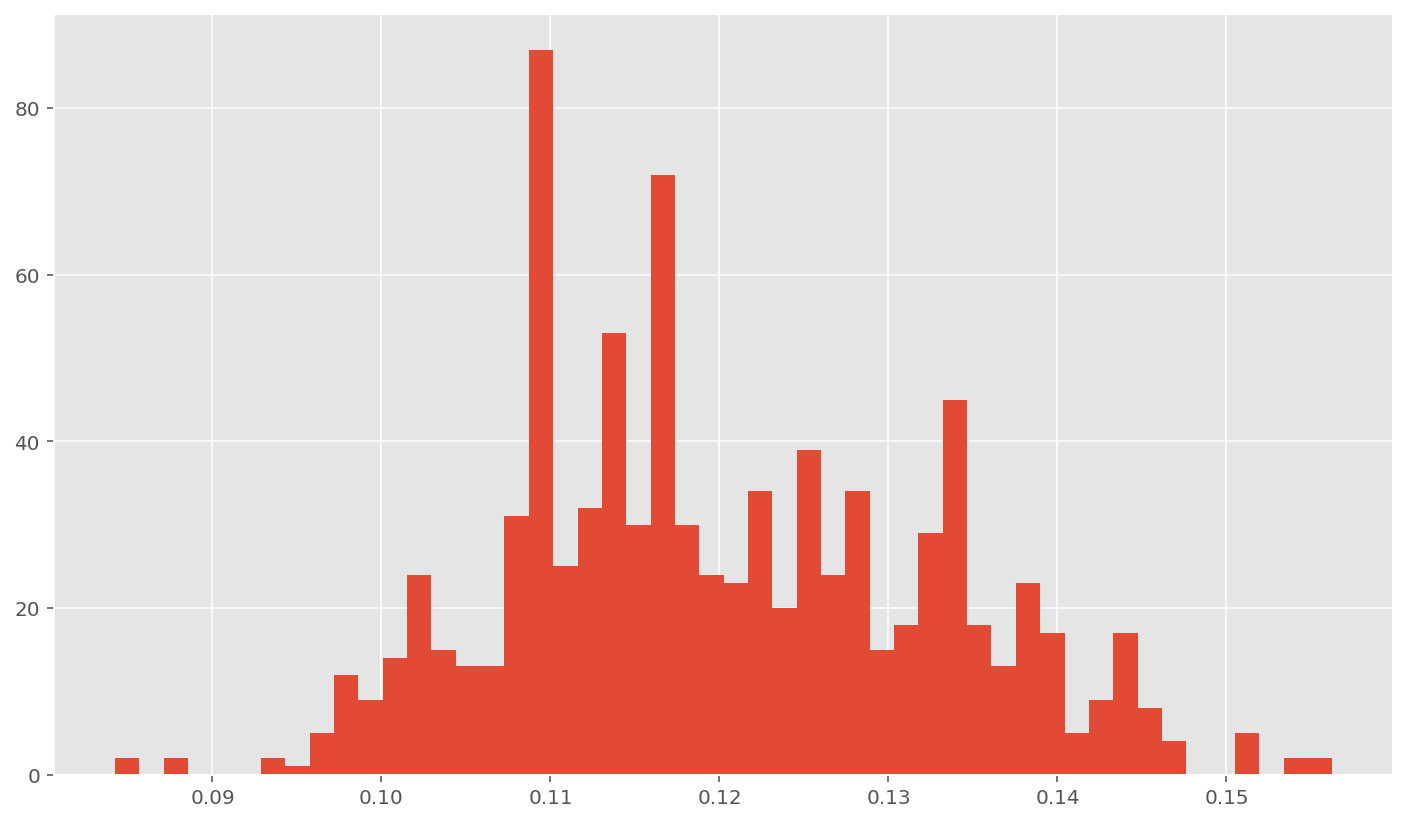

In [17]:
plot_coefs(pf, plots=6)

The sampled distribution isn't very smooth because N is low (and for higher N it would take longer to run), however we can see a clear mode in every distribution which should provide a good estimate of the coefficients

In [18]:
np.mean(l_auc)

0.6513029087765967

In [19]:
np.std(l_auc)

0.004194844861800465

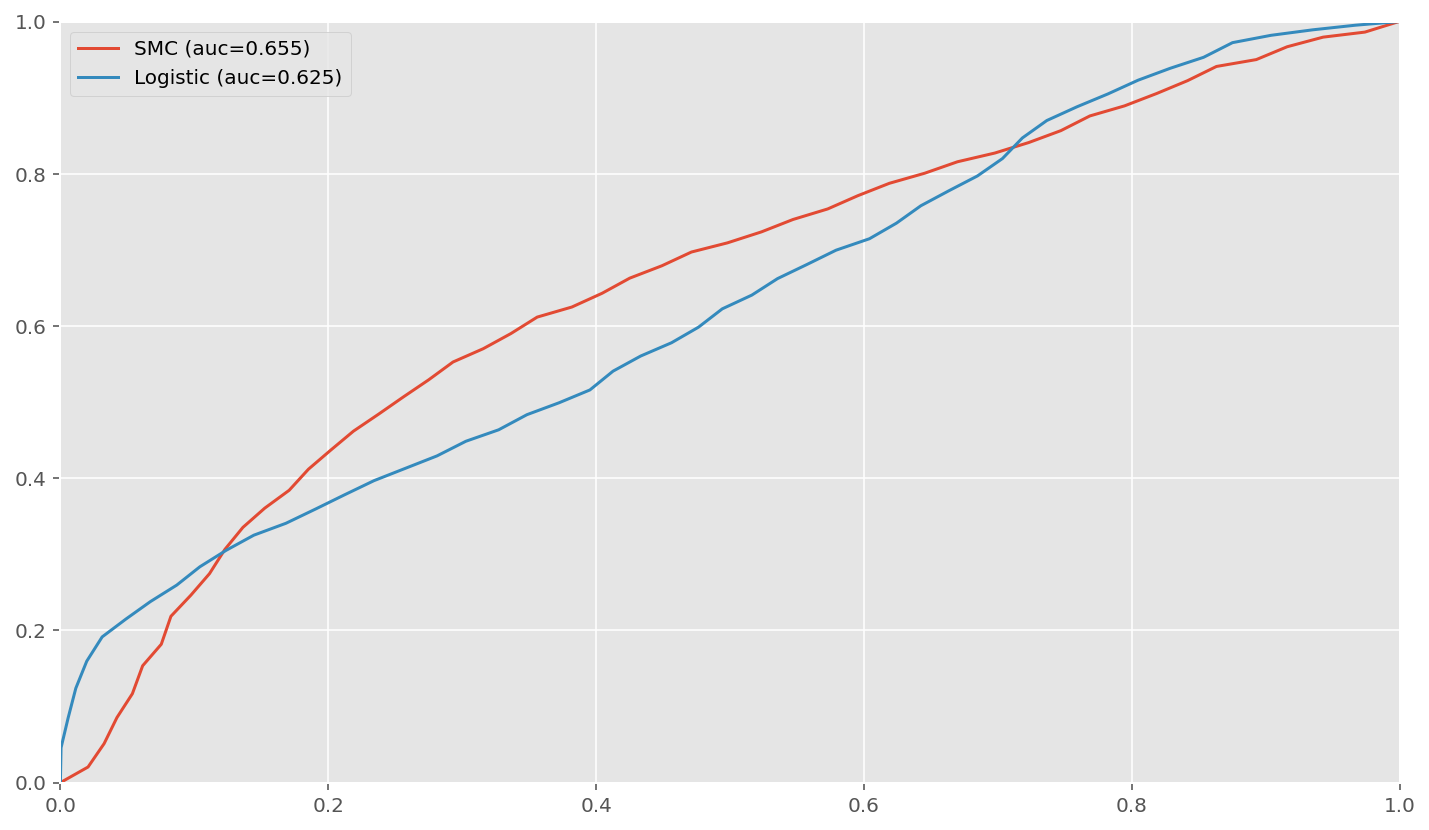

In [20]:
roc_curve_with_logreg(modal_val(pf.X.theta["beta"]), x_test, y_test)

In [18]:
auc(modal_val(pf.X.theta["beta"]), x_test, y_test)

0.6549437473205447

In [19]:
auc(modal_val(pf.X.theta["beta"]), x_train, y_train)

0.6373641077113897

In [20]:
auc( LogisticRegression().fit(x_train,y_train).coef_[0], x_test, y_test)

0.6245048423757862

In [21]:
auc( LogisticRegression().fit(x_train,y_train).coef_[0], x_train, y_train)

0.6139369149614278

For EEG data our PAC-Bayesian classifier performs better than logistic regression on both training and test set

## Model diagnostics

An example with high N and high K: the sampler takes longer to run, but we obtain very smooth posterior distributions:

In [106]:
# Another run on pima with high N and K
# Parameters
K = 10
ESSrmin = 0.5
lambda_smc = 1e4
xi = 5.
N = 10**4

# Defining the prior
#prior = dists.MvNormal(scale=xi, cov=np.eye(d))
prior = dists.StructDist({'beta':dists.MvNormal(scale=xi, cov=np.eye(d))})

# Defining the model
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lambda_smc*risk(theta['beta']))
model = PAC_Bayesian_classifier(base_dist=prior)

# SMC Sampling
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
pf = particles.SMC(N=N, fk=fk, ESSrmin=1., verbose=True, collect=[Moments])

pf.run()
print('CPU time (min): %.2f' % (pf.cpu_time / 60))
print('loglik: %f' % pf.logLt)

t=0, ESS=55000.00, tempering exponent=0.00166
t=1, Metropolis acc. rate (over 10 steps): 0.252, ESS=55000.00, tempering exponent=0.00429
t=2, Metropolis acc. rate (over 10 steps): 0.237, ESS=55000.00, tempering exponent=0.00972
t=3, Metropolis acc. rate (over 10 steps): 0.233, ESS=55000.00, tempering exponent=0.0196
t=4, Metropolis acc. rate (over 10 steps): 0.230, ESS=55000.00, tempering exponent=0.0355
t=5, Metropolis acc. rate (over 10 steps): 0.225, ESS=55000.00, tempering exponent=0.0592
t=6, Metropolis acc. rate (over 10 steps): 0.220, ESS=55000.00, tempering exponent=0.0938
t=7, Metropolis acc. rate (over 10 steps): 0.215, ESS=55000.00, tempering exponent=0.148
t=8, Metropolis acc. rate (over 10 steps): 0.215, ESS=55000.00, tempering exponent=0.233
t=9, Metropolis acc. rate (over 10 steps): 0.217, ESS=55000.00, tempering exponent=0.33
t=10, Metropolis acc. rate (over 10 steps): 0.200, ESS=55000.00, tempering exponent=0.421
t=11, Metropolis acc. rate (over 10 steps): 0.181, ESS=5

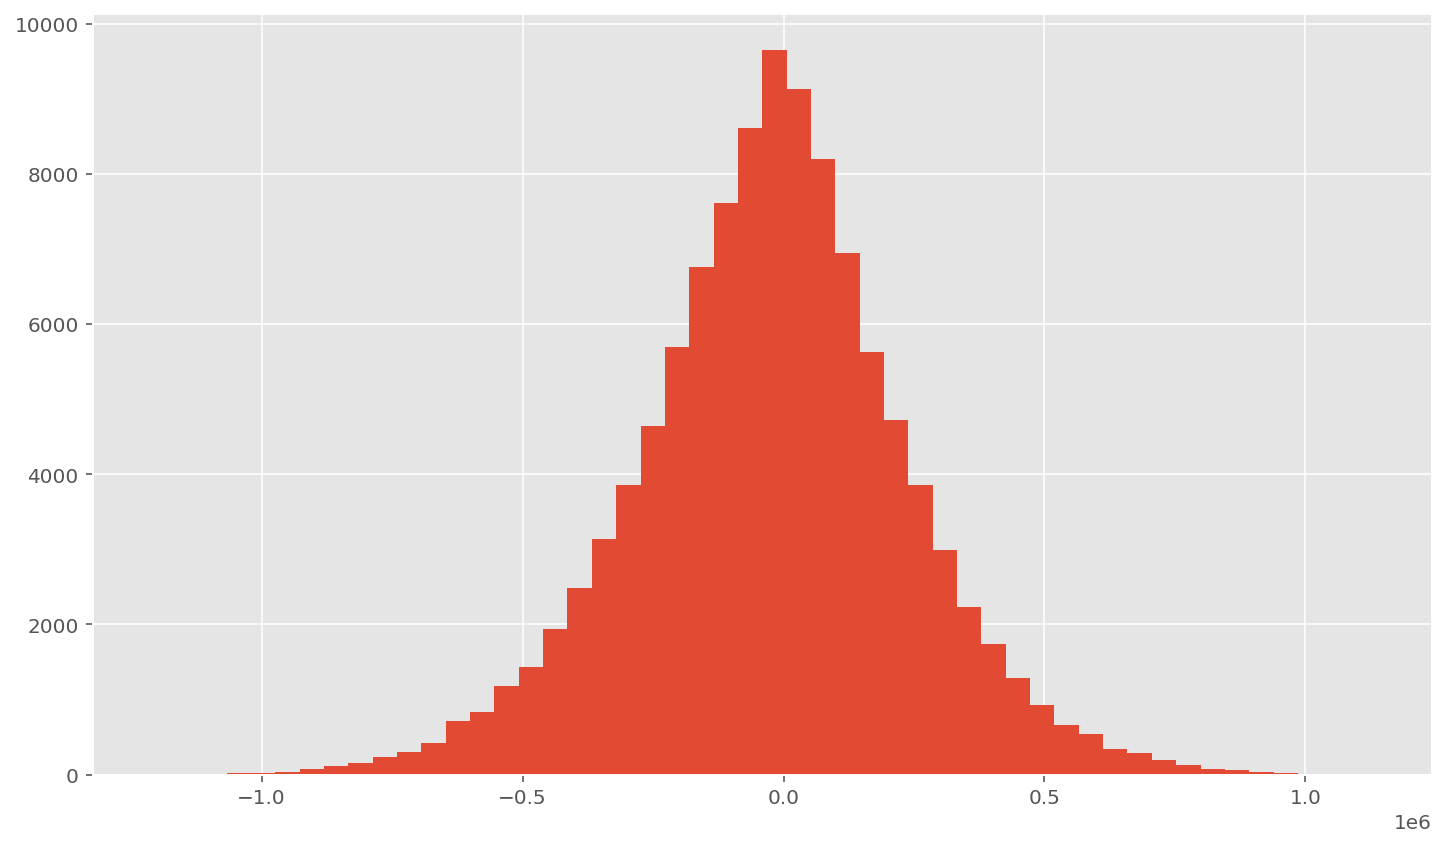

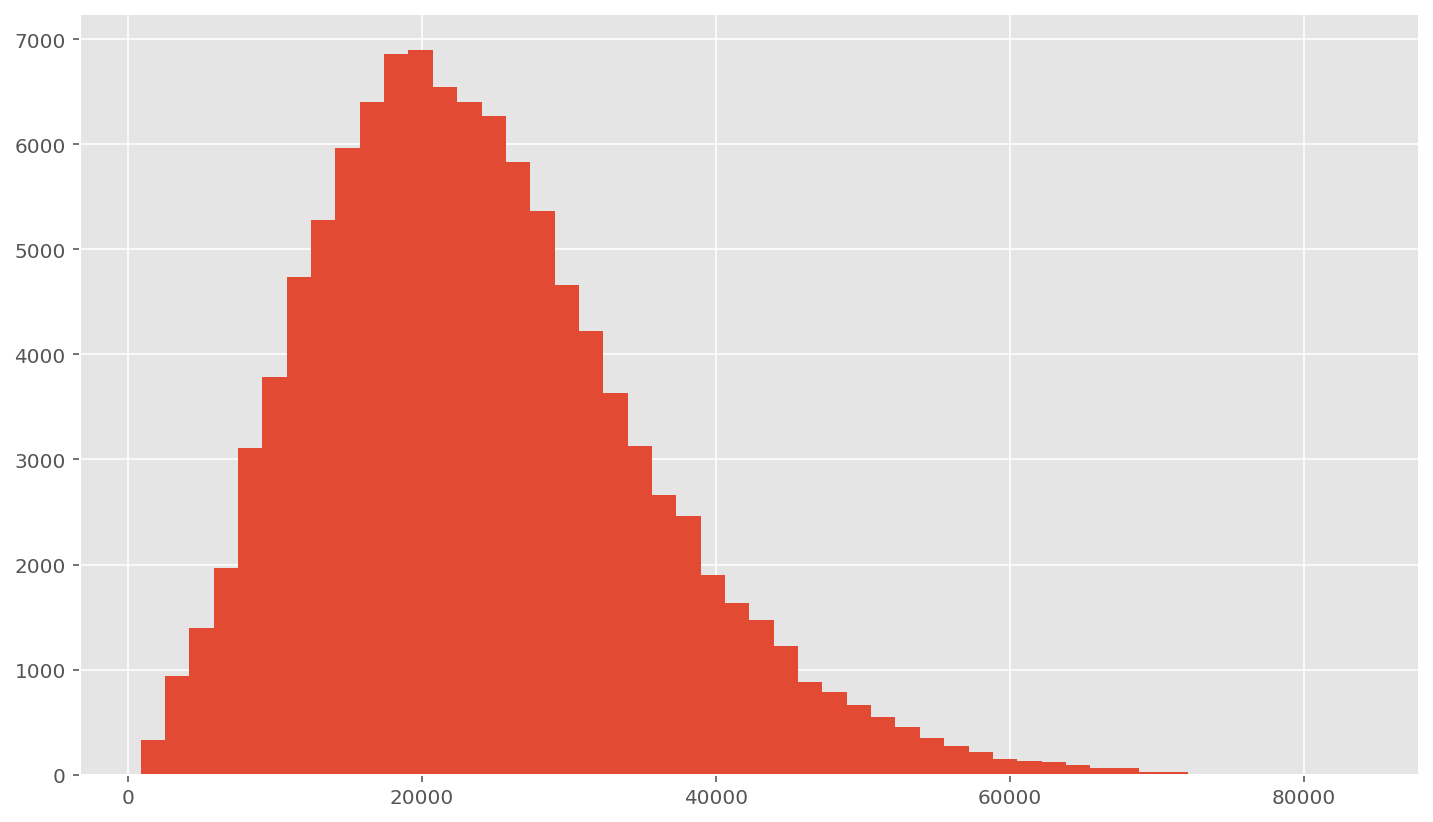

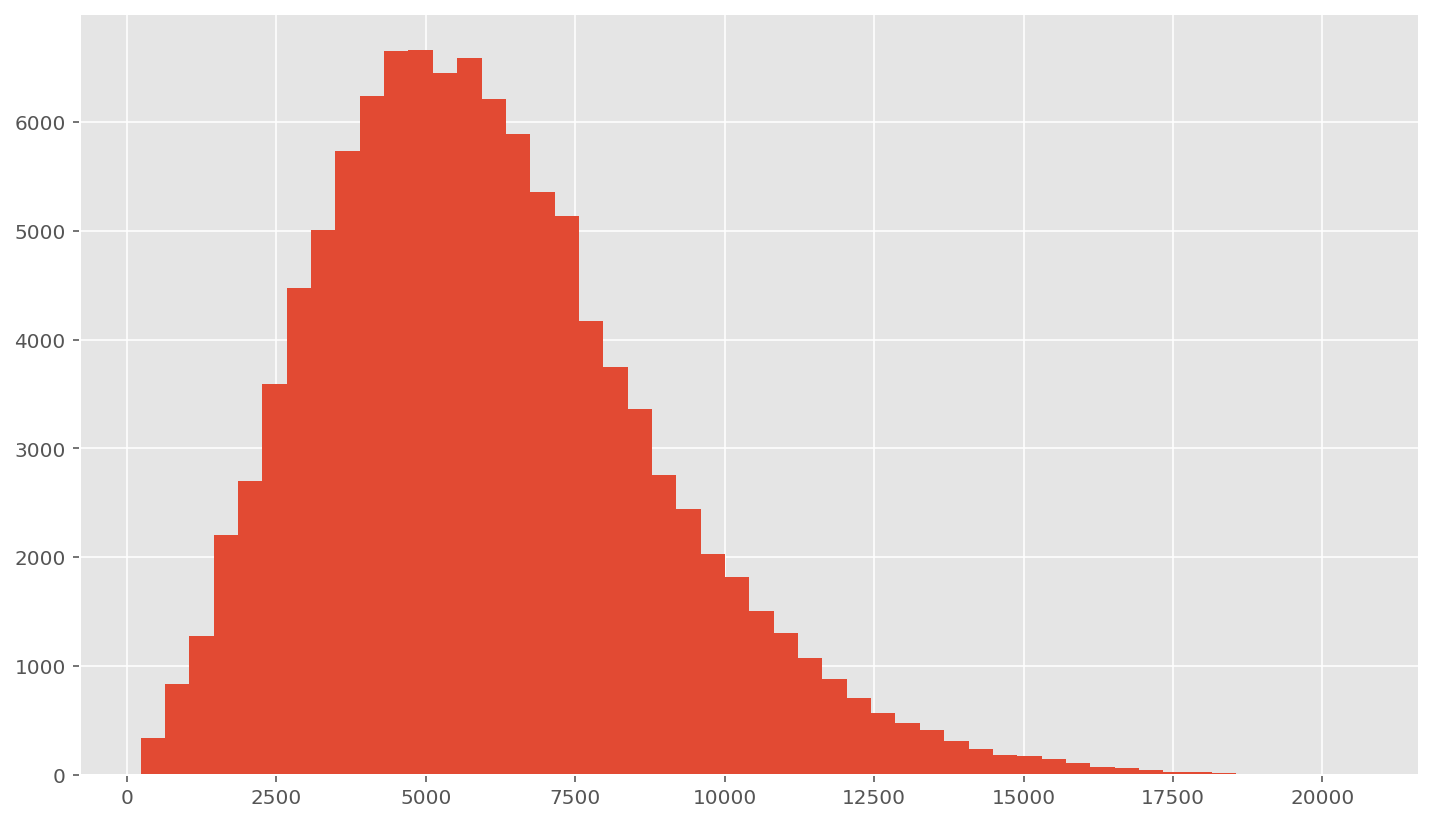

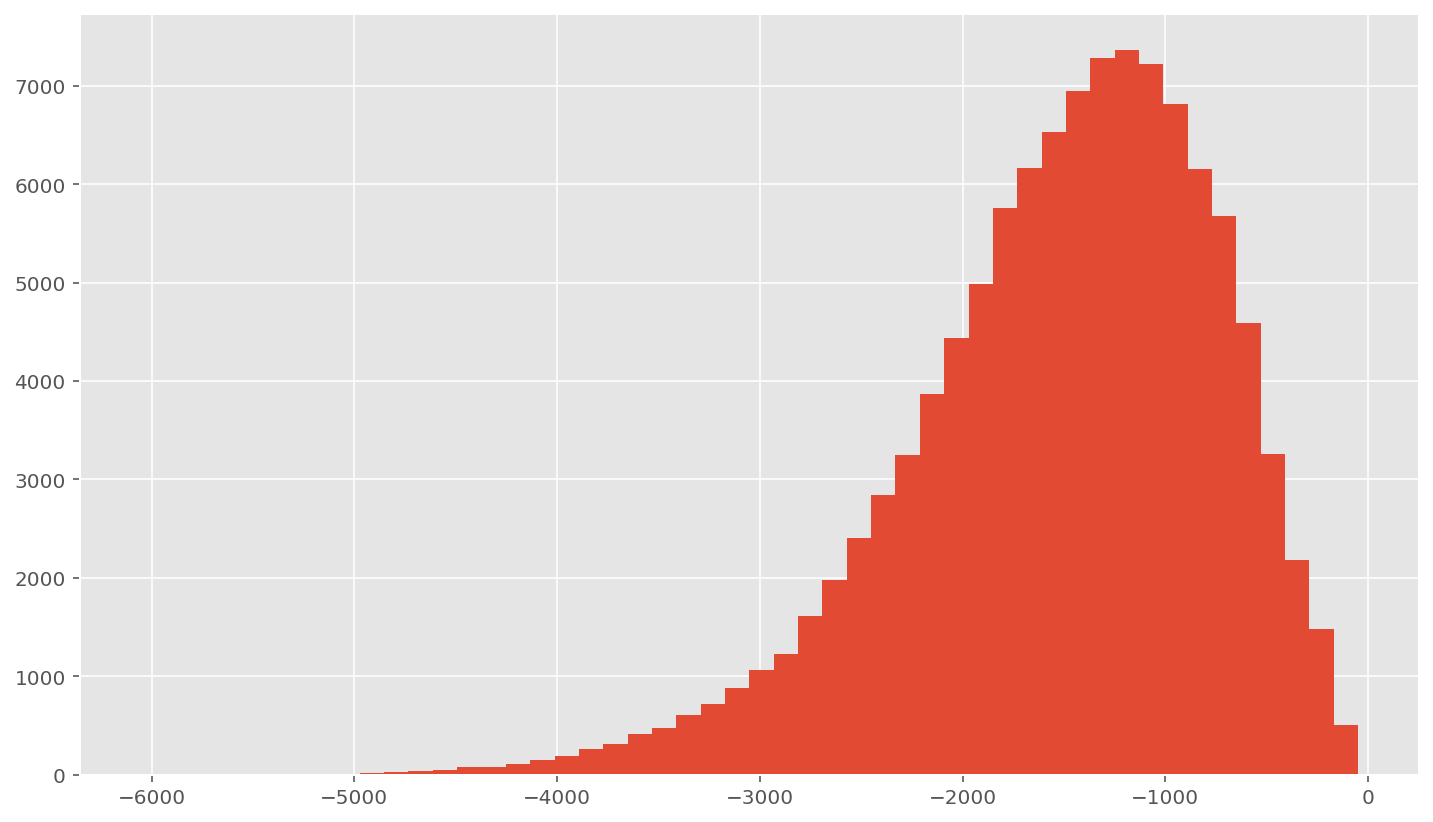

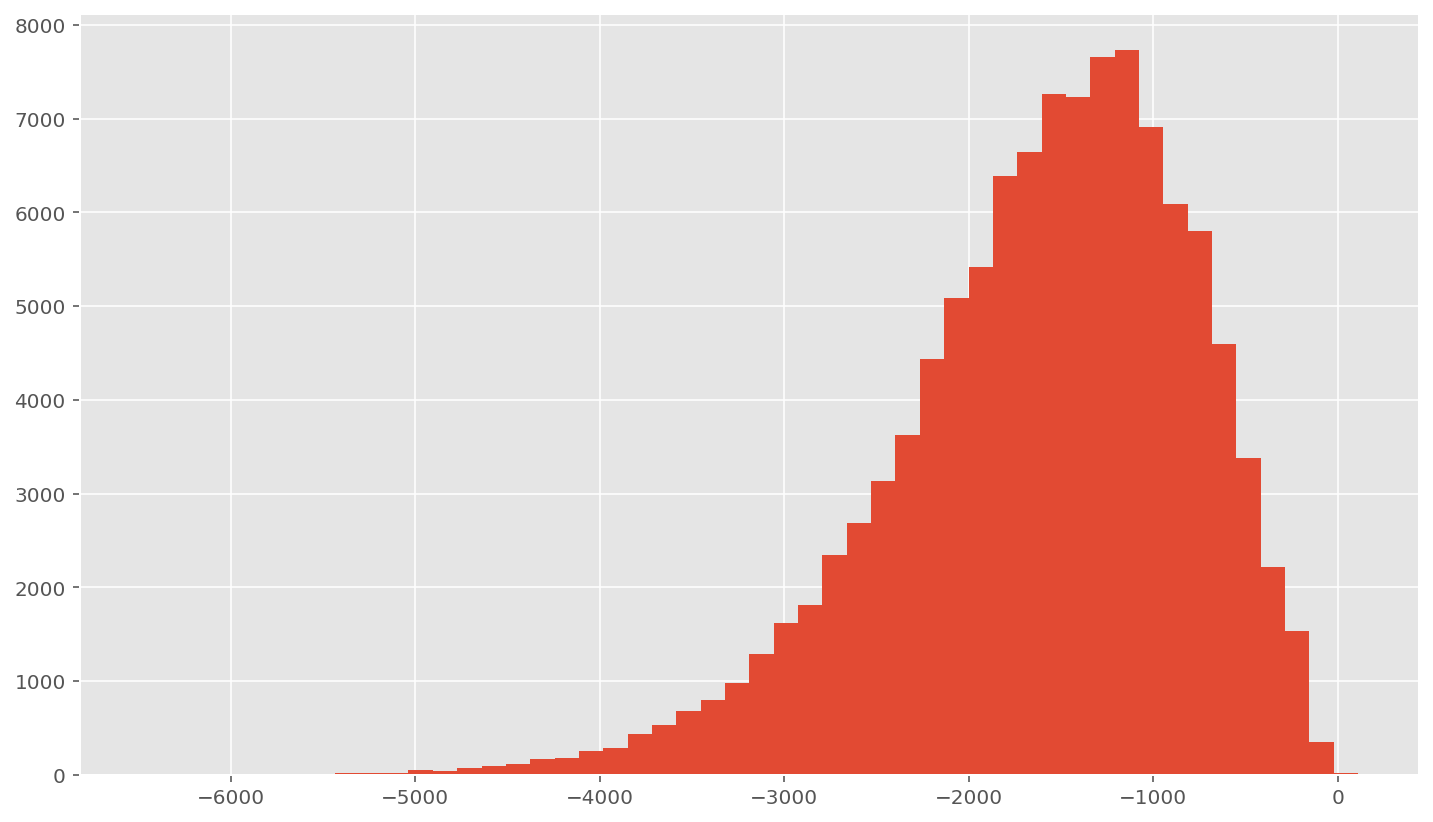

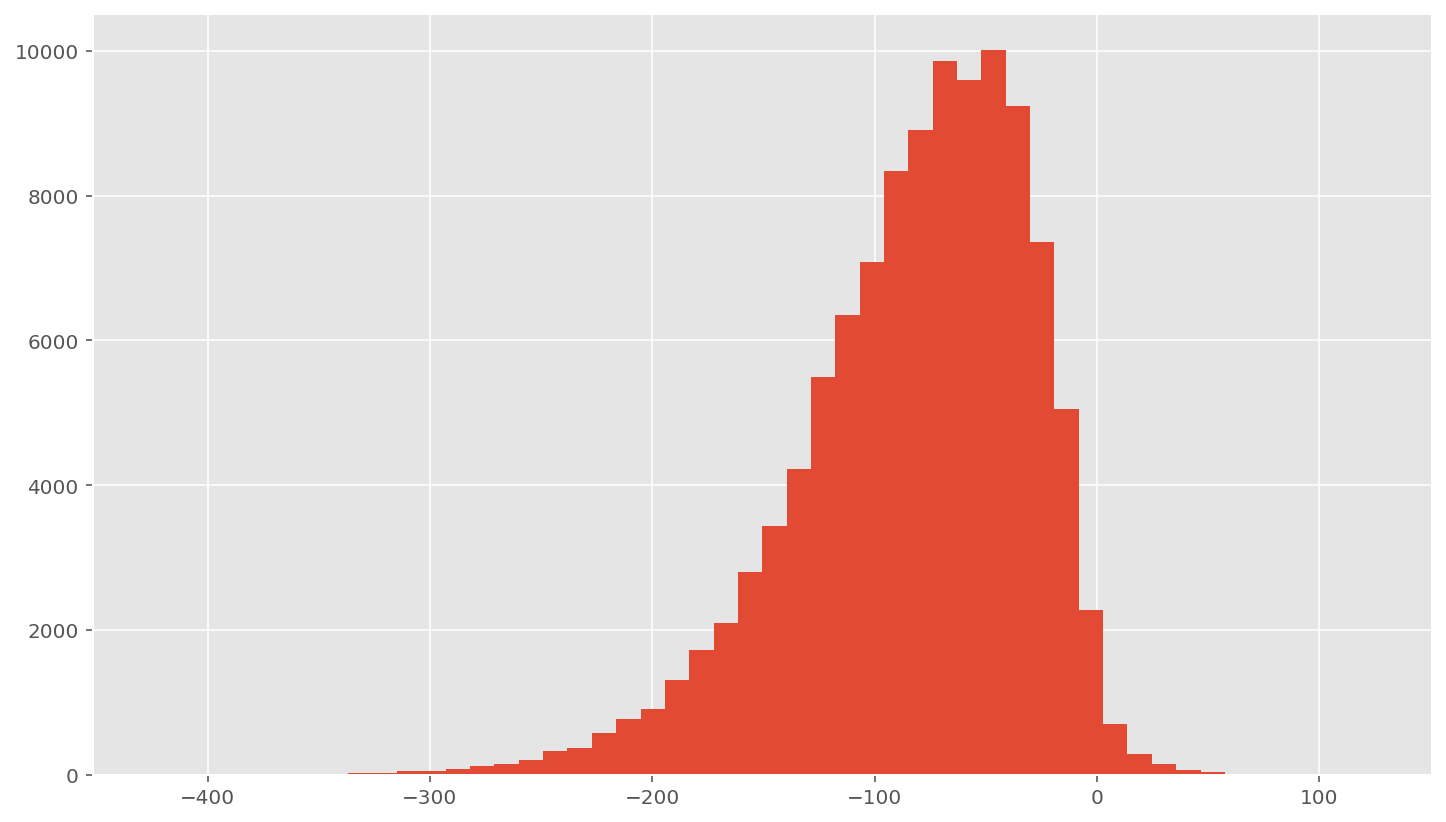

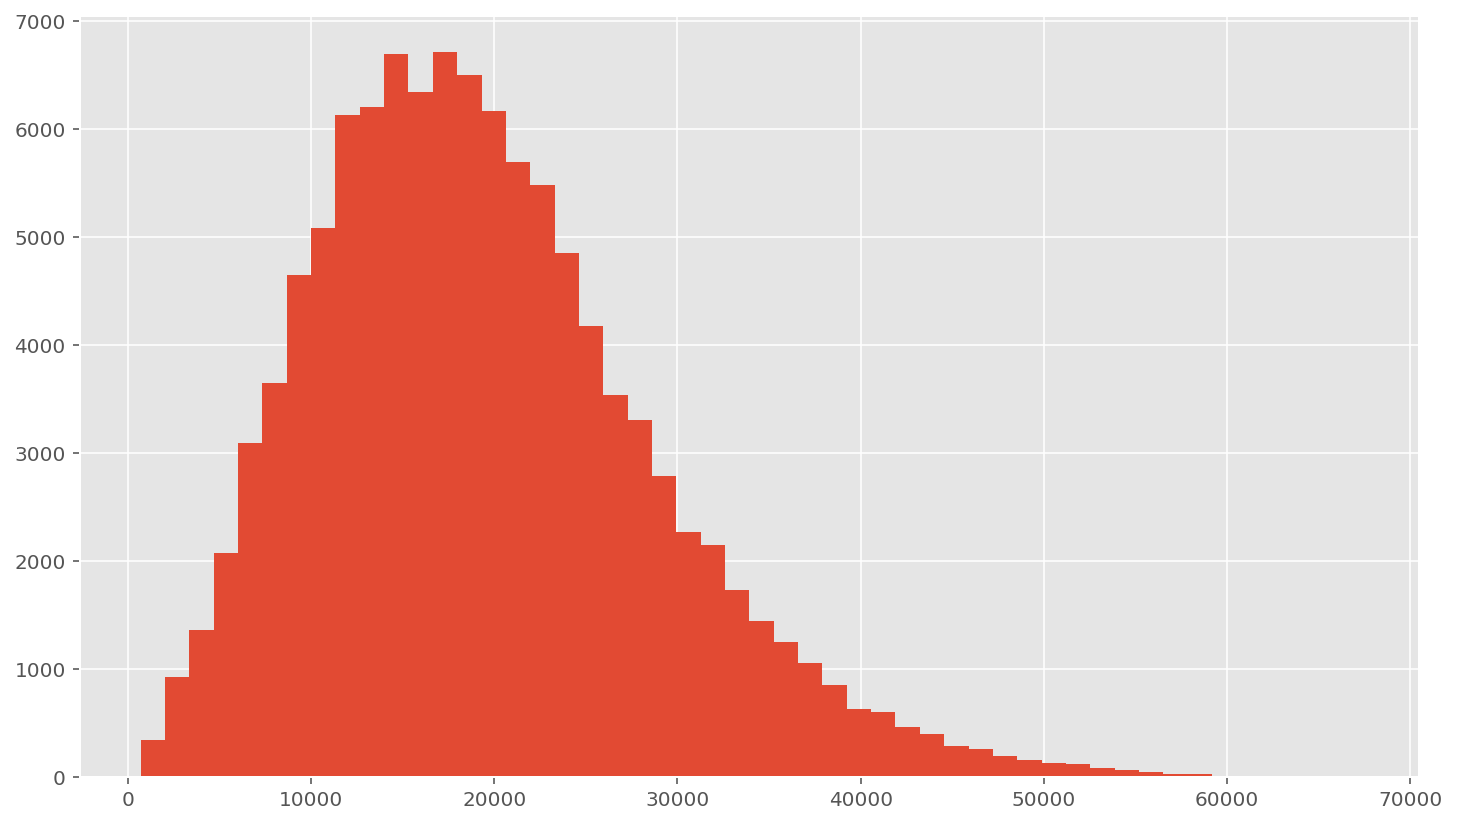

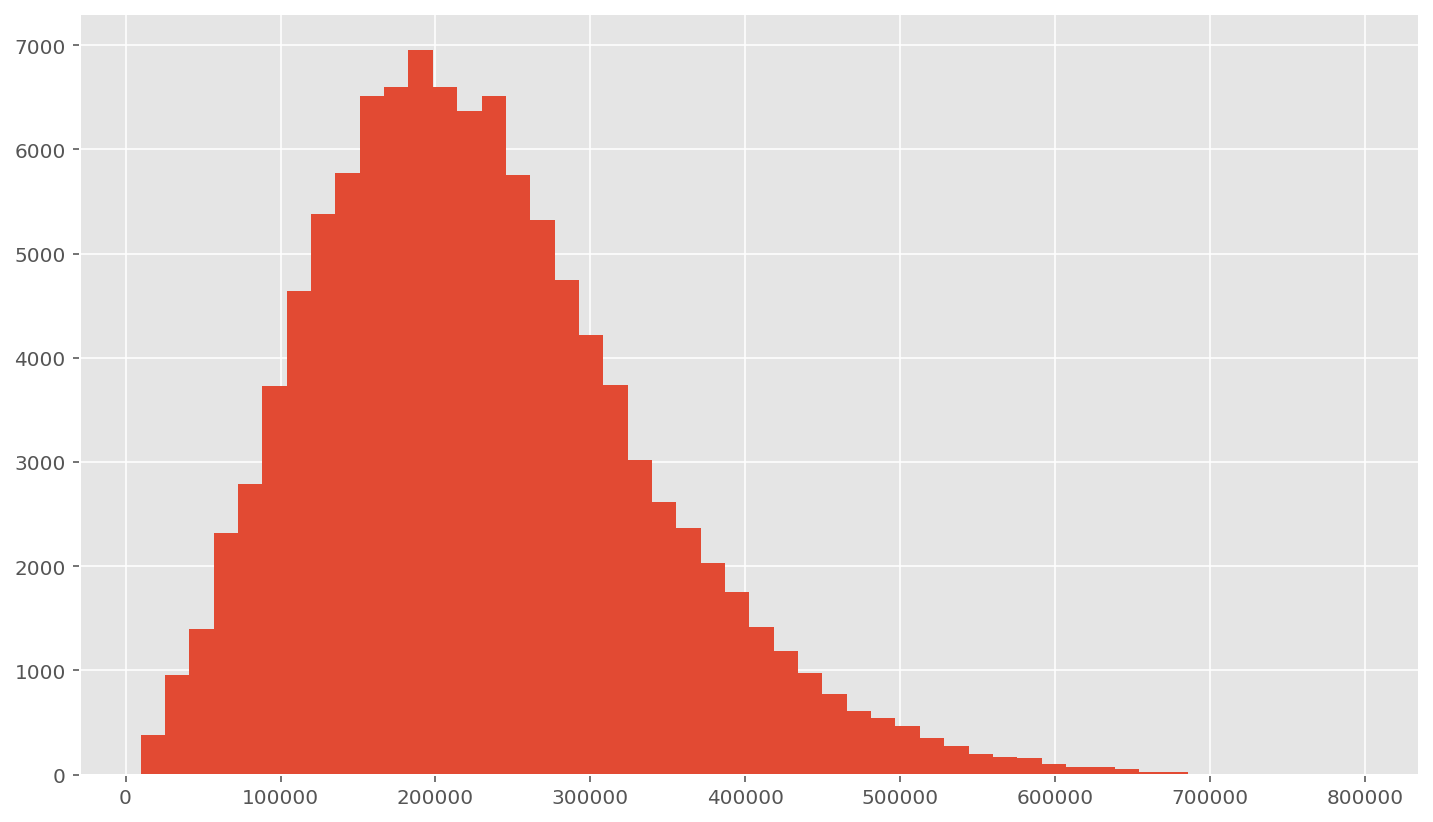

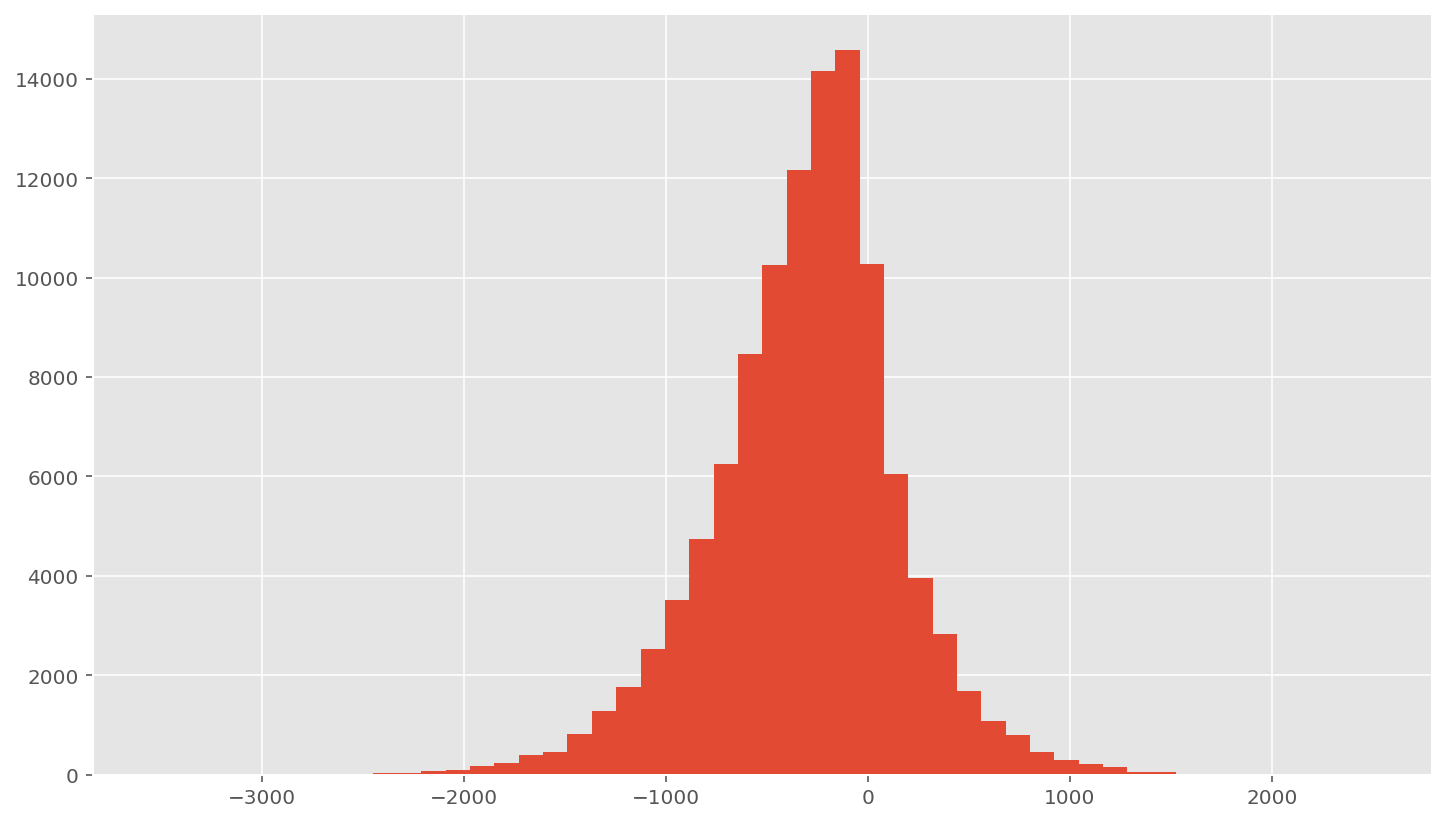

In [107]:
plot_coefs(pf)

Model diagnostics:

This code takes a long time to run. We provide here the code we used but this was a first version, we reran it on another machine to obtain the plots provided in the report.

In [13]:
# Parameters
Ks = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40]
ESSrmin = 0.5
lambda_smc = 10000
xi = 1.
N = 10**3


nruns=50
results=[]
# Defining the prior
#prior = dists.MvNormal(scale=xi, cov=np.eye(d))
prior = dists.StructDist({'beta':dists.MvNormal(scale=xi, cov=np.eye(d))})

for K in Ks:
    for nrun in range(nruns):
        # Defining the model
        class PAC_Bayesian_classifier(ssps.TemperingBridge):
            def logtarget(self, theta):
                return(-lambda_smc*risk(theta['beta']))
        model = PAC_Bayesian_classifier(base_dist=prior)

        # SMC Sampling
        fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
        pf = particles.SMC(N=N, fk=fk, ESSrmin=1., verbose=True, collect=[Moments])
        print("K: %i, run: %i" %(K, nrun))
        pf.run()
        print('CPU time (min): %.2f' % (pf.cpu_time / 60))
        print('loglik: %f' % pf.logLt)
        res = {'K': K, 
               'run': nrun,
               'out': pf.summaries,
               'cpu': pf.cpu_time}
        n_eval = N * n * (1. + K * (len(pf.summaries.ESSs) - 1))
        res['path_sampling'] = pf.X.shared['path_sampling'][-1]
        res['exponents'] = pf.X.shared['exponents']
        res['n_eval'] = n_eval
        results.append(res)

K: 1, run: 0
t=0, ESS=1000.00, tempering exponent=0.00155
t=1, Metropolis acc. rate (over 1 steps): 0.233, ESS=1000.00, tempering exponent=0.00371
t=2, Metropolis acc. rate (over 1 steps): 0.262, ESS=1000.00, tempering exponent=0.00709
t=3, Metropolis acc. rate (over 1 steps): 0.308, ESS=1000.00, tempering exponent=0.0116
t=4, Metropolis acc. rate (over 1 steps): 0.381, ESS=1000.00, tempering exponent=0.0177
t=5, Metropolis acc. rate (over 1 steps): 0.494, ESS=1000.00, tempering exponent=0.0244
t=6, Metropolis acc. rate (over 1 steps): 0.509, ESS=1000.00, tempering exponent=0.0319
t=7, Metropolis acc. rate (over 1 steps): 0.547, ESS=1000.00, tempering exponent=0.043
t=8, Metropolis acc. rate (over 1 steps): 0.565, ESS=1000.00, tempering exponent=0.0606
t=9, Metropolis acc. rate (over 1 steps): 0.577, ESS=1000.00, tempering exponent=0.0825
t=10, Metropolis acc. rate (over 1 steps): 0.572, ESS=1000.00, tempering exponent=0.108
t=11, Metropolis acc. rate (over 1 steps): 0.555, ESS=1000.00

Text(0, 0.5, 'posterior expectation first predictor')

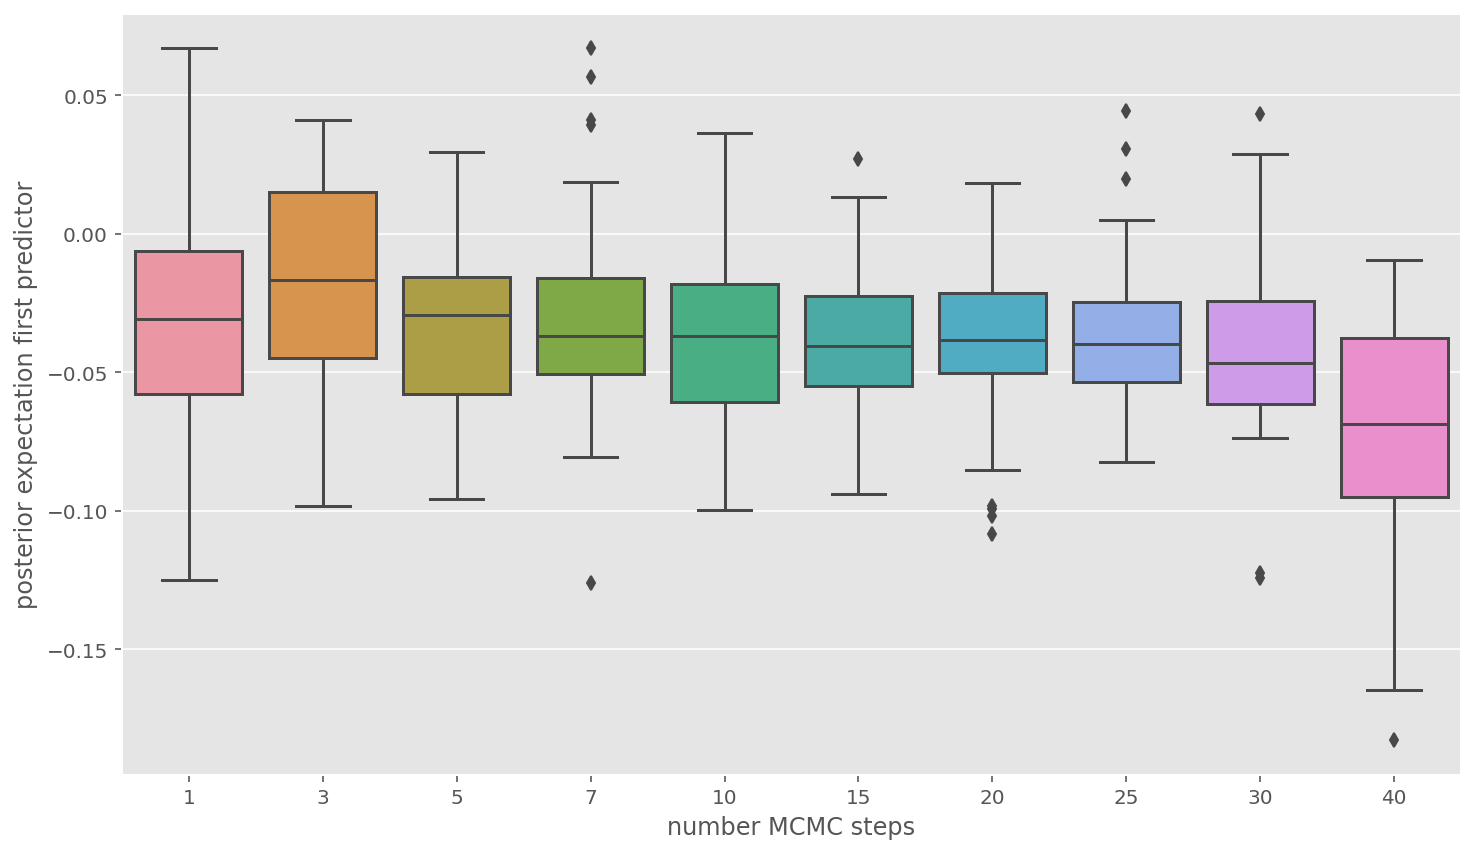

In [60]:
# The posterior mean of the first predictor coefficient with respect to K
plt.figure()
sb.boxplot(x=[r['K'] for r in results],
           y=[r['out'].moments[-1]['mean']['beta'][1] for r in results])
plt.xlabel('number MCMC steps')
plt.ylabel('posterior expectation first predictor')

Text(0, 0.5, 'marginal likelihood')

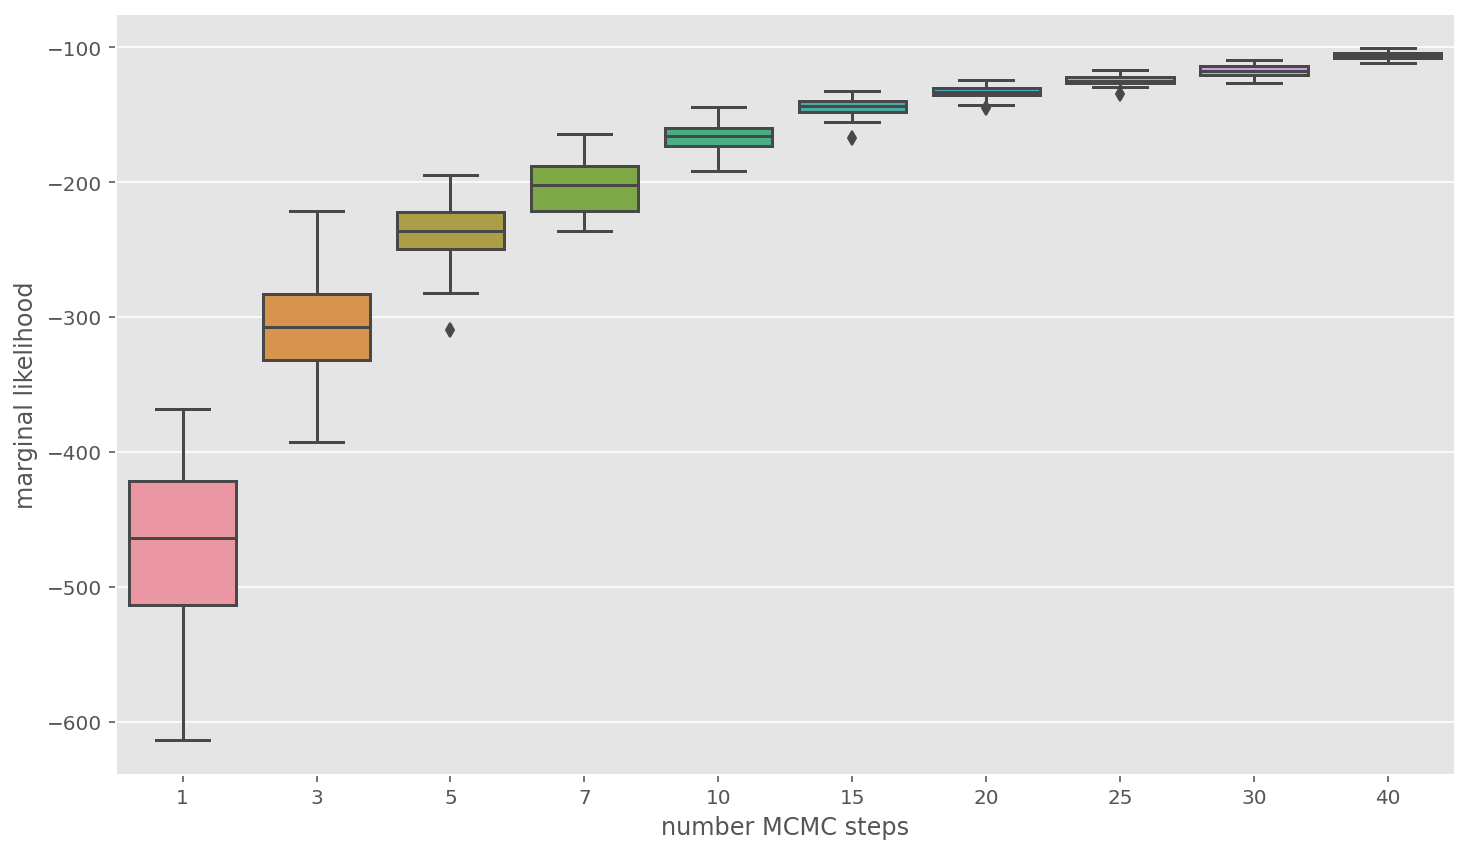

In [61]:
# Box-plots estimate versus number of MCMC steps
# marginal likelihood
plt.figure()
sb.boxplot(x=[r['K'] for r in results],
           y=[r['out'].logLts[-1] for r in results])
plt.xlabel('number MCMC steps')
plt.ylabel('marginal likelihood')

Text(0, 0.5, 'variance times number MCMC steps')

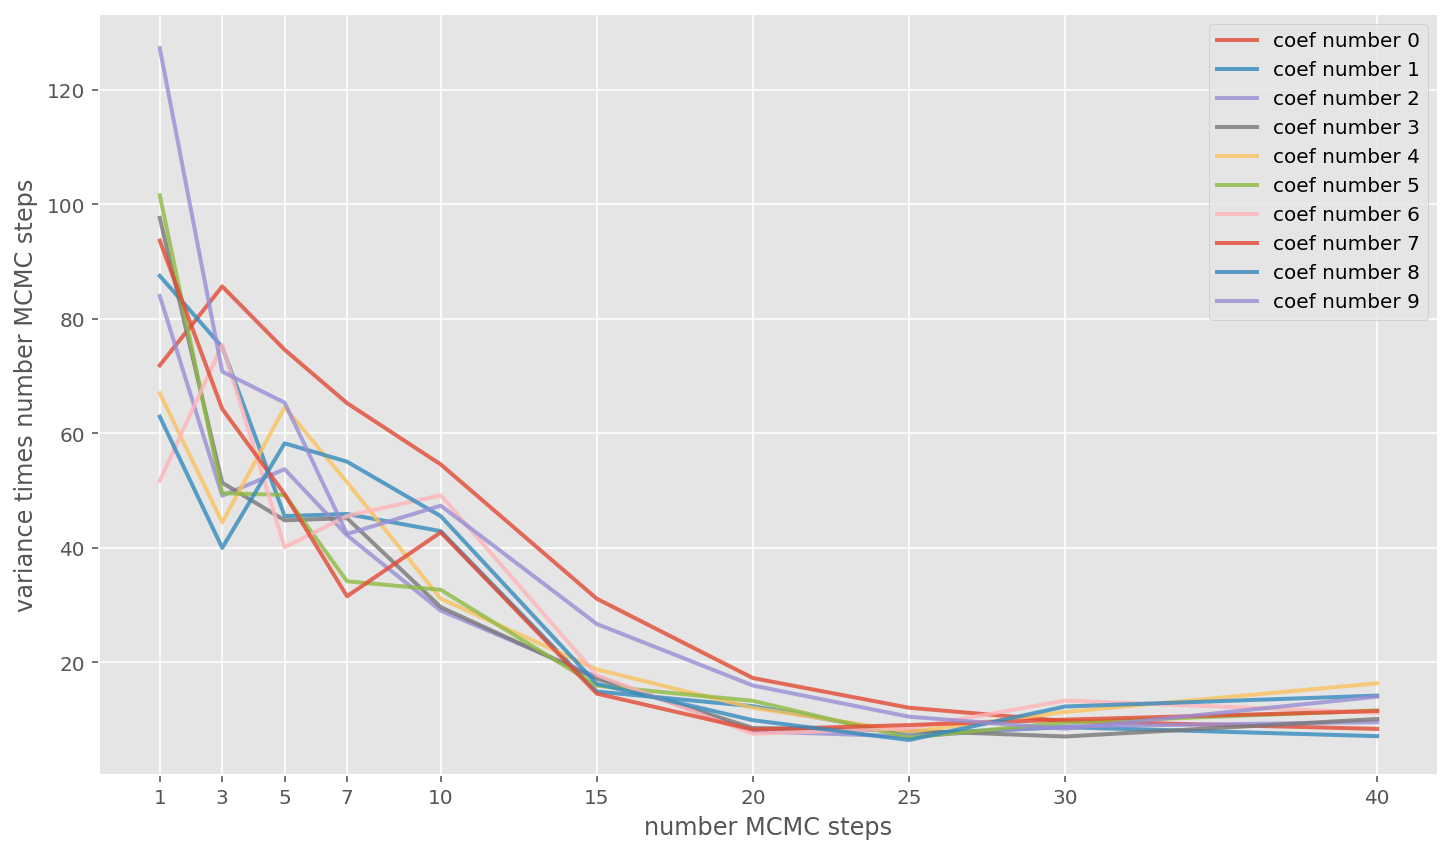

In [64]:
plt.figure()
for i in range(min(d_sonar,10)):
    adj_var = []
    for K in Ks:
        mts = [r['out'].moments[-1]
               for r in results if r['K']==K]
        av = (K * np.var([m['mean']['beta'][i] for m in mts]) /
                         np.mean([m['var']['beta'][i] for m in mts]))
        adj_var.append(av)
    plt.plot(Ks, adj_var, alpha=.8, linewidth=2, label="coef number "+str(i))

        
plt.legend()
plt.xticks(Ks, ['%i' % K for K in Ks])  # force int ticks
plt.xlabel('number MCMC steps')
plt.ylabel(r'variance times number MCMC steps')

### Non linear score

Here we test the non-linear classifier on Pima dataset. However we didn't obtain good results with it. Most of the time we obtained the following error:

In [144]:
# Parameters
K = 5
ESSrmin = 0.5
lambda_smc = 1000
xi = 1.
N = 5*10**3

# Defining the prior
cov_mat = exp_quadratic_kernel(x_train,x_train, Xi)
prior = dists.StructDist({'beta':dists.MvNormal(scale=xi, cov=cov_mat)})

# Defining the model
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lambda_smc*non_linear_risk(theta['beta']))  # Here we use the non-linear risk function
model = PAC_Bayesian_classifier(base_dist=prior)

# SMC Sampling
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
pf = particles.SMC(N=N, fk=fk, ESSrmin=1., verbose=True, collect=[Moments])

pf.run()
print('CPU time (min): %.2f' % (pf.cpu_time / 60))
print('loglik: %f' % pf.logLt)

t=0, ESS=15000.00, tempering exponent=0.0392
t=1, Metropolis acc. rate (over 5 steps): 0.217, ESS=15000.00, tempering exponent=0.0772
t=2, Metropolis acc. rate (over 5 steps): 0.209, ESS=15000.00, tempering exponent=0.118
t=3, Metropolis acc. rate (over 5 steps): 0.222, ESS=15000.00, tempering exponent=0.166
t=4, Metropolis acc. rate (over 5 steps): 0.254, ESS=15000.00, tempering exponent=0.217
t=5, Metropolis acc. rate (over 5 steps): 0.272, ESS=15000.00, tempering exponent=0.268
t=6, Metropolis acc. rate (over 5 steps): 0.260, ESS=15000.00, tempering exponent=0.323
t=7, Metropolis acc. rate (over 5 steps): 0.260, ESS=15000.00, tempering exponent=0.388
t=8, Metropolis acc. rate (over 5 steps): 0.228, ESS=15000.00, tempering exponent=0.485
t=9, Metropolis acc. rate (over 5 steps): 0.144, ESS=15000.00, tempering exponent=0.608
t=10, Metropolis acc. rate (over 5 steps): 0.075, ESS=15000.00, tempering exponent=0.737


LinAlgError: 294-th leading minor of the array is not positive definite

Sometimes it works with different hyperparameter values, but the AUC of the classifier is low.

In [145]:
# Parameters
K = 2
ESSrmin = 0.1
lambda_smc = 1000
xi = 1. # std dev of the prior
N = 5*10**3

# Defining the prior
cov_mat = exp_quadratic_kernel(x_train,x_train, Xi)
prior = dists.StructDist({'beta':dists.MvNormal(scale=xi, cov=cov_mat)})

# Defining the model
class PAC_Bayesian_classifier(ssps.TemperingBridge):
    def logtarget(self, theta):
        return(-lambda_smc*non_linear_risk(theta['beta']))  # Here we use the non-linear risk function
model = PAC_Bayesian_classifier(base_dist=prior)

# SMC Sampling
fk = ssps.AdaptiveTempering(model=model, ESSrmin=ESSrmin, len_chain = K + 1)
pf = particles.SMC(N=N, fk=fk, ESSrmin=1., verbose=True, collect=[Moments])

pf.run()
print('CPU time (min): %.2f' % (pf.cpu_time / 60))
print('loglik: %f' % pf.logLt)

t=0, ESS=1500.00, tempering exponent=0.0667
t=1, Metropolis acc. rate (over 2 steps): 0.224, ESS=1500.00, tempering exponent=0.146
t=2, Metropolis acc. rate (over 2 steps): 0.302, ESS=1500.00, tempering exponent=0.28
t=3, Metropolis acc. rate (over 2 steps): 0.326, ESS=1500.00, tempering exponent=0.573
t=4, Metropolis acc. rate (over 2 steps): 0.068, ESS=5764.58, tempering exponent=1
CPU time (min): 0.65
loglik: -237.419955


In [146]:
y_pred = GP(x_train, np.mean(pf.X.theta["beta"], axis=0))[0]
auc_pred(y_pred)

0.5367096018735363